In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import random
import pdb
import pprint
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

from operator import itemgetter

import os, tqdm
import string
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np

def unpickle_from_file(file_name):
    with open(file_name, 'rb') as handle:
        return pkl.load(handle)

random.seed(134)
pp = pprint.PrettyPrinter(indent=4)
PAD_IDX = 0
UNK_IDX = 1

idx_to_label = ['contradiction', 'entailment', 'neutral']
label_to_idx = {
    'contradiction': 0,
    'entailment': 1,
    'neutral': 2
}
    
def token2index_dataset(tokens_data, token2id):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens.split(" ")]
        indices_data.append(index_list)
    return indices_data

def label2index_dataset(labels_data, label2id):
    indices_data = []
    for label in labels_data:
        indices_data.append(label2id[label])
    return indices_data

def plot_train_validation(loss_lists, val_acc_lists, param, string_xticks=False):
    figure = plt.figure(figsize = (20, 5))
    figure.subplots_adjust(wspace = 0.05, hspace = 0.05)

    figure.add_subplot(1,3,1)
    for key, loss_list in loss_lists.items():
        plt.plot(list(range(len(loss_list))), loss_list, alpha=0.5, label=str(key))
    plt.legend()
    plt.title("{}, training".format(param))
    
    figure.add_subplot(1,3,2)
    val_max = 0
    val_max_key = 0
    val_key_list = []
    val_max_list = []
    for key, val_acc_list in val_acc_lists.items():
        plt.plot(list(range(len(val_acc_list))), val_acc_list, alpha=0.5, label=str(key))
        current_max = max(val_acc_list)
        val_key_list.append(key)
        val_max_list.append(current_max)
        if current_max > val_max:
            val_max = current_max
            val_max_key = key
            
    plt.legend()
    plt.title("{}, validation".format(param))
    
    figure.add_subplot(1,3,3)
    if string_xticks:
        x = list(range(len(val_key_list)))
        my_xticks = val_key_list
        plt.xticks(x, my_xticks)
        plt.plot(x, val_max_list)
    else:
        plt.plot(val_key_list, val_max_list)
    plt.title("best validation acc for each {}".format(param))
    print(val_key_list, val_max_list)

    plt.show()
    
    return val_max_key, val_max

def plot_train_validation_new(loss_lists, val_loss_lists, val_acc_lists, param, string_xticks=False, log=False, bar=False):
    figure = plt.figure(figsize = (15, 10))
    figure.subplots_adjust(wspace = 0.05, hspace = 0.05)

    figure.add_subplot(2,2,1)
    for key, loss_list in loss_lists.items():
        plt.plot(list(range(len(loss_list))), loss_list, alpha=0.5, label=str(key))
    plt.legend()
    plt.title("{}, training loss".format(param))
    
    figure.add_subplot(2,2,2)
    for key, loss_list in val_loss_lists.items():
        plt.plot(list(range(len(loss_list))), loss_list, alpha=0.5, label=str(key))
    plt.legend()
    plt.title("{}, validation loss".format(param))
    figure.add_subplot(2,2,3) 
    val_max = 0
    val_max_key = 0
    val_key_list = []
    val_max_list = []
    for key, val_acc_list in val_acc_lists.items():
        plt.plot(list(range(len(val_acc_list))), val_acc_list, alpha=0.5, label=str(key))
        current_max = max(val_acc_list)
        val_key_list.append(key)
        val_max_list.append(current_max)
        if current_max > val_max:
            val_max = current_max
            val_max_key = key
            
    plt.legend()
    plt.title("{}, validation acc".format(param))
     
    
    figure.add_subplot(2,2,4)
    if string_xticks:
        x = list(range(len(val_key_list)))
        my_xticks = val_key_list
        plt.xticks(x, my_xticks)
        plt.plot(x, val_max_list)
    else:
        if bar:
            plt.bar(val_key_list, val_max_list)
        elif log:
            plt.semilogx(val_key_list,val_max_list)
        else:
            plt.plot(val_key_list, val_max_list)
    plt.title("best validation acc for each {}".format(param))
    print(val_key_list, val_max_list)

    plt.show()
    
    return val_max_key, val_max


def set_words_data(words_to_load, ft_home = './'):
    with open(ft_home + 'wiki-news-300d-1M.vec') as f:
        loaded_embeddings_ft = np.random.random((words_to_load, 300)) # check to take care of pad and eos token
        words_ft = {}
        idx2words_ft = {}
        ordered_words_ft = []

        words_ft['<pad>'] = 0
        idx2words_ft[0] = '<pad>' 
        words_ft['<unk>'] = 1
        idx2words_ft[1] = '<unk>' 

        lines = f.readlines()
        for i, line in enumerate(lines[1:]):
            if i+2 >= words_to_load: 
                break
            s = line.split()
            # don't skip just because punctuation, too much complication
            loaded_embeddings_ft[i+2, :] = np.asarray(s[1:])
            words_ft[s[0]] = i+2
            idx2words_ft[i+2] = s[0]
            ordered_words_ft.append(s[0])
    return words_ft, idx2words_ft, ordered_words_ft, loaded_embeddings_ft



In [3]:
# TODO: Test with one RNN with shared weights, rather than using separate two
class RNN(nn.Module):
    def __init__(self, loaded_embeddings_ft, emb_size, hidden_size, num_layers, num_classes, vocab_size, shuffle=False, interaction='concat', relu=False):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super(RNN, self).__init__()
        self.relu = relu
        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        if loaded_embeddings_ft is not None:
            self.embedding.load_state_dict({'weight': torch.cuda.FloatTensor(loaded_embeddings_ft)})
        
        self.shuffle=shuffle
        
        self.rnn1 = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True) 
        self.rnn2 = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.interaction = interaction
        if interaction == 'concat':
            self.linear1 = nn.Linear(hidden_size*2*2, hidden_size)
        elif interaction == 'featurewise_multiplication':
            self.linear1 = nn.Linear(hidden_size*2, hidden_size)
        else:
            raise NotImplementedError()
        self.linear2 = nn.Linear(hidden_size, num_classes)

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(self.num_layers*2, batch_size, self.hidden_size)

        return hidden.cuda()

    def forward(self, x1, x2, lengths1, length2, reorder_sent_2):
        # reset hidden state

        batch_size, seq_len1 = x1.size()
        batch_size, seq_len2 = x2.size()

        self.hidden1 = self.init_hidden(batch_size)
        self.hidden2 = self.init_hidden(batch_size)
        
        embed1 = self.embedding(x1)
        embed1 = torch.nn.utils.rnn.pack_padded_sequence(embed1, lengths1.cpu().numpy(), batch_first=True)
        rnn_out1, self.hidden1 = self.rnn1(embed1, self.hidden1)
        
        embed2 = self.embedding(x2)
        embed2 = torch.nn.utils.rnn.pack_padded_sequence(embed2, length2.cpu().numpy(), batch_first=True)
        rnn_out2, self.hidden2 = self.rnn2(embed2, self.hidden2)
        
        # reorder to match batches between two rnn outputs
        if not self.shuffle:
            self.hidden2 = self.hidden2[:,reorder_sent_2,:] 
        
        if self.interaction == 'concat':
            combined_representation = torch.cat([torch.cat([self.hidden1[0],self.hidden1[1]],1), 
                                torch.cat([self.hidden2[0],self.hidden2[1]],1)],
                               1)
        elif self.interaction == 'featurewise_multiplication':
            combined_representation = torch.mul(torch.cat([self.hidden1[0],self.hidden1[1]],1), 
                                                torch.cat([self.hidden2[0],self.hidden2[1]],1))

        combined_representation = self.linear1(combined_representation)
        if self.relu:
            combined_representation = F.relu(combined_representation)
        logits = self.linear2(combined_representation)
        return logits

    
class CNN(nn.Module):
    def __init__(self, loaded_embeddings_ft, emb_size, hidden_size, kernel_size, num_layers, num_classes, vocab_size, shuffle=False, interaction='concat', relu=False):
        # num_layers parameter is not used and ignored.
        assert kernel_size % 2 == 1
        padding_size = kernel_size // 2
        super(CNN, self).__init__()
        self.relu = relu
        self.num_layers, self.hidden_size, self.kernel_size = num_layers, hidden_size, kernel_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=PAD_IDX)
        if loaded_embeddings_ft is not None:
            self.embedding.load_state_dict({'weight': torch.cuda.FloatTensor(loaded_embeddings_ft)})
    
        self.conv1 = nn.Conv1d(emb_size, hidden_size, kernel_size=kernel_size, padding=padding_size)
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=padding_size)

        #self.linear1 = nn.Linear(hidden_size*2, hidden_size)
        self.interaction = interaction 
        
        if interaction == 'concat':
            self.linear1 = nn.Linear(hidden_size*2, hidden_size)
        elif interaction == 'featurewise_multiplication':
            self.linear1 = nn.Linear(hidden_size, hidden_size)
        else:
            raise NotImplementedError()
        self.linear2 = nn.Linear(hidden_size, num_classes)

        self.shuffle=shuffle
    def forward(self, x1, x2, lengths1, length2, reorder_sent_2):
        # reset hidden state

        batch_size, seq_len1 = x1.size()
        batch_size, seq_len2 = x2.size()
        
        # get embedding of words
        embed1 = self.embedding(x1)
        
        hidden1 = self.conv1(embed1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len1, hidden1.size(-1))

        hidden1 = self.conv2(hidden1.transpose(1,2)).transpose(1,2)
        hidden1 = F.relu(hidden1.contiguous().view(-1, hidden1.size(-1))).view(batch_size, seq_len1, hidden1.size(-1))
                
        # get embedding of words
        embed2 = self.embedding(x2)
        
        
        hidden2 = self.conv1(embed2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len2, hidden2.size(-1))

        hidden2 = self.conv2(hidden2.transpose(1,2)).transpose(1,2)
        hidden2 = F.relu(hidden2.contiguous().view(-1, hidden2.size(-1))).view(batch_size, seq_len1, hidden2.size(-1))
        
        # reorder to match batches between two rnn outputs
        if not self.shuffle:
            hidden2 = hidden2[reorder_sent_2,:,:] 
        
        hidden1 = F.max_pool1d(hidden1.transpose(1,2), hidden1.size(1)).transpose(1,2)
        hidden2 = F.max_pool1d(hidden2.transpose(1,2), hidden2.size(1)).transpose(1,2)
        
        #print('hidden2 size', hidden2.shape)
        if self.interaction == 'concat':
            combined_representation = torch.cat([hidden1, hidden2], 2)
        elif self.interaction == 'featurewise_multiplication':
            combined_representation = torch.mul(hidden1, hidden2)

        combined_representation = self.linear1(combined_representation)
        if self.relu:
            combined_representation = F.relu(combined_representation)
        logits = self.linear2(combined_representation)
        return logits.squeeze(1)
        



In [4]:
#mnli_train.tsv  mnli_val.tsv  snli_train.tsv  snli_val.tsv
snil_train = pd.read_csv('snli_train.tsv', delimiter='\t')
snil_val = pd.read_csv('snli_val.tsv', delimiter='\t')
mnil_train = pd.read_csv('mnli_train.tsv', delimiter='\t')
mnil_val = pd.read_csv('mnli_val.tsv', delimiter='\t')

In [5]:
MAX_SENTENCE_LENGTH = 200

class SNILDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, sent1_list, sent2_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.sent1_list = sent1_list
        self.sent2_list = sent2_list
        self.target_list = target_list
        assert (len(self.sent1_list) == len(self.target_list)) and (len(self.sent2_list) == len(self.target_list))

    def __len__(self):
        return len(self.target_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        sent1_token_idx = self.sent1_list[key][:MAX_SENTENCE_LENGTH] 
        sent2_token_idx = self.sent2_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [sent1_token_idx, sent2_token_idx, len(sent1_token_idx), len(sent2_token_idx), label, key]

def snil_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    sent1_data_list = []
    sent2_data_list = []
    label_list = []
    sent2_length_list = []
    sent1_length_list = []
    indices_list = []
    for datum in batch:
        indices_list.append(datum[5])
        label_list.append(datum[4])
        sent2_length_list.append(datum[3])
        sent1_length_list.append(datum[2])
    # padding
    for datum in batch:
        sent1_padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[2])), 
                                mode="constant", constant_values=0)
        
        sent2_padded_vec = np.pad(np.array(datum[1]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[3])), 
                                mode="constant", constant_values=0)   # TODO: Is it always returning length 200?
        sent1_data_list.append(sent1_padded_vec)
        sent2_data_list.append(sent2_padded_vec)
        
    ind_dec_order = np.argsort(sent1_length_list)[::-1]
    sent1_data_list = np.array(sent1_data_list)[ind_dec_order]
    sent1_length_list = np.array(sent1_length_list)[ind_dec_order]
    sent2_data_list = np.array(sent2_data_list)[ind_dec_order]
    sent2_length_list = np.array(sent2_length_list)[ind_dec_order]
    label_list = np.array(label_list)[ind_dec_order]
    indices_list = np.array(indices_list)[ind_dec_order]
    
    ind_dec_order_sent2 = np.argsort(sent2_length_list)[::-1]
    sent2_data_list = np.array(sent2_data_list)[ind_dec_order_sent2]
    sent2_length_list = np.array(sent2_length_list)[ind_dec_order_sent2]
    
    reorder_sent_2_dict = dict()
    for i, each in enumerate(ind_dec_order_sent2):
        reorder_sent_2_dict[each] = i
    reorder_sent_2_list = []
    for key, value in sorted(reorder_sent_2_dict.items()):
        reorder_sent_2_list.append(value)
        

    return [torch.from_numpy(np.array(sent1_data_list)).cuda(), 
            torch.from_numpy(np.array(sent2_data_list)).cuda(), 
            torch.cuda.LongTensor(sent1_length_list), torch.cuda.LongTensor(sent2_length_list), 
            torch.cuda.LongTensor(label_list), torch.cuda.LongTensor(indices_list), 
            torch.cuda.LongTensor(reorder_sent_2_list)]


In [6]:
MAX_SENTENCE_LENGTH = 200

def show_result(model_path, hidden_size, l2_penalty, num_epochs = 10, max_vocab_size=50000, batch_size=32, kernel_size=3, 
                learning_rate=3e-4, phase="test", model_type="rnn", interaction="concat", relu=False):
    words_ft, idx2words_ft, ordered_words_ft, loaded_embeddings_ft = set_words_data(max_vocab_size)
    
    mnil_val_sent1_indices, mnil_val_sent2_indices, mnil_val_label_indices = dict(), dict(), dict()
    for genre in mnil_val["genre"].unique():
        temp = mnil_val[mnil_val.genre==genre]
        mnil_val_sent1_indices[genre] = token2index_dataset(temp['sentence1'], words_ft)
        mnil_val_sent2_indices[genre] = token2index_dataset(temp['sentence2'], words_ft)
        mnil_val_label_indices[genre] = label2index_dataset(temp['label'], label_to_idx)
        
    mnil_val_loaders = dict()
    for genre in mnil_val["genre"].unique():
        temp = SNILDataset(mnil_val_sent1_indices[genre], mnil_val_sent2_indices[genre], mnil_val_label_indices[genre])
        mnil_val_loaders[genre] = torch.utils.data.DataLoader(dataset=temp, 
                                                   batch_size=batch_size,
                                                   collate_fn=snil_collate_func,
                                                   shuffle=False)
        
    snil_val_sent1_indices = token2index_dataset(snil_val['sentence1'], words_ft)
    snil_val_sent2_indices = token2index_dataset(snil_val['sentence2'], words_ft)
    snil_val_label_indices = label2index_dataset(snil_val['label'], label_to_idx)
    
    val_dataset = SNILDataset(snil_val_sent1_indices, snil_val_sent2_indices, snil_val_label_indices)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=batch_size,
                                               collate_fn=snil_collate_func,
                                               shuffle=False)
    if model_type=="rnn":
        model = RNN(None, 
                    emb_size=300, 
                    hidden_size=hidden_size, 
                    num_layers=1, 
                    num_classes=3, 
                    vocab_size=len(idx2words_ft),
                    interaction=interaction,
                    relu=relu
                   ).cuda()
    elif model_type=="cnn":
        # num_layers parameter for CNN is not used and ignored.
        model = CNN(None, 
                    emb_size=300, 
                    hidden_size=hidden_size, 
                    num_layers=1, 
                    num_classes=3, 
                    kernel_size=kernel_size,
                    vocab_size=len(idx2words_ft),
                    interaction=interaction,
                    relu=relu
                   ).cuda()
    else:
        raise NotImplementedError()
    
    total_params = 0
    for parameter in model.parameters():
        if parameter.requires_grad:
            print(parameter.shape, parameter.numel())
            total_params += parameter.numel()
    print("total params", total_params)
    
    model.load_state_dict(torch.load(model_path))
    model.eval()
    test_acc, _ = test_model(val_loader, model)
    print("val acc:", test_acc)
    if phase=="test":
        for genre in mnil_val["genre"].unique():
            test_acc, _ = test_model(mnil_val_loaders[genre], model)
            print(genre, "test acc:", test_acc)
    elif phase in ["fiction", "telephone", "slate", "government", "travel"]:
        experiment_name = "{}_mnli_train_fixed_{}_epochs_{}_maxvocab_{}_hid_{}_batch_{}_kernel_{}_lr_{}_l2_{}_interaction_{}_relu_{}".format(
            model_type,
            phase, 
            num_epochs,
            max_vocab_size,
            hidden_size, 
            batch_size, 
            kernel_size,
            learning_rate,
            l2_penalty,
            interaction,
            relu
        )
        try:
            os.mkdir(experiment_name)
        except:
            print("this experiment is already done.")
            return
        
        train_temp = mnil_train[mnil_train.genre==phase]
        mnil_train_sent1_indices = token2index_dataset(train_temp['sentence1'], words_ft)
        mnil_train_sent2_indices = token2index_dataset(train_temp['sentence2'], words_ft)
        mnil_train_label_indices = label2index_dataset(train_temp['label'], label_to_idx)

        train_temp = SNILDataset(mnil_train_sent1_indices, mnil_train_sent2_indices, mnil_train_label_indices)
        mnil_train_loader = torch.utils.data.DataLoader(dataset=train_temp, 
                                                       batch_size=batch_size,
                                                       collate_fn=snil_collate_func,
                                                       shuffle=False)
        # Criterion and Optimizer
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_penalty)

        # Train the model
        total_step = len(mnil_train_loader)

        loss_lists = []
        val_acc_list = []           
        val_loss_lists = []           
        #print(model.embedding.weight[:,2:].shape)
        print("fixed, three objects will be saved in three separate files")
        
        for epoch in range(num_epochs):
            loss_list = []
            for i, (data1, data2, lengths1, lengths2, labels, keys, reorder_sent2_list) in enumerate(mnil_train_loader):
                model.train()
                optimizer.zero_grad()
                # Forward pass
                outputs = model(data1, data2, lengths1, lengths2, reorder_sent2_list)
                loss = criterion(outputs, labels)

                # Backward and optimize
                loss.backward()
                #print(model.embedding.weight.grad.data[2:,:].shape)
                model.embedding.weight.grad.data[2:,:].fill_(0)
                loss_list.append(loss.item())
                optimizer.step()
                # validate every 100 iterations

                if i > 0 and i % 100 == 0:
                    # validate
                    val_acc, _ = test_model(mnil_val_loaders[genre], model)
                    if len(val_acc_list) == 0 or val_acc > max(val_acc_list):
                        save_path = "{}/epoch_{}_step_{}.p".format(experiment_name, epoch, i)
                        torch.save(model.state_dict(), save_path)
                        print("saved", save_path)
                    val_acc_list.append(val_acc)
                    print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                               epoch+1, num_epochs, i+1, len(mnil_train_loader), val_acc))

            loss_lists.append(np.mean(np.array(loss_list)))

            # validate
            val_acc, val_loss_list = test_model(mnil_val_loaders[genre], model)
            val_loss_lists.append(np.mean(np.array(val_loss_list)))
            if len(val_acc_list) == 0 or val_acc > max(val_acc_list):
                save_path = "{}/epoch_{}_step_epoch_done.p".format(experiment_name, epoch)
                torch.save(model.state_dict(), save_path)
                print("saved", save_path)
            val_acc_list.append(val_acc)
            print('Epoch: [{}/{}], Validation Acc: {}, train mean loss: {}, val mean loss: {}'.format(
                        epoch+1, num_epochs, val_acc, loss_lists[-1], val_loss_lists[-1]))


            pkl.dump(loss_lists, open("{}/loss.p".format(experiment_name), "wb"))
            pkl.dump(val_acc_list, open("{}/acc.p".format(experiment_name), "wb"))
            pkl.dump(val_loss_lists, open("{}/val_loss.p".format(experiment_name), "wb"))
    elif phase=="val":
        k=10
        val_acc = test_model(val_loader, model)
        print("val acc:", val_acc)

        model.eval()
        correct_examples_list, wrong_examples_list = [], []
        for data1, data2, lengths1, lengths2, labels, keys, reorder_sent2_list in val_loader:
            if len(correct_examples_list) >= k and len(wrong_examples_list) >= k:
                break
            outputs = F.softmax(model(data1, data2, lengths1, lengths2, reorder_sent2_list), dim=1)
            predicted = outputs.max(1, keepdim=True)[1]


            correct_list = predicted.eq(labels.view_as(predicted)).flatten().data.cpu().numpy()
            labels = labels.flatten().data.cpu().numpy()
            prediction = predicted.flatten().data.cpu().numpy()

            for i in range(labels.shape[0]):
                is_correct = correct_list[i]
                if len(correct_examples_list) >= k and len(wrong_examples_list) >= k:
                    break
                if is_correct:
                    correct_examples_list.append( (labels[i], prediction[i], keys[i]) )
                else:
                    wrong_examples_list.append( (labels[i], prediction[i], keys[i]) )
            
        print("Correct examples:")

        for label, prediction, index in correct_examples_list[:k]:
            print("true label is", idx_to_label[label], ", prediction is", idx_to_label[prediction]) 
            print("original sentense")       
            print(snil_val.iloc[int(index)])
        print("\nWrong examples:")
        for label, prediction, index in wrong_examples_list[:k]:
            print("true label is", idx_to_label[label], ", prediction is", idx_to_label[prediction])
            print("original sentense")
            print(snil_val.iloc[int(index)])    
    else:
        raise NotImplementedError()

def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    val_loss_list = []
    for data1, data2, lengths1, lengths2, labels, keys, reorder_sent2_list in loader:
        #data_batch, lengths_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data1, data2, lengths1, lengths2, reorder_sent2_list), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
        
        criterion = torch.nn.CrossEntropyLoss()
        loss = criterion(outputs, labels)
        val_loss_list.append(loss.item())
    #print()
    return (100 * correct / total), val_loss_list

def train(name, hidden_size, max_vocab_size=50000, batch_size=32, kernel_size=3, learning_rate=3e-4, num_epochs=30, 
          l2_penalty=0, model_type="rnn", shuffle=False, interaction="concat", relu=False):
    
    #assert n in [1,2,3,4]
    
    experiment_name = "{}_snli_{}_maxvocab_{}_hid_{}_batch_{}_kernel_{}_lr_{}_l2_{}_interaction_{}_relu_{}".format(
        model_type,
        name, 
        max_vocab_size,
        hidden_size, 
        batch_size, 
        kernel_size,
        learning_rate,
        l2_penalty,
        interaction,
        relu
    )
    try:
        os.mkdir(experiment_name)
    except:
        print("this experiment is already done.")
        return
    
    #words_ft, idx2words_ft, ordered_words_ft = set_words_data(max_vocab_size)
    words_ft, idx2words_ft, ordered_words_ft, loaded_embeddings_ft = set_words_data(max_vocab_size)
    
    snil_train_sent1_indices = token2index_dataset(snil_train['sentence1'], words_ft)
    snil_train_sent2_indices = token2index_dataset(snil_train['sentence2'], words_ft)
    snil_val_sent1_indices = token2index_dataset(snil_val['sentence1'], words_ft)
    snil_val_sent2_indices = token2index_dataset(snil_val['sentence2'], words_ft)
    snil_train_label_indices = label2index_dataset(snil_train['label'], label_to_idx)
    snil_val_label_indices = label2index_dataset(snil_val['label'], label_to_idx)
    
    train_dataset = SNILDataset(snil_train_sent1_indices, snil_train_sent2_indices, snil_train_label_indices)
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               batch_size=batch_size,
                                               collate_fn=snil_collate_func,
                                               shuffle=True)    
    val_dataset = SNILDataset(snil_val_sent1_indices, snil_val_sent2_indices, snil_val_label_indices)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=batch_size,
                                               collate_fn=snil_collate_func,
                                               shuffle=False)
    

    if model_type == "rnn":
        model = RNN(loaded_embeddings_ft, 
                    emb_size=300, 
                    hidden_size=hidden_size,
                    num_layers=1, 
                    num_classes=3, 
                    shuffle=shuffle,
                    vocab_size=len(idx2words_ft),
                    interaction=interaction,
                    relu=relu
                   ).cuda()
    elif model_type == "cnn":
        # num_layers parameter for CNN is not used and ignored.
        model = CNN(loaded_embeddings_ft, 
                    emb_size=300, 
                    hidden_size=hidden_size,
                    num_layers=1, 
                    kernel_size=kernel_size,
                    num_classes=3, 
                    shuffle=shuffle,
                    vocab_size=len(idx2words_ft),
                    interaction=interaction,
                    relu=relu
                   ).cuda()
    else:
        raise NotImplementedError()

    total_params = 0
    for parameter in model.parameters():
        if parameter.requires_grad:
            print(parameter.shape, parameter.numel())
            total_params += parameter.numel()
    print("total params", total_params)
    #learning_rate = 3e-4
    #num_epochs = 10 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_penalty)

    # Train the model
    total_step = len(train_loader)

    loss_lists = []
    val_acc_list = []           
    val_loss_lists = []           
    #print(model.embedding.weight[:,2:].shape)
    print("fixed, three objects will be saved in three separate files")
    for epoch in range(num_epochs):
        loss_list = []
        for i, (data1, data2, lengths1, lengths2, labels, keys, reorder_sent2_list) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            outputs = model(data1, data2, lengths1, lengths2, reorder_sent2_list)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            #print(model.embedding.weight.grad.data[2:,:].shape)
            model.embedding.weight.grad.data[2:,:].fill_(0)
            loss_list.append(loss.item())
            optimizer.step()
            # validate every 100 iterations

            if i > 0 and i % 100 == 0:
                # validate
                val_acc, _ = test_model(val_loader, model)
                if len(val_acc_list) == 0 or val_acc > max(val_acc_list):
                    save_path = "{}/epoch_{}_step_{}.p".format(experiment_name, epoch, i)
                    torch.save(model.state_dict(), save_path)
                    print("saved", save_path)
                val_acc_list.append(val_acc)
                print('Epoch: [{}/{}], Step: [{}/{}], Validation Acc: {}'.format(
                           epoch+1, num_epochs, i+1, len(train_loader), val_acc))

        loss_lists.append(np.mean(np.array(loss_list)))

        # validate
        val_acc, val_loss_list = test_model(val_loader, model)
        val_loss_lists.append(np.mean(np.array(val_loss_list)))
        if len(val_acc_list) == 0 or val_acc > max(val_acc_list):
            save_path = "{}/epoch_{}_step_epoch_done.p".format(experiment_name, epoch)
            torch.save(model.state_dict(), save_path)
            print("saved", save_path)
        val_acc_list.append(val_acc)
        print('Epoch: [{}/{}], Validation Acc: {}, train mean loss: {}, val mean loss: {}'.format(
                    epoch+1, num_epochs, val_acc, loss_lists[-1], val_loss_lists[-1]))


    

    
        pkl.dump(loss_lists, open("{}/loss.p".format(experiment_name), "wb"))
        pkl.dump(val_acc_list, open("{}/acc.p".format(experiment_name), "wb"))
        pkl.dump(val_loss_lists, open("{}/val_loss.p".format(experiment_name), "wb"))
    

# max seq length

In [12]:
len_list_1, len_list_2 = [], []
for each in snil_train['sentence1']:
    len_list_1.append(len(each))
for each in snil_train['sentence2']:
    len_list_2.append(len(each))


(array([2.8504e+04, 5.1099e+04, 1.6309e+04, 3.1000e+03, 7.5800e+02,
        1.6000e+02, 3.4000e+01, 1.9000e+01, 9.0000e+00, 8.0000e+00]),
 array([  9. ,  48.7,  88.4, 128.1, 167.8, 207.5, 247.2, 286.9, 326.6,
        366.3, 406. ]),
 <a list of 10 Patch objects>)

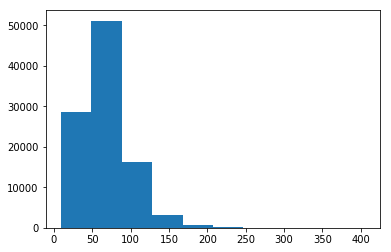

In [16]:
plt.hist(len_list_1)

(array([1.4693e+04, 6.1666e+04, 1.8708e+04, 3.9240e+03, 7.7900e+02,
        1.7500e+02, 3.3000e+01, 1.6000e+01, 4.0000e+00, 2.0000e+00]),
 array([  1. ,  23.6,  46.2,  68.8,  91.4, 114. , 136.6, 159.2, 181.8,
        204.4, 227. ]),
 <a list of 10 Patch objects>)

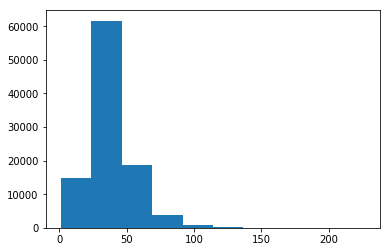

In [15]:
plt.hist(len_list_2)

In [17]:
gt, lt, eq = 0, 0, 0
for each in len_list_1:
    if each > 200:
        gt+=1
    elif each < 200:
        lt += 1
    else:
        eq += 1
gt, lt, eq

(302, 99692, 6)

In [19]:
gt, lt, eq = 0, 0, 0
for each in len_list_2:
    if each > 200:
        gt+=1
    elif each < 200:
        lt += 1
    else:
        eq += 1
gt, lt, eq

(2, 99998, 0)

In [18]:
max(len_list_1), max(len_list_2)

(406, 227)

In [20]:
np.mean(len_list_1), np.mean(len_list_2)

(67.52648, 38.26283)

Maximum sequence length of sentence1 is 406, maximum sequence length of sentence2 is 227.

However, only 302 data points out of 100000 (0.3%) sentence1 have length greater than 200. Only 2 datapoints out of 100000 sentence2 have length greater than 200. Therefore, we use 200 for maximum sequence length for both sentence1 and sentence2. This is to have reasonable 

## Verify batch

In [12]:
    words_ft, idx2words_ft, ordered_words_ft, loaded_embeddings_ft = set_words_data(50000)
    
    #snil_train_sent1_indices = token2index_dataset(snil_train['sentence1'], words_ft)
    #snil_train_sent2_indices = token2index_dataset(snil_train['sentence2'], words_ft)
    snil_val_sent1_indices = token2index_dataset(snil_val['sentence1'], words_ft)
    snil_val_sent2_indices = token2index_dataset(snil_val['sentence2'], words_ft)
    #snil_train_label_indices = label2index_dataset(snil_train['label'], label_to_idx)
    snil_val_label_indices = label2index_dataset(snil_val['label'], label_to_idx)
    val_dataset = SNILDataset(snil_val_sent1_indices, snil_val_sent2_indices, snil_val_label_indices)
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                               batch_size=32,
                                               collate_fn=snil_collate_func,
                                               shuffle=False)

In [13]:
# check all batches are correct
for i, (data1, data2, lengths1, lengths2, labels, keys, reorder_sent2_list) in enumerate(val_loader):
    for index_in_batch in range(len(data1)):
        key = keys.cpu().numpy()[index_in_batch]
        print(snil_val.iloc[key])
        result = ""
        for token in data1[index_in_batch].cpu().numpy():
            if idx2words_ft[token]=='<pad>':
                print(result)
                break
            result += idx2words_ft[token]
            result += " "
        result = ""
        for token in data2[reorder_sent2_list,:][index_in_batch].cpu().numpy():
            if idx2words_ft[token]=='<pad>':
                print(result)
                break
            result += idx2words_ft[token]
            result += " "
        print(idx_to_label[labels[index_in_batch].cpu().item()])
        #print(data1[key])
        #print(data2[reorder_sent2_list,:][key])
    break

sentence1    Three women on a stage , one wearing red shoes...
sentence2            There are two women standing on the stage
label                                            contradiction
Name: 0, dtype: object
Three women on a stage , one wearing red shoes , black pants , and a gray shirt is sitting on a prop , another is sitting on the floor , and the third wearing a black shirt and pants is standing , as a gentleman in the back tunes an instrument . 
There are two women standing on the stage 
contradiction
sentence1    A lone , 2-3 year old blond child in a blue ja...
sentence2              The couch is pointed toward the front .
label                                            contradiction
Name: 26, dtype: object
A lone , 2-3 year old blond child in a blue jacket is putting a small black plastic item in his mouth as he <unk> on a waiting room couch pointed toward the back while looking at something or someone not in the room . 
The couch is pointed toward the front . 
contradicti

for i, (data1, data2, lengths1, lengths2, labels, keys, reorder_sent2_list) in enumerate(val_loader):
    print(keys)
    print(reorder_sent2_list)
    break

In [14]:
    model = RNN(loaded_embeddings_ft, 
                emb_size=300, 
                hidden_size=8,
                num_layers=1, 
                num_classes=3, 
                vocab_size=len(idx2words_ft)).cuda()

In [24]:
    model.eval()
    criterion = torch.nn.CrossEntropyLoss()
    for data1, data2, lengths1, lengths2, labels, keys, reorder_sent2_list in val_loader:
        #data_batch, lengths_batch, label_batch = data, lengths, labels
        outputs = model(data1, data2, lengths1, lengths2, reorder_sent2_list)
        print(criterion(outputs, labels).item())
        break

35.637779235839844


        model = CNN(loaded_embeddings_ft, 
                    emb_size=300, 
                    hidden_size=hidden_size,
                    num_layers=1, 
                    kernel_size=kernel_size,
                    num_classes=3, 
                    vocab_size=len(idx2words_ft)).cuda()

In [ ]:
for max_vocab_size in [20000,40000,60000,80000,100000,120000,140000,160000,200000]:
    train("fixed_kernel_size", 256, max_vocab_size, 32, model_type="cnn")


saved cnn_snli_fixed_kernel_size_maxvocab_20000_hid_256_batch_32_lr_0.0003_l2_0/epoch_0_step_100.p
Epoch: [1/30], Step: [101/3125], Validation Acc: 37.9

saved cnn_snli_fixed_kernel_size_maxvocab_20000_hid_256_batch_32_lr_0.0003_l2_0/epoch_0_step_200.p
Epoch: [1/30], Step: [201/3125], Validation Acc: 47.6

saved cnn_snli_fixed_kernel_size_maxvocab_20000_hid_256_batch_32_lr_0.0003_l2_0/epoch_0_step_300.p
Epoch: [1/30], Step: [301/3125], Validation Acc: 52.2

saved cnn_snli_fixed_kernel_size_maxvocab_20000_hid_256_batch_32_lr_0.0003_l2_0/epoch_0_step_400.p
Epoch: [1/30], Step: [401/3125], Validation Acc: 55.3

Epoch: [1/30], Step: [501/3125], Validation Acc: 55.1

saved cnn_snli_fixed_kernel_size_maxvocab_20000_hid_256_batch_32_lr_0.0003_l2_0/epoch_0_step_600.p
Epoch: [1/30], Step: [601/3125], Validation Acc: 55.6

Epoch: [1/30], Step: [701/3125], Validation Acc: 55.0

saved cnn_snli_fixed_kernel_size_maxvocab_20000_hid_256_batch_32_lr_0.0003_l2_0/epoch_0_step_800.p
Epoch: [1/30], Step:


Epoch: [4/30], Step: [1801/3125], Validation Acc: 64.0

Epoch: [4/30], Step: [1901/3125], Validation Acc: 64.9

Epoch: [4/30], Step: [2001/3125], Validation Acc: 64.6

Epoch: [4/30], Step: [2101/3125], Validation Acc: 62.5

Epoch: [4/30], Step: [2201/3125], Validation Acc: 64.5

Epoch: [4/30], Step: [2301/3125], Validation Acc: 64.1

Epoch: [4/30], Step: [2401/3125], Validation Acc: 63.9

Epoch: [4/30], Step: [2501/3125], Validation Acc: 64.4

Epoch: [4/30], Step: [2601/3125], Validation Acc: 65.2

Epoch: [4/30], Step: [2701/3125], Validation Acc: 65.0

Epoch: [4/30], Step: [2801/3125], Validation Acc: 64.2

Epoch: [4/30], Step: [2901/3125], Validation Acc: 64.5

Epoch: [4/30], Step: [3001/3125], Validation Acc: 63.3

Epoch: [4/30], Step: [3101/3125], Validation Acc: 64.2

Epoch: [5/30], Step: [101/3125], Validation Acc: 62.9

Epoch: [5/30], Step: [201/3125], Validation Acc: 63.9

Epoch: [5/30], Step: [301/3125], Validation Acc: 63.9

Epoch: [5/30], Step: [401/3125], Validation Acc: 6


Epoch: [9/30], Step: [1101/3125], Validation Acc: 60.9

Epoch: [9/30], Step: [1201/3125], Validation Acc: 61.9

Epoch: [9/30], Step: [1301/3125], Validation Acc: 60.8

Epoch: [9/30], Step: [1401/3125], Validation Acc: 61.1

Epoch: [9/30], Step: [1501/3125], Validation Acc: 61.2

Epoch: [9/30], Step: [1601/3125], Validation Acc: 60.6

Epoch: [9/30], Step: [1701/3125], Validation Acc: 59.7

Epoch: [9/30], Step: [1801/3125], Validation Acc: 60.6

Epoch: [9/30], Step: [1901/3125], Validation Acc: 61.7

Epoch: [9/30], Step: [2001/3125], Validation Acc: 61.4

Epoch: [9/30], Step: [2101/3125], Validation Acc: 61.3

Epoch: [9/30], Step: [2201/3125], Validation Acc: 60.4

Epoch: [9/30], Step: [2301/3125], Validation Acc: 60.2

Epoch: [9/30], Step: [2401/3125], Validation Acc: 61.8

Epoch: [9/30], Step: [2501/3125], Validation Acc: 60.7

Epoch: [9/30], Step: [2601/3125], Validation Acc: 62.3

Epoch: [9/30], Step: [2701/3125], Validation Acc: 60.8

Epoch: [9/30], Step: [2801/3125], Validation Ac


Epoch: [14/30], Step: [101/3125], Validation Acc: 61.0

Epoch: [14/30], Step: [201/3125], Validation Acc: 59.9

Epoch: [14/30], Step: [301/3125], Validation Acc: 61.1

Epoch: [14/30], Step: [401/3125], Validation Acc: 61.1

Epoch: [14/30], Step: [501/3125], Validation Acc: 61.9

Epoch: [14/30], Step: [601/3125], Validation Acc: 61.1

Epoch: [14/30], Step: [701/3125], Validation Acc: 60.8

Epoch: [14/30], Step: [801/3125], Validation Acc: 60.9

Epoch: [14/30], Step: [901/3125], Validation Acc: 60.6

Epoch: [14/30], Step: [1001/3125], Validation Acc: 60.7

Epoch: [14/30], Step: [1101/3125], Validation Acc: 61.5

Epoch: [14/30], Step: [1201/3125], Validation Acc: 61.7

Epoch: [14/30], Step: [1301/3125], Validation Acc: 60.3

Epoch: [14/30], Step: [1401/3125], Validation Acc: 59.2

Epoch: [14/30], Step: [1501/3125], Validation Acc: 60.2

Epoch: [14/30], Step: [1601/3125], Validation Acc: 61.2

Epoch: [14/30], Step: [1701/3125], Validation Acc: 61.8

Epoch: [14/30], Step: [1801/3125], Vali


Epoch: [18/30], Step: [2201/3125], Validation Acc: 59.5

Epoch: [18/30], Step: [2301/3125], Validation Acc: 59.5

Epoch: [18/30], Step: [2401/3125], Validation Acc: 59.9

Epoch: [18/30], Step: [2501/3125], Validation Acc: 60.2

Epoch: [18/30], Step: [2601/3125], Validation Acc: 58.6

Epoch: [18/30], Step: [2701/3125], Validation Acc: 59.9

Epoch: [18/30], Step: [2801/3125], Validation Acc: 58.5

Epoch: [18/30], Step: [2901/3125], Validation Acc: 59.0

Epoch: [18/30], Step: [3001/3125], Validation Acc: 59.1

Epoch: [18/30], Step: [3101/3125], Validation Acc: 59.2

Epoch: [19/30], Step: [101/3125], Validation Acc: 58.7

Epoch: [19/30], Step: [201/3125], Validation Acc: 59.9

Epoch: [19/30], Step: [301/3125], Validation Acc: 58.6

Epoch: [19/30], Step: [401/3125], Validation Acc: 59.2

Epoch: [19/30], Step: [501/3125], Validation Acc: 59.3

Epoch: [19/30], Step: [601/3125], Validation Acc: 60.1

Epoch: [19/30], Step: [701/3125], Validation Acc: 61.0

Epoch: [19/30], Step: [801/3125], Val


Epoch: [23/30], Step: [1201/3125], Validation Acc: 58.4

Epoch: [23/30], Step: [1301/3125], Validation Acc: 59.2

Epoch: [23/30], Step: [1401/3125], Validation Acc: 58.8

Epoch: [23/30], Step: [1501/3125], Validation Acc: 57.9

Epoch: [23/30], Step: [1601/3125], Validation Acc: 58.7

Epoch: [23/30], Step: [1701/3125], Validation Acc: 59.8

Epoch: [23/30], Step: [1801/3125], Validation Acc: 59.9

Epoch: [23/30], Step: [1901/3125], Validation Acc: 58.9

Epoch: [23/30], Step: [2001/3125], Validation Acc: 58.2

Epoch: [23/30], Step: [2101/3125], Validation Acc: 60.0

Epoch: [23/30], Step: [2201/3125], Validation Acc: 59.7

Epoch: [23/30], Step: [2301/3125], Validation Acc: 59.3

Epoch: [23/30], Step: [2401/3125], Validation Acc: 59.0

Epoch: [23/30], Step: [2501/3125], Validation Acc: 58.9

Epoch: [23/30], Step: [2601/3125], Validation Acc: 61.4

Epoch: [23/30], Step: [2701/3125], Validation Acc: 58.4

Epoch: [23/30], Step: [2801/3125], Validation Acc: 58.7

Epoch: [23/30], Step: [2901/31


Epoch: [28/30], Step: [201/3125], Validation Acc: 58.7

Epoch: [28/30], Step: [301/3125], Validation Acc: 57.9

Epoch: [28/30], Step: [401/3125], Validation Acc: 58.8

Epoch: [28/30], Step: [501/3125], Validation Acc: 59.2

Epoch: [28/30], Step: [601/3125], Validation Acc: 59.6

Epoch: [28/30], Step: [701/3125], Validation Acc: 59.4

Epoch: [28/30], Step: [801/3125], Validation Acc: 59.2

Epoch: [28/30], Step: [901/3125], Validation Acc: 60.5

Epoch: [28/30], Step: [1001/3125], Validation Acc: 58.9

Epoch: [28/30], Step: [1101/3125], Validation Acc: 59.9

Epoch: [28/30], Step: [1201/3125], Validation Acc: 60.8

Epoch: [28/30], Step: [1301/3125], Validation Acc: 59.7

Epoch: [28/30], Step: [1401/3125], Validation Acc: 59.8

Epoch: [28/30], Step: [1501/3125], Validation Acc: 59.5

Epoch: [28/30], Step: [1601/3125], Validation Acc: 59.9

Epoch: [28/30], Step: [1701/3125], Validation Acc: 59.2

Epoch: [28/30], Step: [1801/3125], Validation Acc: 59.7

Epoch: [28/30], Step: [1901/3125], Val


Epoch: [2/30], Step: [201/3125], Validation Acc: 62.6

Epoch: [2/30], Step: [301/3125], Validation Acc: 60.4

Epoch: [2/30], Step: [401/3125], Validation Acc: 62.1

Epoch: [2/30], Step: [501/3125], Validation Acc: 62.6

Epoch: [2/30], Step: [601/3125], Validation Acc: 62.6

Epoch: [2/30], Step: [701/3125], Validation Acc: 62.1

Epoch: [2/30], Step: [801/3125], Validation Acc: 61.7

Epoch: [2/30], Step: [901/3125], Validation Acc: 62.9

Epoch: [2/30], Step: [1001/3125], Validation Acc: 62.5

Epoch: [2/30], Step: [1101/3125], Validation Acc: 62.2

Epoch: [2/30], Step: [1201/3125], Validation Acc: 63.5

Epoch: [2/30], Step: [1301/3125], Validation Acc: 63.2

Epoch: [2/30], Step: [1401/3125], Validation Acc: 63.0

Epoch: [2/30], Step: [1501/3125], Validation Acc: 63.0

Epoch: [2/30], Step: [1601/3125], Validation Acc: 62.3

Epoch: [2/30], Step: [1701/3125], Validation Acc: 62.6

Epoch: [2/30], Step: [1801/3125], Validation Acc: 62.1

Epoch: [2/30], Step: [1901/3125], Validation Acc: 61.9



Epoch: [6/30], Step: [1801/3125], Validation Acc: 63.1

Epoch: [6/30], Step: [1901/3125], Validation Acc: 61.9

Epoch: [6/30], Step: [2001/3125], Validation Acc: 61.9

Epoch: [6/30], Step: [2101/3125], Validation Acc: 62.2

Epoch: [6/30], Step: [2201/3125], Validation Acc: 63.0

Epoch: [6/30], Step: [2301/3125], Validation Acc: 62.9

Epoch: [6/30], Step: [2401/3125], Validation Acc: 62.9

Epoch: [6/30], Step: [2501/3125], Validation Acc: 62.6

Epoch: [6/30], Step: [2601/3125], Validation Acc: 63.8

Epoch: [6/30], Step: [2701/3125], Validation Acc: 63.7

Epoch: [6/30], Step: [2801/3125], Validation Acc: 62.1

Epoch: [6/30], Step: [2901/3125], Validation Acc: 63.1

Epoch: [6/30], Step: [3001/3125], Validation Acc: 62.2

Epoch: [6/30], Step: [3101/3125], Validation Acc: 61.7

Epoch: [7/30], Step: [101/3125], Validation Acc: 62.1

Epoch: [7/30], Step: [201/3125], Validation Acc: 61.9

Epoch: [7/30], Step: [301/3125], Validation Acc: 61.3

Epoch: [7/30], Step: [401/3125], Validation Acc: 5


Epoch: [11/30], Step: [1001/3125], Validation Acc: 61.1

Epoch: [11/30], Step: [1101/3125], Validation Acc: 62.0

Epoch: [11/30], Step: [1201/3125], Validation Acc: 60.8

Epoch: [11/30], Step: [1301/3125], Validation Acc: 61.2

Epoch: [11/30], Step: [1401/3125], Validation Acc: 59.4

Epoch: [11/30], Step: [1501/3125], Validation Acc: 60.9

Epoch: [11/30], Step: [1601/3125], Validation Acc: 61.3

Epoch: [11/30], Step: [1701/3125], Validation Acc: 60.6

Epoch: [11/30], Step: [1801/3125], Validation Acc: 59.7

Epoch: [11/30], Step: [1901/3125], Validation Acc: 60.4

Epoch: [11/30], Step: [2001/3125], Validation Acc: 60.1

Epoch: [11/30], Step: [2101/3125], Validation Acc: 59.8

Epoch: [11/30], Step: [2201/3125], Validation Acc: 60.7

Epoch: [11/30], Step: [2301/3125], Validation Acc: 58.9

Epoch: [11/30], Step: [2401/3125], Validation Acc: 59.1

Epoch: [11/30], Step: [2501/3125], Validation Acc: 59.6

Epoch: [11/30], Step: [2601/3125], Validation Acc: 59.4

Epoch: [11/30], Step: [2701/31


Epoch: [15/30], Step: [3101/3125], Validation Acc: 60.0

Epoch: [16/30], Step: [101/3125], Validation Acc: 60.0

Epoch: [16/30], Step: [201/3125], Validation Acc: 60.6

Epoch: [16/30], Step: [301/3125], Validation Acc: 60.8

Epoch: [16/30], Step: [401/3125], Validation Acc: 60.0

Epoch: [16/30], Step: [501/3125], Validation Acc: 60.6

Epoch: [16/30], Step: [601/3125], Validation Acc: 60.5

Epoch: [16/30], Step: [701/3125], Validation Acc: 58.7

Epoch: [16/30], Step: [801/3125], Validation Acc: 58.9

Epoch: [16/30], Step: [901/3125], Validation Acc: 60.4

Epoch: [16/30], Step: [1001/3125], Validation Acc: 60.5

Epoch: [16/30], Step: [1101/3125], Validation Acc: 60.6

Epoch: [16/30], Step: [1201/3125], Validation Acc: 61.1

Epoch: [16/30], Step: [1301/3125], Validation Acc: 59.6

Epoch: [16/30], Step: [1401/3125], Validation Acc: 60.2

Epoch: [16/30], Step: [1501/3125], Validation Acc: 60.6

Epoch: [16/30], Step: [1601/3125], Validation Acc: 58.9

Epoch: [16/30], Step: [1701/3125], Vali


Epoch: [20/30], Step: [2101/3125], Validation Acc: 59.4

Epoch: [20/30], Step: [2201/3125], Validation Acc: 58.4

Epoch: [20/30], Step: [2301/3125], Validation Acc: 58.2

Epoch: [20/30], Step: [2401/3125], Validation Acc: 59.6

Epoch: [20/30], Step: [2501/3125], Validation Acc: 59.8

Epoch: [20/30], Step: [2601/3125], Validation Acc: 60.8

Epoch: [20/30], Step: [2701/3125], Validation Acc: 59.4

Epoch: [20/30], Step: [2801/3125], Validation Acc: 59.1

Epoch: [20/30], Step: [2901/3125], Validation Acc: 58.2

Epoch: [20/30], Step: [3001/3125], Validation Acc: 59.2

Epoch: [20/30], Step: [3101/3125], Validation Acc: 60.3

Epoch: [21/30], Step: [101/3125], Validation Acc: 59.5

Epoch: [21/30], Step: [201/3125], Validation Acc: 61.1

Epoch: [21/30], Step: [301/3125], Validation Acc: 59.3

Epoch: [21/30], Step: [401/3125], Validation Acc: 59.1

Epoch: [21/30], Step: [501/3125], Validation Acc: 60.3

Epoch: [21/30], Step: [601/3125], Validation Acc: 59.4

Epoch: [21/30], Step: [701/3125], Va


Epoch: [25/30], Step: [1101/3125], Validation Acc: 57.5

Epoch: [25/30], Step: [1201/3125], Validation Acc: 59.2

Epoch: [25/30], Step: [1301/3125], Validation Acc: 57.9

Epoch: [25/30], Step: [1401/3125], Validation Acc: 58.2

Epoch: [25/30], Step: [1501/3125], Validation Acc: 57.9

Epoch: [25/30], Step: [1601/3125], Validation Acc: 59.9

Epoch: [25/30], Step: [1701/3125], Validation Acc: 59.9

Epoch: [25/30], Step: [1801/3125], Validation Acc: 58.4

Epoch: [25/30], Step: [1901/3125], Validation Acc: 59.2

Epoch: [25/30], Step: [2001/3125], Validation Acc: 60.1

Epoch: [25/30], Step: [2101/3125], Validation Acc: 58.8

Epoch: [25/30], Step: [2201/3125], Validation Acc: 61.1

Epoch: [25/30], Step: [2301/3125], Validation Acc: 60.9

Epoch: [25/30], Step: [2401/3125], Validation Acc: 58.5

Epoch: [25/30], Step: [2501/3125], Validation Acc: 59.8

Epoch: [25/30], Step: [2601/3125], Validation Acc: 59.4

Epoch: [25/30], Step: [2701/3125], Validation Acc: 59.6

Epoch: [25/30], Step: [2801/31


Epoch: [30/30], Step: [101/3125], Validation Acc: 61.1

Epoch: [30/30], Step: [201/3125], Validation Acc: 60.0

Epoch: [30/30], Step: [301/3125], Validation Acc: 59.2

Epoch: [30/30], Step: [401/3125], Validation Acc: 59.3

Epoch: [30/30], Step: [501/3125], Validation Acc: 60.2

Epoch: [30/30], Step: [601/3125], Validation Acc: 60.4

Epoch: [30/30], Step: [701/3125], Validation Acc: 60.2

Epoch: [30/30], Step: [801/3125], Validation Acc: 59.9

Epoch: [30/30], Step: [901/3125], Validation Acc: 61.4

Epoch: [30/30], Step: [1001/3125], Validation Acc: 59.9

Epoch: [30/30], Step: [1101/3125], Validation Acc: 60.9

Epoch: [30/30], Step: [1201/3125], Validation Acc: 61.0

Epoch: [30/30], Step: [1301/3125], Validation Acc: 60.4

Epoch: [30/30], Step: [1401/3125], Validation Acc: 61.6

Epoch: [30/30], Step: [1501/3125], Validation Acc: 59.5

Epoch: [30/30], Step: [1601/3125], Validation Acc: 60.5

Epoch: [30/30], Step: [1701/3125], Validation Acc: 58.9

Epoch: [30/30], Step: [1801/3125], Vali


Epoch: [4/30], Step: [101/3125], Validation Acc: 64.5

Epoch: [4/30], Step: [201/3125], Validation Acc: 64.3

Epoch: [4/30], Step: [301/3125], Validation Acc: 64.0

Epoch: [4/30], Step: [401/3125], Validation Acc: 64.8

Epoch: [4/30], Step: [501/3125], Validation Acc: 64.2

Epoch: [4/30], Step: [601/3125], Validation Acc: 63.2

Epoch: [4/30], Step: [701/3125], Validation Acc: 63.3

Epoch: [4/30], Step: [801/3125], Validation Acc: 63.9

Epoch: [4/30], Step: [901/3125], Validation Acc: 65.1

Epoch: [4/30], Step: [1001/3125], Validation Acc: 62.5

Epoch: [4/30], Step: [1101/3125], Validation Acc: 62.0

Epoch: [4/30], Step: [1201/3125], Validation Acc: 64.8

Epoch: [4/30], Step: [1301/3125], Validation Acc: 62.4

Epoch: [4/30], Step: [1401/3125], Validation Acc: 63.3

Epoch: [4/30], Step: [1501/3125], Validation Acc: 64.1

Epoch: [4/30], Step: [1601/3125], Validation Acc: 63.9

Epoch: [4/30], Step: [1701/3125], Validation Acc: 64.0

Epoch: [4/30], Step: [1801/3125], Validation Acc: 62.7




Epoch: [8/30], Step: [2301/3125], Validation Acc: 62.7

Epoch: [8/30], Step: [2401/3125], Validation Acc: 61.7

Epoch: [8/30], Step: [2501/3125], Validation Acc: 60.2

Epoch: [8/30], Step: [2601/3125], Validation Acc: 62.6

Epoch: [8/30], Step: [2701/3125], Validation Acc: 63.2

Epoch: [8/30], Step: [2801/3125], Validation Acc: 63.7

Epoch: [8/30], Step: [2901/3125], Validation Acc: 61.3

Epoch: [8/30], Step: [3001/3125], Validation Acc: 61.0

Epoch: [8/30], Step: [3101/3125], Validation Acc: 62.3

Epoch: [9/30], Step: [101/3125], Validation Acc: 61.7

Epoch: [9/30], Step: [201/3125], Validation Acc: 62.3

Epoch: [9/30], Step: [301/3125], Validation Acc: 61.6

Epoch: [9/30], Step: [401/3125], Validation Acc: 62.5

Epoch: [9/30], Step: [501/3125], Validation Acc: 60.9

Epoch: [9/30], Step: [601/3125], Validation Acc: 61.5

Epoch: [9/30], Step: [701/3125], Validation Acc: 61.5

Epoch: [9/30], Step: [801/3125], Validation Acc: 61.7

Epoch: [9/30], Step: [901/3125], Validation Acc: 61.5




Epoch: [13/30], Step: [1401/3125], Validation Acc: 60.9

Epoch: [13/30], Step: [1501/3125], Validation Acc: 60.4

Epoch: [13/30], Step: [1601/3125], Validation Acc: 58.6

Epoch: [13/30], Step: [1701/3125], Validation Acc: 61.2

Epoch: [13/30], Step: [1801/3125], Validation Acc: 60.3

Epoch: [13/30], Step: [1901/3125], Validation Acc: 58.6

Epoch: [13/30], Step: [2001/3125], Validation Acc: 59.5

Epoch: [13/30], Step: [2101/3125], Validation Acc: 59.9

Epoch: [13/30], Step: [2201/3125], Validation Acc: 59.3

Epoch: [13/30], Step: [2301/3125], Validation Acc: 59.7

Epoch: [13/30], Step: [2401/3125], Validation Acc: 61.3

Epoch: [13/30], Step: [2501/3125], Validation Acc: 60.4

Epoch: [13/30], Step: [2601/3125], Validation Acc: 59.4

Epoch: [13/30], Step: [2701/3125], Validation Acc: 60.5

Epoch: [13/30], Step: [2801/3125], Validation Acc: 60.3

Epoch: [13/30], Step: [2901/3125], Validation Acc: 60.0

Epoch: [13/30], Step: [3001/3125], Validation Acc: 59.5

Epoch: [13/30], Step: [3101/31


Epoch: [18/30], Step: [401/3125], Validation Acc: 58.3

Epoch: [18/30], Step: [501/3125], Validation Acc: 59.2

Epoch: [18/30], Step: [601/3125], Validation Acc: 60.3

Epoch: [18/30], Step: [701/3125], Validation Acc: 60.6

Epoch: [18/30], Step: [801/3125], Validation Acc: 60.8

Epoch: [18/30], Step: [901/3125], Validation Acc: 60.8

Epoch: [18/30], Step: [1001/3125], Validation Acc: 60.2

Epoch: [18/30], Step: [1101/3125], Validation Acc: 59.1

Epoch: [18/30], Step: [1201/3125], Validation Acc: 59.2

Epoch: [18/30], Step: [1301/3125], Validation Acc: 58.5

Epoch: [18/30], Step: [1401/3125], Validation Acc: 60.6

Epoch: [18/30], Step: [1501/3125], Validation Acc: 59.1

Epoch: [18/30], Step: [1601/3125], Validation Acc: 60.0

Epoch: [18/30], Step: [1701/3125], Validation Acc: 60.8

Epoch: [18/30], Step: [1801/3125], Validation Acc: 61.1

Epoch: [18/30], Step: [1901/3125], Validation Acc: 60.1

Epoch: [18/30], Step: [2001/3125], Validation Acc: 62.1

Epoch: [18/30], Step: [2101/3125], V


Epoch: [22/30], Step: [2501/3125], Validation Acc: 60.6

Epoch: [22/30], Step: [2601/3125], Validation Acc: 60.7

Epoch: [22/30], Step: [2701/3125], Validation Acc: 61.1

Epoch: [22/30], Step: [2801/3125], Validation Acc: 60.2

Epoch: [22/30], Step: [2901/3125], Validation Acc: 61.3

Epoch: [22/30], Step: [3001/3125], Validation Acc: 60.7

Epoch: [22/30], Step: [3101/3125], Validation Acc: 60.2

Epoch: [23/30], Step: [101/3125], Validation Acc: 60.5

Epoch: [23/30], Step: [201/3125], Validation Acc: 61.0

Epoch: [23/30], Step: [301/3125], Validation Acc: 61.4

Epoch: [23/30], Step: [401/3125], Validation Acc: 61.2

Epoch: [23/30], Step: [501/3125], Validation Acc: 62.6

Epoch: [23/30], Step: [601/3125], Validation Acc: 61.2

Epoch: [23/30], Step: [701/3125], Validation Acc: 61.2

Epoch: [23/30], Step: [801/3125], Validation Acc: 61.2

Epoch: [23/30], Step: [901/3125], Validation Acc: 60.5

Epoch: [23/30], Step: [1001/3125], Validation Acc: 60.5

Epoch: [23/30], Step: [1101/3125], Vali


Epoch: [27/30], Step: [1501/3125], Validation Acc: 60.9

Epoch: [27/30], Step: [1601/3125], Validation Acc: 61.4

Epoch: [27/30], Step: [1701/3125], Validation Acc: 61.5

Epoch: [27/30], Step: [1801/3125], Validation Acc: 60.9

Epoch: [27/30], Step: [1901/3125], Validation Acc: 62.3

Epoch: [27/30], Step: [2001/3125], Validation Acc: 61.7

Epoch: [27/30], Step: [2101/3125], Validation Acc: 62.0

Epoch: [27/30], Step: [2201/3125], Validation Acc: 61.7

Epoch: [27/30], Step: [2301/3125], Validation Acc: 62.3

Epoch: [27/30], Step: [2401/3125], Validation Acc: 61.8

Epoch: [27/30], Step: [2501/3125], Validation Acc: 61.8

Epoch: [27/30], Step: [2601/3125], Validation Acc: 61.7

Epoch: [27/30], Step: [2701/3125], Validation Acc: 61.4

Epoch: [27/30], Step: [2801/3125], Validation Acc: 61.5

Epoch: [27/30], Step: [2901/3125], Validation Acc: 62.2

Epoch: [27/30], Step: [3001/3125], Validation Acc: 61.7

Epoch: [27/30], Step: [3101/3125], Validation Acc: 62.0

Epoch: [28/30], Step: [101/312


Epoch: [1/30], Step: [1901/3125], Validation Acc: 61.9

Epoch: [1/30], Step: [2001/3125], Validation Acc: 61.8

Epoch: [1/30], Step: [2101/3125], Validation Acc: 61.6

Epoch: [1/30], Step: [2201/3125], Validation Acc: 61.9

Epoch: [1/30], Step: [2301/3125], Validation Acc: 62.1

Epoch: [1/30], Step: [2401/3125], Validation Acc: 62.0

Epoch: [1/30], Step: [2501/3125], Validation Acc: 62.9

Epoch: [1/30], Step: [2601/3125], Validation Acc: 62.9

Epoch: [1/30], Step: [2701/3125], Validation Acc: 62.4

Epoch: [1/30], Step: [2801/3125], Validation Acc: 61.8

Epoch: [1/30], Step: [2901/3125], Validation Acc: 61.2

saved cnn_snli_fixed_kernel_size_maxvocab_80000_hid_256_batch_32_lr_0.0003_l2_0/epoch_0_step_3000.p
Epoch: [1/30], Step: [3001/3125], Validation Acc: 63.6

Epoch: [1/30], Step: [3101/3125], Validation Acc: 61.0

Epoch: [2/30], Step: [101/3125], Validation Acc: 61.5

Epoch: [2/30], Step: [201/3125], Validation Acc: 61.6

Epoch: [2/30], Step: [301/3125], Validation Acc: 63.0

Epoch:


Epoch: [5/30], Step: [3001/3125], Validation Acc: 63.8

Epoch: [5/30], Step: [3101/3125], Validation Acc: 64.5

Epoch: [6/30], Step: [101/3125], Validation Acc: 62.8

Epoch: [6/30], Step: [201/3125], Validation Acc: 62.5

Epoch: [6/30], Step: [301/3125], Validation Acc: 63.2

Epoch: [6/30], Step: [401/3125], Validation Acc: 63.5

Epoch: [6/30], Step: [501/3125], Validation Acc: 64.1

Epoch: [6/30], Step: [601/3125], Validation Acc: 64.8

Epoch: [6/30], Step: [701/3125], Validation Acc: 63.3

Epoch: [6/30], Step: [801/3125], Validation Acc: 62.8

Epoch: [6/30], Step: [901/3125], Validation Acc: 62.3

Epoch: [6/30], Step: [1001/3125], Validation Acc: 63.4

Epoch: [6/30], Step: [1101/3125], Validation Acc: 62.1

Epoch: [6/30], Step: [1201/3125], Validation Acc: 61.8

Epoch: [6/30], Step: [1301/3125], Validation Acc: 62.5

Epoch: [6/30], Step: [1401/3125], Validation Acc: 63.9

Epoch: [6/30], Step: [1501/3125], Validation Acc: 62.9

Epoch: [6/30], Step: [1601/3125], Validation Acc: 62.7




Epoch: [10/30], Step: [2201/3125], Validation Acc: 62.0

Epoch: [10/30], Step: [2301/3125], Validation Acc: 61.5

Epoch: [10/30], Step: [2401/3125], Validation Acc: 60.3

Epoch: [10/30], Step: [2501/3125], Validation Acc: 60.5

Epoch: [10/30], Step: [2601/3125], Validation Acc: 59.8

Epoch: [10/30], Step: [2701/3125], Validation Acc: 61.4

Epoch: [10/30], Step: [2801/3125], Validation Acc: 62.1

Epoch: [10/30], Step: [2901/3125], Validation Acc: 61.0

Epoch: [10/30], Step: [3001/3125], Validation Acc: 60.2

Epoch: [10/30], Step: [3101/3125], Validation Acc: 60.9

Epoch: [11/30], Step: [101/3125], Validation Acc: 62.1

Epoch: [11/30], Step: [201/3125], Validation Acc: 61.0

Epoch: [11/30], Step: [301/3125], Validation Acc: 61.4

Epoch: [11/30], Step: [401/3125], Validation Acc: 62.5

Epoch: [11/30], Step: [501/3125], Validation Acc: 60.7

Epoch: [11/30], Step: [601/3125], Validation Acc: 59.9

Epoch: [11/30], Step: [701/3125], Validation Acc: 59.2

Epoch: [11/30], Step: [801/3125], Val


Epoch: [15/30], Step: [1201/3125], Validation Acc: 60.8

Epoch: [15/30], Step: [1301/3125], Validation Acc: 60.0

Epoch: [15/30], Step: [1401/3125], Validation Acc: 59.6

Epoch: [15/30], Step: [1501/3125], Validation Acc: 59.7

Epoch: [15/30], Step: [1601/3125], Validation Acc: 59.0

Epoch: [15/30], Step: [1701/3125], Validation Acc: 59.2

Epoch: [15/30], Step: [1801/3125], Validation Acc: 59.9

Epoch: [15/30], Step: [1901/3125], Validation Acc: 59.9

Epoch: [15/30], Step: [2001/3125], Validation Acc: 60.1

Epoch: [15/30], Step: [2101/3125], Validation Acc: 60.7

Epoch: [15/30], Step: [2201/3125], Validation Acc: 59.9

Epoch: [15/30], Step: [2301/3125], Validation Acc: 60.8

Epoch: [15/30], Step: [2401/3125], Validation Acc: 61.1

Epoch: [15/30], Step: [2501/3125], Validation Acc: 61.2

Epoch: [15/30], Step: [2601/3125], Validation Acc: 60.8

Epoch: [15/30], Step: [2701/3125], Validation Acc: 60.6

Epoch: [15/30], Step: [2801/3125], Validation Acc: 59.8

Epoch: [15/30], Step: [2901/31


Epoch: [20/30], Step: [201/3125], Validation Acc: 61.9

Epoch: [20/30], Step: [301/3125], Validation Acc: 62.5

Epoch: [20/30], Step: [401/3125], Validation Acc: 60.9

Epoch: [20/30], Step: [501/3125], Validation Acc: 61.6

Epoch: [20/30], Step: [601/3125], Validation Acc: 62.0

Epoch: [20/30], Step: [701/3125], Validation Acc: 62.5

Epoch: [20/30], Step: [801/3125], Validation Acc: 61.8

Epoch: [20/30], Step: [901/3125], Validation Acc: 62.7

Epoch: [20/30], Step: [1001/3125], Validation Acc: 62.6

Epoch: [20/30], Step: [1101/3125], Validation Acc: 60.9

Epoch: [20/30], Step: [1201/3125], Validation Acc: 60.8

Epoch: [20/30], Step: [1301/3125], Validation Acc: 61.3

Epoch: [20/30], Step: [1401/3125], Validation Acc: 61.0

Epoch: [20/30], Step: [1501/3125], Validation Acc: 60.9

Epoch: [20/30], Step: [1601/3125], Validation Acc: 61.6

Epoch: [20/30], Step: [1701/3125], Validation Acc: 61.1

Epoch: [20/30], Step: [1801/3125], Validation Acc: 61.2

Epoch: [20/30], Step: [1901/3125], Val


Epoch: [24/30], Step: [2301/3125], Validation Acc: 61.4

Epoch: [24/30], Step: [2401/3125], Validation Acc: 60.7

Epoch: [24/30], Step: [2501/3125], Validation Acc: 60.1

Epoch: [24/30], Step: [2601/3125], Validation Acc: 60.8

Epoch: [24/30], Step: [2701/3125], Validation Acc: 60.7

Epoch: [24/30], Step: [2801/3125], Validation Acc: 61.7

Epoch: [24/30], Step: [2901/3125], Validation Acc: 62.4

Epoch: [24/30], Step: [3001/3125], Validation Acc: 62.1

Epoch: [24/30], Step: [3101/3125], Validation Acc: 61.4

Epoch: [25/30], Step: [101/3125], Validation Acc: 60.3

Epoch: [25/30], Step: [201/3125], Validation Acc: 60.4

Epoch: [25/30], Step: [301/3125], Validation Acc: 61.2

Epoch: [25/30], Step: [401/3125], Validation Acc: 60.9

Epoch: [25/30], Step: [501/3125], Validation Acc: 61.2

Epoch: [25/30], Step: [601/3125], Validation Acc: 60.8

Epoch: [25/30], Step: [701/3125], Validation Acc: 60.0

Epoch: [25/30], Step: [801/3125], Validation Acc: 60.7

Epoch: [25/30], Step: [901/3125], Vali


Epoch: [29/30], Step: [1301/3125], Validation Acc: 60.5

Epoch: [29/30], Step: [1401/3125], Validation Acc: 60.6

Epoch: [29/30], Step: [1501/3125], Validation Acc: 60.3

Epoch: [29/30], Step: [1601/3125], Validation Acc: 60.7

Epoch: [29/30], Step: [1701/3125], Validation Acc: 60.2

Epoch: [29/30], Step: [1801/3125], Validation Acc: 60.8

Epoch: [29/30], Step: [1901/3125], Validation Acc: 60.9

Epoch: [29/30], Step: [2001/3125], Validation Acc: 60.4

Epoch: [29/30], Step: [2101/3125], Validation Acc: 60.1

Epoch: [29/30], Step: [2201/3125], Validation Acc: 60.8

Epoch: [29/30], Step: [2301/3125], Validation Acc: 61.1

Epoch: [29/30], Step: [2401/3125], Validation Acc: 60.6

Epoch: [29/30], Step: [2501/3125], Validation Acc: 59.9

Epoch: [29/30], Step: [2601/3125], Validation Acc: 60.7

Epoch: [29/30], Step: [2701/3125], Validation Acc: 62.1

Epoch: [29/30], Step: [2801/3125], Validation Acc: 62.4

Epoch: [29/30], Step: [2901/3125], Validation Acc: 61.3

Epoch: [29/30], Step: [3001/31


Epoch: [3/30], Step: [301/3125], Validation Acc: 64.4

Epoch: [3/30], Step: [401/3125], Validation Acc: 63.8

Epoch: [3/30], Step: [501/3125], Validation Acc: 65.5

Epoch: [3/30], Step: [601/3125], Validation Acc: 65.0

Epoch: [3/30], Step: [701/3125], Validation Acc: 64.7

Epoch: [3/30], Step: [801/3125], Validation Acc: 65.7

Epoch: [3/30], Step: [901/3125], Validation Acc: 64.9

Epoch: [3/30], Step: [1001/3125], Validation Acc: 65.4

Epoch: [3/30], Step: [1101/3125], Validation Acc: 65.4

Epoch: [3/30], Step: [1201/3125], Validation Acc: 64.7

Epoch: [3/30], Step: [1301/3125], Validation Acc: 65.0

Epoch: [3/30], Step: [1401/3125], Validation Acc: 65.8

Epoch: [3/30], Step: [1501/3125], Validation Acc: 64.9

Epoch: [3/30], Step: [1601/3125], Validation Acc: 65.4

Epoch: [3/30], Step: [1701/3125], Validation Acc: 64.8

Epoch: [3/30], Step: [1801/3125], Validation Acc: 65.7

Epoch: [3/30], Step: [1901/3125], Validation Acc: 64.9

Epoch: [3/30], Step: [2001/3125], Validation Acc: 63.9


Epoch: [7/30], Step: [2701/3125], Validation Acc: 63.1

Epoch: [7/30], Step: [2801/3125], Validation Acc: 63.4

Epoch: [7/30], Step: [2901/3125], Validation Acc: 63.7

Epoch: [7/30], Step: [3001/3125], Validation Acc: 62.8

Epoch: [7/30], Step: [3101/3125], Validation Acc: 62.6

Epoch: [8/30], Step: [101/3125], Validation Acc: 63.7

Epoch: [8/30], Step: [201/3125], Validation Acc: 61.6

Epoch: [8/30], Step: [301/3125], Validation Acc: 63.1

Epoch: [8/30], Step: [401/3125], Validation Acc: 60.6

Epoch: [8/30], Step: [501/3125], Validation Acc: 62.5

Epoch: [8/30], Step: [601/3125], Validation Acc: 63.4

Epoch: [8/30], Step: [701/3125], Validation Acc: 61.8

Epoch: [8/30], Step: [801/3125], Validation Acc: 61.9

Epoch: [8/30], Step: [901/3125], Validation Acc: 61.5

Epoch: [8/30], Step: [1001/3125], Validation Acc: 62.5

Epoch: [8/30], Step: [1101/3125], Validation Acc: 59.8

Epoch: [8/30], Step: [1201/3125], Validation Acc: 61.1

Epoch: [8/30], Step: [1301/3125], Validation Acc: 62.2




Epoch: [12/30], Step: [1801/3125], Validation Acc: 58.4

Epoch: [12/30], Step: [1901/3125], Validation Acc: 60.4

Epoch: [12/30], Step: [2001/3125], Validation Acc: 60.0

Epoch: [12/30], Step: [2101/3125], Validation Acc: 60.9

Epoch: [12/30], Step: [2201/3125], Validation Acc: 61.4

Epoch: [12/30], Step: [2301/3125], Validation Acc: 60.0

Epoch: [12/30], Step: [2401/3125], Validation Acc: 60.3

Epoch: [12/30], Step: [2501/3125], Validation Acc: 61.8

Epoch: [12/30], Step: [2601/3125], Validation Acc: 61.2

Epoch: [12/30], Step: [2701/3125], Validation Acc: 61.3

Epoch: [12/30], Step: [2801/3125], Validation Acc: 60.8

Epoch: [12/30], Step: [2901/3125], Validation Acc: 60.8

Epoch: [12/30], Step: [3001/3125], Validation Acc: 60.4

Epoch: [12/30], Step: [3101/3125], Validation Acc: 60.6

Epoch: [13/30], Step: [101/3125], Validation Acc: 61.1

Epoch: [13/30], Step: [201/3125], Validation Acc: 60.5

Epoch: [13/30], Step: [301/3125], Validation Acc: 60.5

Epoch: [13/30], Step: [401/3125],


Epoch: [17/30], Step: [801/3125], Validation Acc: 60.9

Epoch: [17/30], Step: [901/3125], Validation Acc: 61.6

Epoch: [17/30], Step: [1001/3125], Validation Acc: 60.6

Epoch: [17/30], Step: [1101/3125], Validation Acc: 59.7

Epoch: [17/30], Step: [1201/3125], Validation Acc: 61.0

Epoch: [17/30], Step: [1301/3125], Validation Acc: 60.2

Epoch: [17/30], Step: [1401/3125], Validation Acc: 60.6

Epoch: [17/30], Step: [1501/3125], Validation Acc: 60.6

Epoch: [17/30], Step: [1601/3125], Validation Acc: 61.4

Epoch: [17/30], Step: [1701/3125], Validation Acc: 61.0

Epoch: [17/30], Step: [1801/3125], Validation Acc: 59.6

Epoch: [17/30], Step: [1901/3125], Validation Acc: 60.9

Epoch: [17/30], Step: [2001/3125], Validation Acc: 61.0

Epoch: [17/30], Step: [2101/3125], Validation Acc: 61.1

Epoch: [17/30], Step: [2201/3125], Validation Acc: 61.1

Epoch: [17/30], Step: [2301/3125], Validation Acc: 60.9

Epoch: [17/30], Step: [2401/3125], Validation Acc: 61.7

Epoch: [17/30], Step: [2501/3125


Epoch: [21/30], Step: [2901/3125], Validation Acc: 61.8

Epoch: [21/30], Step: [3001/3125], Validation Acc: 60.1

Epoch: [21/30], Step: [3101/3125], Validation Acc: 60.9

Epoch: [22/30], Step: [101/3125], Validation Acc: 61.3

Epoch: [22/30], Step: [201/3125], Validation Acc: 61.1

Epoch: [22/30], Step: [301/3125], Validation Acc: 61.5

Epoch: [22/30], Step: [401/3125], Validation Acc: 62.4

Epoch: [22/30], Step: [501/3125], Validation Acc: 61.5

Epoch: [22/30], Step: [601/3125], Validation Acc: 60.0

Epoch: [22/30], Step: [701/3125], Validation Acc: 61.0

Epoch: [22/30], Step: [801/3125], Validation Acc: 61.1

Epoch: [22/30], Step: [901/3125], Validation Acc: 60.6

Epoch: [22/30], Step: [1001/3125], Validation Acc: 58.6

Epoch: [22/30], Step: [1101/3125], Validation Acc: 60.9

Epoch: [22/30], Step: [1201/3125], Validation Acc: 60.7

Epoch: [22/30], Step: [1301/3125], Validation Acc: 59.7

Epoch: [22/30], Step: [1401/3125], Validation Acc: 59.1

Epoch: [22/30], Step: [1501/3125], Vali


Epoch: [26/30], Step: [1901/3125], Validation Acc: 60.8

Epoch: [26/30], Step: [2001/3125], Validation Acc: 59.5

Epoch: [26/30], Step: [2101/3125], Validation Acc: 61.0

Epoch: [26/30], Step: [2201/3125], Validation Acc: 60.9

Epoch: [26/30], Step: [2301/3125], Validation Acc: 61.1

Epoch: [26/30], Step: [2401/3125], Validation Acc: 61.5

Epoch: [26/30], Step: [2501/3125], Validation Acc: 60.5

Epoch: [26/30], Step: [2601/3125], Validation Acc: 61.0

Epoch: [26/30], Step: [2701/3125], Validation Acc: 60.6

Epoch: [26/30], Step: [2801/3125], Validation Acc: 62.5

Epoch: [26/30], Step: [2901/3125], Validation Acc: 61.3

Epoch: [26/30], Step: [3001/3125], Validation Acc: 61.7

Epoch: [26/30], Step: [3101/3125], Validation Acc: 61.1

Epoch: [27/30], Step: [101/3125], Validation Acc: 60.8

Epoch: [27/30], Step: [201/3125], Validation Acc: 61.4

Epoch: [27/30], Step: [301/3125], Validation Acc: 60.5

Epoch: [27/30], Step: [401/3125], Validation Acc: 59.6

Epoch: [27/30], Step: [501/3125], 


saved cnn_snli_fixed_kernel_size_maxvocab_120000_hid_256_batch_32_lr_0.0003_l2_0/epoch_0_step_400.p
Epoch: [1/30], Step: [401/3125], Validation Acc: 57.2

saved cnn_snli_fixed_kernel_size_maxvocab_120000_hid_256_batch_32_lr_0.0003_l2_0/epoch_0_step_500.p
Epoch: [1/30], Step: [501/3125], Validation Acc: 58.3

Epoch: [1/30], Step: [601/3125], Validation Acc: 57.9

saved cnn_snli_fixed_kernel_size_maxvocab_120000_hid_256_batch_32_lr_0.0003_l2_0/epoch_0_step_700.p
Epoch: [1/30], Step: [701/3125], Validation Acc: 59.5

saved cnn_snli_fixed_kernel_size_maxvocab_120000_hid_256_batch_32_lr_0.0003_l2_0/epoch_0_step_800.p
Epoch: [1/30], Step: [801/3125], Validation Acc: 60.0

Epoch: [1/30], Step: [901/3125], Validation Acc: 59.4

saved cnn_snli_fixed_kernel_size_maxvocab_120000_hid_256_batch_32_lr_0.0003_l2_0/epoch_0_step_1000.p
Epoch: [1/30], Step: [1001/3125], Validation Acc: 60.1

saved cnn_snli_fixed_kernel_size_maxvocab_120000_hid_256_batch_32_lr_0.0003_l2_0/epoch_0_step_1100.p
Epoch: [1/3


Epoch: [4/30], Step: [2601/3125], Validation Acc: 64.9

Epoch: [4/30], Step: [2701/3125], Validation Acc: 62.8

Epoch: [4/30], Step: [2801/3125], Validation Acc: 63.8

Epoch: [4/30], Step: [2901/3125], Validation Acc: 63.2

Epoch: [4/30], Step: [3001/3125], Validation Acc: 64.2

Epoch: [4/30], Step: [3101/3125], Validation Acc: 63.2

Epoch: [5/30], Step: [101/3125], Validation Acc: 64.2

Epoch: [5/30], Step: [201/3125], Validation Acc: 64.0

Epoch: [5/30], Step: [301/3125], Validation Acc: 63.3

Epoch: [5/30], Step: [401/3125], Validation Acc: 63.3

Epoch: [5/30], Step: [501/3125], Validation Acc: 63.7

Epoch: [5/30], Step: [601/3125], Validation Acc: 63.6

Epoch: [5/30], Step: [701/3125], Validation Acc: 64.5

Epoch: [5/30], Step: [801/3125], Validation Acc: 64.9

Epoch: [5/30], Step: [901/3125], Validation Acc: 64.7

Epoch: [5/30], Step: [1001/3125], Validation Acc: 65.4

Epoch: [5/30], Step: [1101/3125], Validation Acc: 63.3

Epoch: [5/30], Step: [1201/3125], Validation Acc: 63.3




Epoch: [9/30], Step: [1901/3125], Validation Acc: 63.1

Epoch: [9/30], Step: [2001/3125], Validation Acc: 62.2

Epoch: [9/30], Step: [2101/3125], Validation Acc: 61.8

Epoch: [9/30], Step: [2201/3125], Validation Acc: 62.1

Epoch: [9/30], Step: [2301/3125], Validation Acc: 62.7

Epoch: [9/30], Step: [2401/3125], Validation Acc: 62.8

Epoch: [9/30], Step: [2501/3125], Validation Acc: 61.8

Epoch: [9/30], Step: [2601/3125], Validation Acc: 61.7

Epoch: [9/30], Step: [2701/3125], Validation Acc: 61.2

Epoch: [9/30], Step: [2801/3125], Validation Acc: 62.4

Epoch: [9/30], Step: [2901/3125], Validation Acc: 62.7

Epoch: [9/30], Step: [3001/3125], Validation Acc: 61.6

Epoch: [9/30], Step: [3101/3125], Validation Acc: 61.2

Epoch: [10/30], Step: [101/3125], Validation Acc: 62.9

Epoch: [10/30], Step: [201/3125], Validation Acc: 61.9

Epoch: [10/30], Step: [301/3125], Validation Acc: 60.7

Epoch: [10/30], Step: [401/3125], Validation Acc: 62.2

Epoch: [10/30], Step: [501/3125], Validation Ac


Epoch: [14/30], Step: [901/3125], Validation Acc: 60.8

Epoch: [14/30], Step: [1001/3125], Validation Acc: 61.1

Epoch: [14/30], Step: [1101/3125], Validation Acc: 60.8

Epoch: [14/30], Step: [1201/3125], Validation Acc: 58.9

Epoch: [14/30], Step: [1301/3125], Validation Acc: 60.5

Epoch: [14/30], Step: [1401/3125], Validation Acc: 61.3

Epoch: [14/30], Step: [1501/3125], Validation Acc: 60.7

Epoch: [14/30], Step: [1601/3125], Validation Acc: 60.8

Epoch: [14/30], Step: [1701/3125], Validation Acc: 59.8

Epoch: [14/30], Step: [1801/3125], Validation Acc: 61.7

Epoch: [14/30], Step: [1901/3125], Validation Acc: 62.0

Epoch: [14/30], Step: [2001/3125], Validation Acc: 61.0

Epoch: [14/30], Step: [2101/3125], Validation Acc: 59.8

Epoch: [14/30], Step: [2201/3125], Validation Acc: 61.3

Epoch: [14/30], Step: [2301/3125], Validation Acc: 60.2

Epoch: [14/30], Step: [2401/3125], Validation Acc: 61.0

Epoch: [14/30], Step: [2501/3125], Validation Acc: 61.5

Epoch: [14/30], Step: [2601/312


Epoch: [18/30], Step: [3001/3125], Validation Acc: 63.4

Epoch: [18/30], Step: [3101/3125], Validation Acc: 61.9

Epoch: [19/30], Step: [101/3125], Validation Acc: 62.6

Epoch: [19/30], Step: [201/3125], Validation Acc: 61.6

Epoch: [19/30], Step: [301/3125], Validation Acc: 60.2

Epoch: [19/30], Step: [401/3125], Validation Acc: 62.3

Epoch: [19/30], Step: [501/3125], Validation Acc: 61.4

Epoch: [19/30], Step: [601/3125], Validation Acc: 61.9

Epoch: [19/30], Step: [701/3125], Validation Acc: 62.3

Epoch: [19/30], Step: [801/3125], Validation Acc: 61.7

Epoch: [19/30], Step: [901/3125], Validation Acc: 62.0

Epoch: [19/30], Step: [1001/3125], Validation Acc: 61.8

Epoch: [19/30], Step: [1101/3125], Validation Acc: 61.5

Epoch: [19/30], Step: [1201/3125], Validation Acc: 62.0

Epoch: [19/30], Step: [1301/3125], Validation Acc: 61.4

Epoch: [19/30], Step: [1401/3125], Validation Acc: 62.6

Epoch: [19/30], Step: [1501/3125], Validation Acc: 60.8

Epoch: [19/30], Step: [1601/3125], Vali


Epoch: [23/30], Step: [2001/3125], Validation Acc: 61.9

Epoch: [23/30], Step: [2101/3125], Validation Acc: 61.9

Epoch: [23/30], Step: [2201/3125], Validation Acc: 61.2

Epoch: [23/30], Step: [2301/3125], Validation Acc: 59.5

Epoch: [23/30], Step: [2401/3125], Validation Acc: 61.8

Epoch: [23/30], Step: [2501/3125], Validation Acc: 60.9

Epoch: [23/30], Step: [2601/3125], Validation Acc: 61.7

Epoch: [23/30], Step: [2701/3125], Validation Acc: 61.1

Epoch: [23/30], Step: [2801/3125], Validation Acc: 61.1

Epoch: [23/30], Step: [2901/3125], Validation Acc: 62.4

Epoch: [23/30], Step: [3001/3125], Validation Acc: 61.4

Epoch: [23/30], Step: [3101/3125], Validation Acc: 61.2

Epoch: [24/30], Step: [101/3125], Validation Acc: 61.4

Epoch: [24/30], Step: [201/3125], Validation Acc: 62.1

Epoch: [24/30], Step: [301/3125], Validation Acc: 61.9

Epoch: [24/30], Step: [401/3125], Validation Acc: 61.1

Epoch: [24/30], Step: [501/3125], Validation Acc: 61.7

Epoch: [24/30], Step: [601/3125], V


Epoch: [28/30], Step: [801/3125], Validation Acc: 62.9

Epoch: [28/30], Step: [901/3125], Validation Acc: 62.5

Epoch: [28/30], Step: [1001/3125], Validation Acc: 62.4

Epoch: [28/30], Step: [1101/3125], Validation Acc: 62.0

Epoch: [28/30], Step: [1201/3125], Validation Acc: 60.9

Epoch: [28/30], Step: [1301/3125], Validation Acc: 61.3

Epoch: [28/30], Step: [1401/3125], Validation Acc: 62.2

Epoch: [28/30], Step: [1501/3125], Validation Acc: 61.6

Epoch: [28/30], Step: [1601/3125], Validation Acc: 61.4

Epoch: [28/30], Step: [1701/3125], Validation Acc: 61.8

Epoch: [28/30], Step: [1801/3125], Validation Acc: 60.6

Epoch: [28/30], Step: [1901/3125], Validation Acc: 61.2

Epoch: [28/30], Step: [2001/3125], Validation Acc: 61.8

Epoch: [28/30], Step: [2101/3125], Validation Acc: 62.8

Epoch: [28/30], Step: [2201/3125], Validation Acc: 61.4

Epoch: [28/30], Step: [2301/3125], Validation Acc: 62.3

Epoch: [28/30], Step: [2401/3125], Validation Acc: 61.5

Epoch: [28/30], Step: [2501/3125


Epoch: [2/30], Step: [801/3125], Validation Acc: 63.5

Epoch: [2/30], Step: [901/3125], Validation Acc: 62.6

Epoch: [2/30], Step: [1001/3125], Validation Acc: 62.6

saved cnn_snli_fixed_kernel_size_maxvocab_140000_hid_256_batch_32_lr_0.0003_l2_0/epoch_1_step_1100.p
Epoch: [2/30], Step: [1101/3125], Validation Acc: 64.5

Epoch: [2/30], Step: [1201/3125], Validation Acc: 63.6

Epoch: [2/30], Step: [1301/3125], Validation Acc: 63.1

Epoch: [2/30], Step: [1401/3125], Validation Acc: 63.3

Epoch: [2/30], Step: [1501/3125], Validation Acc: 64.1

Epoch: [2/30], Step: [1601/3125], Validation Acc: 62.9

Epoch: [2/30], Step: [1701/3125], Validation Acc: 63.9

Epoch: [2/30], Step: [1801/3125], Validation Acc: 63.0

Epoch: [2/30], Step: [1901/3125], Validation Acc: 63.1

Epoch: [2/30], Step: [2001/3125], Validation Acc: 62.7

Epoch: [2/30], Step: [2101/3125], Validation Acc: 62.1

Epoch: [2/30], Step: [2201/3125], Validation Acc: 62.6

Epoch: [2/30], Step: [2301/3125], Validation Acc: 64.0

Epoc


Epoch: [6/30], Step: [2201/3125], Validation Acc: 64.1

Epoch: [6/30], Step: [2301/3125], Validation Acc: 63.8

Epoch: [6/30], Step: [2401/3125], Validation Acc: 64.2

Epoch: [6/30], Step: [2501/3125], Validation Acc: 61.6

Epoch: [6/30], Step: [2601/3125], Validation Acc: 63.5

Epoch: [6/30], Step: [2701/3125], Validation Acc: 62.3

Epoch: [6/30], Step: [2801/3125], Validation Acc: 62.3

Epoch: [6/30], Step: [2901/3125], Validation Acc: 62.9

Epoch: [6/30], Step: [3001/3125], Validation Acc: 63.3

Epoch: [6/30], Step: [3101/3125], Validation Acc: 63.4

Epoch: [7/30], Step: [101/3125], Validation Acc: 64.1

Epoch: [7/30], Step: [201/3125], Validation Acc: 62.2

Epoch: [7/30], Step: [301/3125], Validation Acc: 64.1

Epoch: [7/30], Step: [401/3125], Validation Acc: 63.9

Epoch: [7/30], Step: [501/3125], Validation Acc: 64.8

Epoch: [7/30], Step: [601/3125], Validation Acc: 63.1

Epoch: [7/30], Step: [701/3125], Validation Acc: 62.4

Epoch: [7/30], Step: [801/3125], Validation Acc: 63.5



Epoch: [11/30], Step: [1401/3125], Validation Acc: 62.0

Epoch: [11/30], Step: [1501/3125], Validation Acc: 62.9

Epoch: [11/30], Step: [1601/3125], Validation Acc: 60.9

Epoch: [11/30], Step: [1701/3125], Validation Acc: 61.2

Epoch: [11/30], Step: [1801/3125], Validation Acc: 61.4

Epoch: [11/30], Step: [1901/3125], Validation Acc: 60.8

Epoch: [11/30], Step: [2001/3125], Validation Acc: 60.2

Epoch: [11/30], Step: [2101/3125], Validation Acc: 62.1

Epoch: [11/30], Step: [2201/3125], Validation Acc: 61.6

Epoch: [11/30], Step: [2301/3125], Validation Acc: 60.2

Epoch: [11/30], Step: [2401/3125], Validation Acc: 61.6

Epoch: [11/30], Step: [2501/3125], Validation Acc: 60.6

Epoch: [11/30], Step: [2601/3125], Validation Acc: 62.3

Epoch: [11/30], Step: [2701/3125], Validation Acc: 60.8

Epoch: [11/30], Step: [2801/3125], Validation Acc: 61.2

Epoch: [11/30], Step: [2901/3125], Validation Acc: 60.8

Epoch: [11/30], Step: [3001/3125], Validation Acc: 59.1

Epoch: [11/30], Step: [3101/31


Epoch: [16/30], Step: [401/3125], Validation Acc: 61.5

Epoch: [16/30], Step: [501/3125], Validation Acc: 62.6

Epoch: [16/30], Step: [601/3125], Validation Acc: 62.6

Epoch: [16/30], Step: [701/3125], Validation Acc: 61.8

Epoch: [16/30], Step: [801/3125], Validation Acc: 61.9

Epoch: [16/30], Step: [901/3125], Validation Acc: 60.5

Epoch: [16/30], Step: [1001/3125], Validation Acc: 61.6

Epoch: [16/30], Step: [1101/3125], Validation Acc: 62.7

Epoch: [16/30], Step: [1201/3125], Validation Acc: 63.1

Epoch: [16/30], Step: [1301/3125], Validation Acc: 63.8

Epoch: [16/30], Step: [1401/3125], Validation Acc: 60.7

Epoch: [16/30], Step: [1501/3125], Validation Acc: 61.9

Epoch: [16/30], Step: [1601/3125], Validation Acc: 61.1

Epoch: [16/30], Step: [1701/3125], Validation Acc: 61.2

Epoch: [16/30], Step: [1801/3125], Validation Acc: 61.7

Epoch: [16/30], Step: [1901/3125], Validation Acc: 61.5

Epoch: [16/30], Step: [2001/3125], Validation Acc: 61.5

Epoch: [16/30], Step: [2101/3125], V


Epoch: [20/30], Step: [2501/3125], Validation Acc: 61.1

Epoch: [20/30], Step: [2601/3125], Validation Acc: 62.5

Epoch: [20/30], Step: [2701/3125], Validation Acc: 62.5

Epoch: [20/30], Step: [2801/3125], Validation Acc: 62.2

Epoch: [20/30], Step: [2901/3125], Validation Acc: 62.3

Epoch: [20/30], Step: [3001/3125], Validation Acc: 62.3

Epoch: [20/30], Step: [3101/3125], Validation Acc: 62.1

Epoch: [21/30], Step: [101/3125], Validation Acc: 61.6

Epoch: [21/30], Step: [201/3125], Validation Acc: 62.0

Epoch: [21/30], Step: [301/3125], Validation Acc: 61.2

Epoch: [21/30], Step: [401/3125], Validation Acc: 62.2

Epoch: [21/30], Step: [501/3125], Validation Acc: 61.9

Epoch: [21/30], Step: [601/3125], Validation Acc: 62.4

Epoch: [21/30], Step: [701/3125], Validation Acc: 61.1

Epoch: [21/30], Step: [801/3125], Validation Acc: 61.4

Epoch: [21/30], Step: [901/3125], Validation Acc: 62.2

Epoch: [21/30], Step: [1001/3125], Validation Acc: 62.9

Epoch: [21/30], Step: [1101/3125], Vali


Epoch: [25/30], Step: [1501/3125], Validation Acc: 61.4

Epoch: [25/30], Step: [1601/3125], Validation Acc: 61.7

Epoch: [25/30], Step: [1701/3125], Validation Acc: 61.1

Epoch: [25/30], Step: [1801/3125], Validation Acc: 61.1

Epoch: [25/30], Step: [1901/3125], Validation Acc: 61.4

Epoch: [25/30], Step: [2001/3125], Validation Acc: 62.3

Epoch: [25/30], Step: [2101/3125], Validation Acc: 60.1

Epoch: [25/30], Step: [2201/3125], Validation Acc: 61.2

Epoch: [25/30], Step: [2301/3125], Validation Acc: 61.2

Epoch: [25/30], Step: [2401/3125], Validation Acc: 60.3

Epoch: [25/30], Step: [2501/3125], Validation Acc: 59.3

Epoch: [25/30], Step: [2601/3125], Validation Acc: 59.9

Epoch: [25/30], Step: [2701/3125], Validation Acc: 60.9

Epoch: [25/30], Step: [2801/3125], Validation Acc: 61.8

Epoch: [25/30], Step: [2901/3125], Validation Acc: 60.7

Epoch: [25/30], Step: [3001/3125], Validation Acc: 61.6

Epoch: [25/30], Step: [3101/3125], Validation Acc: 60.6

Epoch: [26/30], Step: [101/312


Epoch: [30/30], Step: [501/3125], Validation Acc: 60.5

Epoch: [30/30], Step: [601/3125], Validation Acc: 61.2

Epoch: [30/30], Step: [701/3125], Validation Acc: 60.3

Epoch: [30/30], Step: [801/3125], Validation Acc: 58.9

Epoch: [30/30], Step: [901/3125], Validation Acc: 59.4

Epoch: [30/30], Step: [1001/3125], Validation Acc: 60.5

Epoch: [30/30], Step: [1101/3125], Validation Acc: 59.6


[20000, 40000, 50000, 60000, 70000, 80000, 100000, 120000] [65.8, 65.7, 66.8, 66.2, 67.5, 65.6, 65.8, 65.6]


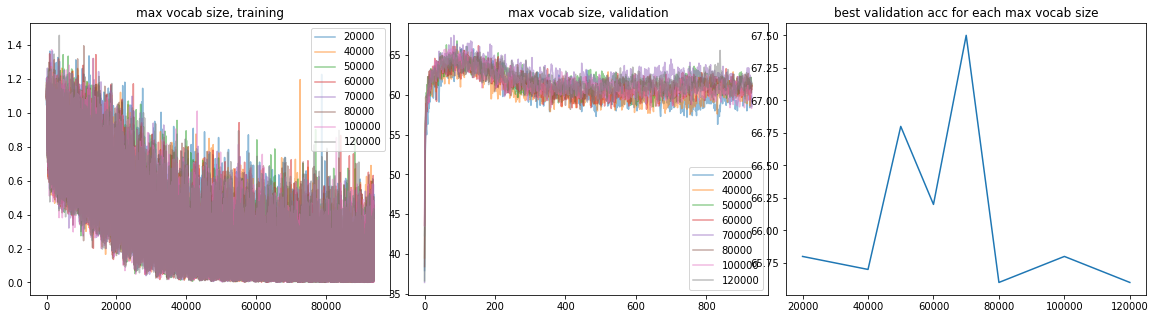

(70000, 67.5)

In [10]:
loss_lists, val_acc_lists = dict(), dict()
for n in [20000,40000,50000,60000,70000,80000,100000,120000]:
    loss_lists[n] = unpickle_from_file('cnn_snli_fixed_kernel_size_maxvocab_{}_hid_256_batch_32_lr_0.0003_l2_0/loss.p'.format(n))
    val_acc_lists[n] = unpickle_from_file('cnn_snli_fixed_kernel_size_maxvocab_{}_hid_256_batch_32_lr_0.0003_l2_0/acc.p'.format(n))
best_hyperparam, best_val = plot_train_validation(loss_lists, val_acc_lists, "max vocab size")
best_hyperparam, best_val

In [8]:
# definitely a bug, probably mixing batch order
show_result('cnn_snli_fixed_kernel_size_maxvocab_60000_hid_256_batch_32_lr_0.0003_l2_0/epoch_4_step_3000.p', 256, 60000, model_type="cnn")

val acc: 66.2
fiction test acc: 42.41206030150754
telephone test acc: 43.38308457711443
slate test acc: 43.31337325349301
government test acc: 41.43700787401575
travel test acc: 47.45417515274949


In [34]:
show_result('cnn_snli_fixed_kernel_size_maxvocab_70000_hid_256_batch_32_lr_0.0003_l2_0/epoch_2_step_2200.p', 256, 70000, model_type="cnn")

val acc: 67.5
fiction test acc: 44.221105527638194
telephone test acc: 46.46766169154229
slate test acc: 42.21556886227545
government test acc: 43.7007874015748
travel test acc: 45.824847250509166


In [41]:
train("all_kernel_size_fixed", 256, 70000, batch_size=32, num_epochs=15, kernel_size=1, model_type="cnn")

fixed, three objects will be saved in three separate files
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_0/epoch_0_step_100.p
Epoch: [1/15], Step: [101/3125], Validation Acc: 34.3
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_0/epoch_0_step_200.p
Epoch: [1/15], Step: [201/3125], Validation Acc: 48.6
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_0/epoch_0_step_300.p
Epoch: [1/15], Step: [301/3125], Validation Acc: 54.0
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_0/epoch_0_step_400.p
Epoch: [1/15], Step: [401/3125], Validation Acc: 56.8
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_0/epoch_0_step_500.p
Epoch: [1/15], Step: [501/3125], Validation Acc: 58.5
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_0/epoch_0_step_600.p

Epoch: [4/15], Step: [601/3125], Validation Acc: 66.7
Epoch: [4/15], Step: [701/3125], Validation Acc: 66.1
Epoch: [4/15], Step: [801/3125], Validation Acc: 66.5
Epoch: [4/15], Step: [901/3125], Validation Acc: 66.5
Epoch: [4/15], Step: [1001/3125], Validation Acc: 65.8
Epoch: [4/15], Step: [1101/3125], Validation Acc: 67.0
Epoch: [4/15], Step: [1201/3125], Validation Acc: 66.4
Epoch: [4/15], Step: [1301/3125], Validation Acc: 63.8
Epoch: [4/15], Step: [1401/3125], Validation Acc: 66.7
Epoch: [4/15], Step: [1501/3125], Validation Acc: 65.6
Epoch: [4/15], Step: [1601/3125], Validation Acc: 65.8
Epoch: [4/15], Step: [1701/3125], Validation Acc: 65.6
Epoch: [4/15], Step: [1801/3125], Validation Acc: 66.1
Epoch: [4/15], Step: [1901/3125], Validation Acc: 66.4
Epoch: [4/15], Step: [2001/3125], Validation Acc: 66.1
Epoch: [4/15], Step: [2101/3125], Validation Acc: 66.7
Epoch: [4/15], Step: [2201/3125], Validation Acc: 66.1
Epoch: [4/15], Step: [2301/3125], Validation Acc: 65.3
Epoch: [4/15],

Epoch: [8/15], Step: [2401/3125], Validation Acc: 64.8
Epoch: [8/15], Step: [2501/3125], Validation Acc: 66.5
Epoch: [8/15], Step: [2601/3125], Validation Acc: 66.8
Epoch: [8/15], Step: [2701/3125], Validation Acc: 65.8
Epoch: [8/15], Step: [2801/3125], Validation Acc: 66.8
Epoch: [8/15], Step: [2901/3125], Validation Acc: 65.0
Epoch: [8/15], Step: [3001/3125], Validation Acc: 64.7
Epoch: [8/15], Step: [3101/3125], Validation Acc: 66.3
Epoch: [8/15], Validation Acc: 66.3, train mean loss: 0.6849894551849365, val mean loss: 0.9121496845036745
Epoch: [9/15], Step: [101/3125], Validation Acc: 65.1
Epoch: [9/15], Step: [201/3125], Validation Acc: 65.2
Epoch: [9/15], Step: [301/3125], Validation Acc: 65.5
Epoch: [9/15], Step: [401/3125], Validation Acc: 65.1
Epoch: [9/15], Step: [501/3125], Validation Acc: 64.1
Epoch: [9/15], Step: [601/3125], Validation Acc: 64.7
Epoch: [9/15], Step: [701/3125], Validation Acc: 66.2
Epoch: [9/15], Step: [801/3125], Validation Acc: 63.6
Epoch: [9/15], Step:

Epoch: [13/15], Step: [801/3125], Validation Acc: 64.0
Epoch: [13/15], Step: [901/3125], Validation Acc: 65.3
Epoch: [13/15], Step: [1001/3125], Validation Acc: 63.6
Epoch: [13/15], Step: [1101/3125], Validation Acc: 64.5
Epoch: [13/15], Step: [1201/3125], Validation Acc: 64.3
Epoch: [13/15], Step: [1301/3125], Validation Acc: 64.5
Epoch: [13/15], Step: [1401/3125], Validation Acc: 64.0
Epoch: [13/15], Step: [1501/3125], Validation Acc: 64.8
Epoch: [13/15], Step: [1601/3125], Validation Acc: 65.5
Epoch: [13/15], Step: [1701/3125], Validation Acc: 65.0
Epoch: [13/15], Step: [1801/3125], Validation Acc: 63.7
Epoch: [13/15], Step: [1901/3125], Validation Acc: 64.9
Epoch: [13/15], Step: [2001/3125], Validation Acc: 65.3
Epoch: [13/15], Step: [2101/3125], Validation Acc: 63.9
Epoch: [13/15], Step: [2201/3125], Validation Acc: 65.5
Epoch: [13/15], Step: [2301/3125], Validation Acc: 64.2
Epoch: [13/15], Step: [2401/3125], Validation Acc: 63.7
Epoch: [13/15], Step: [2501/3125], Validation Acc:

In [40]:
for kernel_size in [3,5,7,9,11]:
    train("all_kernel_size_fixed", 256, 70000, batch_size=32, num_epochs=15, kernel_size=kernel_size, model_type="cnn")

fixed, three objects will be saved in three separate files
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_256_batch_32_kernel_3_lr_0.0003_l2_0/epoch_0_step_100.p
Epoch: [1/15], Step: [101/3125], Validation Acc: 43.5
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_256_batch_32_kernel_3_lr_0.0003_l2_0/epoch_0_step_200.p
Epoch: [1/15], Step: [201/3125], Validation Acc: 50.3
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_256_batch_32_kernel_3_lr_0.0003_l2_0/epoch_0_step_300.p
Epoch: [1/15], Step: [301/3125], Validation Acc: 55.9
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_256_batch_32_kernel_3_lr_0.0003_l2_0/epoch_0_step_400.p
Epoch: [1/15], Step: [401/3125], Validation Acc: 56.5
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_256_batch_32_kernel_3_lr_0.0003_l2_0/epoch_0_step_500.p
Epoch: [1/15], Step: [501/3125], Validation Acc: 58.8
Epoch: [1/15], Step: [601/3125], Validation Acc: 58.2
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_2

Epoch: [4/15], Step: [1801/3125], Validation Acc: 65.1
Epoch: [4/15], Step: [1901/3125], Validation Acc: 64.4
Epoch: [4/15], Step: [2001/3125], Validation Acc: 62.7
Epoch: [4/15], Step: [2101/3125], Validation Acc: 63.9
Epoch: [4/15], Step: [2201/3125], Validation Acc: 63.7
Epoch: [4/15], Step: [2301/3125], Validation Acc: 64.3
Epoch: [4/15], Step: [2401/3125], Validation Acc: 65.0
Epoch: [4/15], Step: [2501/3125], Validation Acc: 63.5
Epoch: [4/15], Step: [2601/3125], Validation Acc: 63.8
Epoch: [4/15], Step: [2701/3125], Validation Acc: 64.7
Epoch: [4/15], Step: [2801/3125], Validation Acc: 63.4
Epoch: [4/15], Step: [2901/3125], Validation Acc: 65.0
Epoch: [4/15], Step: [3001/3125], Validation Acc: 63.2
Epoch: [4/15], Step: [3101/3125], Validation Acc: 63.6
Epoch: [4/15], Validation Acc: 62.5, train mean loss: 0.6759200822353363, val mean loss: 0.9230386819690466
Epoch: [5/15], Step: [101/3125], Validation Acc: 63.8
Epoch: [5/15], Step: [201/3125], Validation Acc: 63.5
Epoch: [5/15],

Epoch: [9/15], Step: [301/3125], Validation Acc: 62.5
Epoch: [9/15], Step: [401/3125], Validation Acc: 62.7
Epoch: [9/15], Step: [501/3125], Validation Acc: 61.7
Epoch: [9/15], Step: [601/3125], Validation Acc: 61.4
Epoch: [9/15], Step: [701/3125], Validation Acc: 60.9
Epoch: [9/15], Step: [801/3125], Validation Acc: 60.6
Epoch: [9/15], Step: [901/3125], Validation Acc: 61.4
Epoch: [9/15], Step: [1001/3125], Validation Acc: 61.2
Epoch: [9/15], Step: [1101/3125], Validation Acc: 61.0
Epoch: [9/15], Step: [1201/3125], Validation Acc: 60.7
Epoch: [9/15], Step: [1301/3125], Validation Acc: 60.9
Epoch: [9/15], Step: [1401/3125], Validation Acc: 64.0
Epoch: [9/15], Step: [1501/3125], Validation Acc: 61.9
Epoch: [9/15], Step: [1601/3125], Validation Acc: 61.6
Epoch: [9/15], Step: [1701/3125], Validation Acc: 63.4
Epoch: [9/15], Step: [1801/3125], Validation Acc: 61.6
Epoch: [9/15], Step: [1901/3125], Validation Acc: 61.5
Epoch: [9/15], Step: [2001/3125], Validation Acc: 62.7
Epoch: [9/15], St

Epoch: [13/15], Step: [1901/3125], Validation Acc: 60.6
Epoch: [13/15], Step: [2001/3125], Validation Acc: 63.1
Epoch: [13/15], Step: [2101/3125], Validation Acc: 60.7
Epoch: [13/15], Step: [2201/3125], Validation Acc: 61.4
Epoch: [13/15], Step: [2301/3125], Validation Acc: 60.5
Epoch: [13/15], Step: [2401/3125], Validation Acc: 60.5
Epoch: [13/15], Step: [2501/3125], Validation Acc: 61.7
Epoch: [13/15], Step: [2601/3125], Validation Acc: 60.7
Epoch: [13/15], Step: [2701/3125], Validation Acc: 61.2
Epoch: [13/15], Step: [2801/3125], Validation Acc: 61.7
Epoch: [13/15], Step: [2901/3125], Validation Acc: 60.0
Epoch: [13/15], Step: [3001/3125], Validation Acc: 61.4
Epoch: [13/15], Step: [3101/3125], Validation Acc: 60.8
Epoch: [13/15], Validation Acc: 61.1, train mean loss: 0.21454696704626083, val mean loss: 0.9229888264089823
Epoch: [14/15], Step: [101/3125], Validation Acc: 62.0
Epoch: [14/15], Step: [201/3125], Validation Acc: 62.2
Epoch: [14/15], Step: [301/3125], Validation Acc: 61

Epoch: [2/15], Step: [601/3125], Validation Acc: 63.5
Epoch: [2/15], Step: [701/3125], Validation Acc: 63.2
Epoch: [2/15], Step: [801/3125], Validation Acc: 63.4
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_256_batch_32_kernel_5_lr_0.0003_l2_0/epoch_1_step_900.p
Epoch: [2/15], Step: [901/3125], Validation Acc: 64.6
Epoch: [2/15], Step: [1001/3125], Validation Acc: 62.9
Epoch: [2/15], Step: [1101/3125], Validation Acc: 64.3
Epoch: [2/15], Step: [1201/3125], Validation Acc: 62.0
Epoch: [2/15], Step: [1301/3125], Validation Acc: 62.4
Epoch: [2/15], Step: [1401/3125], Validation Acc: 62.8
Epoch: [2/15], Step: [1501/3125], Validation Acc: 62.5
Epoch: [2/15], Step: [1601/3125], Validation Acc: 64.0
Epoch: [2/15], Step: [1701/3125], Validation Acc: 62.8
Epoch: [2/15], Step: [1801/3125], Validation Acc: 63.9
Epoch: [2/15], Step: [1901/3125], Validation Acc: 64.2
Epoch: [2/15], Step: [2001/3125], Validation Acc: 64.1
Epoch: [2/15], Step: [2101/3125], Validation Acc: 64.4
Epoch: [2/15

Epoch: [6/15], Step: [2001/3125], Validation Acc: 60.8
Epoch: [6/15], Step: [2101/3125], Validation Acc: 62.2
Epoch: [6/15], Step: [2201/3125], Validation Acc: 62.3
Epoch: [6/15], Step: [2301/3125], Validation Acc: 62.8
Epoch: [6/15], Step: [2401/3125], Validation Acc: 61.6
Epoch: [6/15], Step: [2501/3125], Validation Acc: 61.5
Epoch: [6/15], Step: [2601/3125], Validation Acc: 61.7
Epoch: [6/15], Step: [2701/3125], Validation Acc: 62.7
Epoch: [6/15], Step: [2801/3125], Validation Acc: 63.5
Epoch: [6/15], Step: [2901/3125], Validation Acc: 64.9
Epoch: [6/15], Step: [3001/3125], Validation Acc: 64.8
Epoch: [6/15], Step: [3101/3125], Validation Acc: 62.7
Epoch: [6/15], Validation Acc: 62.9, train mean loss: 0.49308449446201325, val mean loss: 0.9178164564073086
Epoch: [7/15], Step: [101/3125], Validation Acc: 62.2
Epoch: [7/15], Step: [201/3125], Validation Acc: 63.3
Epoch: [7/15], Step: [301/3125], Validation Acc: 63.0
Epoch: [7/15], Step: [401/3125], Validation Acc: 62.6
Epoch: [7/15], 

Epoch: [11/15], Step: [501/3125], Validation Acc: 60.4
Epoch: [11/15], Step: [601/3125], Validation Acc: 60.6
Epoch: [11/15], Step: [701/3125], Validation Acc: 60.7
Epoch: [11/15], Step: [801/3125], Validation Acc: 59.4
Epoch: [11/15], Step: [901/3125], Validation Acc: 60.4
Epoch: [11/15], Step: [1001/3125], Validation Acc: 61.6
Epoch: [11/15], Step: [1101/3125], Validation Acc: 59.6
Epoch: [11/15], Step: [1201/3125], Validation Acc: 60.7
Epoch: [11/15], Step: [1301/3125], Validation Acc: 61.1
Epoch: [11/15], Step: [1401/3125], Validation Acc: 59.8
Epoch: [11/15], Step: [1501/3125], Validation Acc: 61.9
Epoch: [11/15], Step: [1601/3125], Validation Acc: 61.2
Epoch: [11/15], Step: [1701/3125], Validation Acc: 60.2
Epoch: [11/15], Step: [1801/3125], Validation Acc: 60.6
Epoch: [11/15], Step: [1901/3125], Validation Acc: 59.4
Epoch: [11/15], Step: [2001/3125], Validation Acc: 61.0
Epoch: [11/15], Step: [2101/3125], Validation Acc: 60.5
Epoch: [11/15], Step: [2201/3125], Validation Acc: 61

Epoch: [15/15], Step: [2101/3125], Validation Acc: 61.6
Epoch: [15/15], Step: [2201/3125], Validation Acc: 61.9
Epoch: [15/15], Step: [2301/3125], Validation Acc: 59.8
Epoch: [15/15], Step: [2401/3125], Validation Acc: 61.8
Epoch: [15/15], Step: [2501/3125], Validation Acc: 62.1
Epoch: [15/15], Step: [2601/3125], Validation Acc: 60.9
Epoch: [15/15], Step: [2701/3125], Validation Acc: 61.5
Epoch: [15/15], Step: [2801/3125], Validation Acc: 61.4
Epoch: [15/15], Step: [2901/3125], Validation Acc: 60.5
Epoch: [15/15], Step: [3001/3125], Validation Acc: 60.3
Epoch: [15/15], Step: [3101/3125], Validation Acc: 61.8
Epoch: [15/15], Validation Acc: 61.2, train mean loss: 0.12312730558633804, val mean loss: 0.9246505368500948
fixed, three objects will be saved in three separate files
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_256_batch_32_kernel_7_lr_0.0003_l2_0/epoch_0_step_100.p
Epoch: [1/15], Step: [101/3125], Validation Acc: 47.3
saved cnn_snli_all_kernel_size_fixed_maxvocab_700

Epoch: [3/15], Step: [3001/3125], Validation Acc: 63.1
Epoch: [3/15], Step: [3101/3125], Validation Acc: 64.0
Epoch: [3/15], Validation Acc: 62.5, train mean loss: 0.7465121046066284, val mean loss: 0.9305700212717056
Epoch: [4/15], Step: [101/3125], Validation Acc: 63.8
Epoch: [4/15], Step: [201/3125], Validation Acc: 62.4
Epoch: [4/15], Step: [301/3125], Validation Acc: 63.0
Epoch: [4/15], Step: [401/3125], Validation Acc: 62.5
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_256_batch_32_kernel_7_lr_0.0003_l2_0/epoch_3_step_500.p
Epoch: [4/15], Step: [501/3125], Validation Acc: 64.4
Epoch: [4/15], Step: [601/3125], Validation Acc: 62.5
Epoch: [4/15], Step: [701/3125], Validation Acc: 64.0
Epoch: [4/15], Step: [801/3125], Validation Acc: 63.4
Epoch: [4/15], Step: [901/3125], Validation Acc: 61.7
Epoch: [4/15], Step: [1001/3125], Validation Acc: 62.0
Epoch: [4/15], Step: [1101/3125], Validation Acc: 62.6
Epoch: [4/15], Step: [1201/3125], Validation Acc: 62.9
Epoch: [4/15], Step

Epoch: [8/15], Step: [1101/3125], Validation Acc: 60.1
Epoch: [8/15], Step: [1201/3125], Validation Acc: 60.0
Epoch: [8/15], Step: [1301/3125], Validation Acc: 59.6
Epoch: [8/15], Step: [1401/3125], Validation Acc: 62.1
Epoch: [8/15], Step: [1501/3125], Validation Acc: 60.2
Epoch: [8/15], Step: [1601/3125], Validation Acc: 59.9
Epoch: [8/15], Step: [1701/3125], Validation Acc: 59.7
Epoch: [8/15], Step: [1801/3125], Validation Acc: 59.1
Epoch: [8/15], Step: [1901/3125], Validation Acc: 58.9
Epoch: [8/15], Step: [2001/3125], Validation Acc: 60.2
Epoch: [8/15], Step: [2101/3125], Validation Acc: 60.6
Epoch: [8/15], Step: [2201/3125], Validation Acc: 60.2
Epoch: [8/15], Step: [2301/3125], Validation Acc: 61.4
Epoch: [8/15], Step: [2401/3125], Validation Acc: 61.0
Epoch: [8/15], Step: [2501/3125], Validation Acc: 60.4
Epoch: [8/15], Step: [2601/3125], Validation Acc: 59.8
Epoch: [8/15], Step: [2701/3125], Validation Acc: 59.5
Epoch: [8/15], Step: [2801/3125], Validation Acc: 59.9
Epoch: [8/

Epoch: [12/15], Step: [2801/3125], Validation Acc: 60.4
Epoch: [12/15], Step: [2901/3125], Validation Acc: 60.8
Epoch: [12/15], Step: [3001/3125], Validation Acc: 61.3
Epoch: [12/15], Step: [3101/3125], Validation Acc: 61.7
Epoch: [12/15], Validation Acc: 59.4, train mean loss: 0.14958050327837466, val mean loss: 0.9339310396462679
Epoch: [13/15], Step: [101/3125], Validation Acc: 60.8
Epoch: [13/15], Step: [201/3125], Validation Acc: 61.3
Epoch: [13/15], Step: [301/3125], Validation Acc: 60.3
Epoch: [13/15], Step: [401/3125], Validation Acc: 60.7
Epoch: [13/15], Step: [501/3125], Validation Acc: 59.7
Epoch: [13/15], Step: [601/3125], Validation Acc: 60.2
Epoch: [13/15], Step: [701/3125], Validation Acc: 61.4
Epoch: [13/15], Step: [801/3125], Validation Acc: 61.9
Epoch: [13/15], Step: [901/3125], Validation Acc: 62.0
Epoch: [13/15], Step: [1001/3125], Validation Acc: 60.1
Epoch: [13/15], Step: [1101/3125], Validation Acc: 61.6
Epoch: [13/15], Step: [1201/3125], Validation Acc: 60.4
Epo

Epoch: [1/15], Step: [2501/3125], Validation Acc: 58.8
Epoch: [1/15], Step: [2601/3125], Validation Acc: 59.1
Epoch: [1/15], Step: [2701/3125], Validation Acc: 58.4
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_256_batch_32_kernel_9_lr_0.0003_l2_0/epoch_0_step_2800.p
Epoch: [1/15], Step: [2801/3125], Validation Acc: 60.2
Epoch: [1/15], Step: [2901/3125], Validation Acc: 59.8
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_256_batch_32_kernel_9_lr_0.0003_l2_0/epoch_0_step_3000.p
Epoch: [1/15], Step: [3001/3125], Validation Acc: 61.6
Epoch: [1/15], Step: [3101/3125], Validation Acc: 61.5
Epoch: [1/15], Validation Acc: 60.9, train mean loss: 0.9031904235267639, val mean loss: 0.9649991970509291
Epoch: [2/15], Step: [101/3125], Validation Acc: 60.3
Epoch: [2/15], Step: [201/3125], Validation Acc: 59.4
Epoch: [2/15], Step: [301/3125], Validation Acc: 58.7
Epoch: [2/15], Step: [401/3125], Validation Acc: 60.8
Epoch: [2/15], Step: [501/3125], Validation Acc: 60.1
Epoch: [2/1

Epoch: [5/15], Step: [2901/3125], Validation Acc: 62.7
Epoch: [5/15], Step: [3001/3125], Validation Acc: 60.9
Epoch: [5/15], Step: [3101/3125], Validation Acc: 61.5
Epoch: [5/15], Validation Acc: 61.6, train mean loss: 0.6157295101451874, val mean loss: 0.9358152318745852
Epoch: [6/15], Step: [101/3125], Validation Acc: 60.8
Epoch: [6/15], Step: [201/3125], Validation Acc: 61.7
Epoch: [6/15], Step: [301/3125], Validation Acc: 61.3
Epoch: [6/15], Step: [401/3125], Validation Acc: 60.6
Epoch: [6/15], Step: [501/3125], Validation Acc: 60.2
Epoch: [6/15], Step: [601/3125], Validation Acc: 60.5
Epoch: [6/15], Step: [701/3125], Validation Acc: 62.2
Epoch: [6/15], Step: [801/3125], Validation Acc: 59.8
Epoch: [6/15], Step: [901/3125], Validation Acc: 60.7
Epoch: [6/15], Step: [1001/3125], Validation Acc: 60.6
Epoch: [6/15], Step: [1101/3125], Validation Acc: 61.1
Epoch: [6/15], Step: [1201/3125], Validation Acc: 60.4
Epoch: [6/15], Step: [1301/3125], Validation Acc: 59.6
Epoch: [6/15], Step: 

Epoch: [10/15], Step: [1401/3125], Validation Acc: 59.4
Epoch: [10/15], Step: [1501/3125], Validation Acc: 58.8
Epoch: [10/15], Step: [1601/3125], Validation Acc: 59.6
Epoch: [10/15], Step: [1701/3125], Validation Acc: 59.9
Epoch: [10/15], Step: [1801/3125], Validation Acc: 59.5
Epoch: [10/15], Step: [1901/3125], Validation Acc: 59.8
Epoch: [10/15], Step: [2001/3125], Validation Acc: 60.5
Epoch: [10/15], Step: [2101/3125], Validation Acc: 60.6
Epoch: [10/15], Step: [2201/3125], Validation Acc: 59.1
Epoch: [10/15], Step: [2301/3125], Validation Acc: 59.7
Epoch: [10/15], Step: [2401/3125], Validation Acc: 60.8
Epoch: [10/15], Step: [2501/3125], Validation Acc: 58.8
Epoch: [10/15], Step: [2601/3125], Validation Acc: 60.3
Epoch: [10/15], Step: [2701/3125], Validation Acc: 58.2
Epoch: [10/15], Step: [2801/3125], Validation Acc: 58.9
Epoch: [10/15], Step: [2901/3125], Validation Acc: 59.1
Epoch: [10/15], Step: [3001/3125], Validation Acc: 59.4
Epoch: [10/15], Step: [3101/3125], Validation Ac

Epoch: [14/15], Step: [3001/3125], Validation Acc: 59.1
Epoch: [14/15], Step: [3101/3125], Validation Acc: 59.4
Epoch: [14/15], Validation Acc: 59.8, train mean loss: 0.13399423509836197, val mean loss: 0.9382642321288586
Epoch: [15/15], Step: [101/3125], Validation Acc: 59.4
Epoch: [15/15], Step: [201/3125], Validation Acc: 59.3
Epoch: [15/15], Step: [301/3125], Validation Acc: 58.6
Epoch: [15/15], Step: [401/3125], Validation Acc: 58.8
Epoch: [15/15], Step: [501/3125], Validation Acc: 60.0
Epoch: [15/15], Step: [601/3125], Validation Acc: 58.8
Epoch: [15/15], Step: [701/3125], Validation Acc: 59.0
Epoch: [15/15], Step: [801/3125], Validation Acc: 59.5
Epoch: [15/15], Step: [901/3125], Validation Acc: 58.8
Epoch: [15/15], Step: [1001/3125], Validation Acc: 58.9
Epoch: [15/15], Step: [1101/3125], Validation Acc: 59.5
Epoch: [15/15], Step: [1201/3125], Validation Acc: 58.1
Epoch: [15/15], Step: [1301/3125], Validation Acc: 59.8
Epoch: [15/15], Step: [1401/3125], Validation Acc: 59.4
Epo

saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_256_batch_32_kernel_11_lr_0.0003_l2_0/epoch_2_step_500.p
Epoch: [3/15], Step: [501/3125], Validation Acc: 62.7
Epoch: [3/15], Step: [601/3125], Validation Acc: 61.1
Epoch: [3/15], Step: [701/3125], Validation Acc: 61.5
Epoch: [3/15], Step: [801/3125], Validation Acc: 61.4
Epoch: [3/15], Step: [901/3125], Validation Acc: 61.7
Epoch: [3/15], Step: [1001/3125], Validation Acc: 61.8
Epoch: [3/15], Step: [1101/3125], Validation Acc: 61.9
Epoch: [3/15], Step: [1201/3125], Validation Acc: 60.8
Epoch: [3/15], Step: [1301/3125], Validation Acc: 62.3
Epoch: [3/15], Step: [1401/3125], Validation Acc: 61.8
Epoch: [3/15], Step: [1501/3125], Validation Acc: 60.0
Epoch: [3/15], Step: [1601/3125], Validation Acc: 60.5
Epoch: [3/15], Step: [1701/3125], Validation Acc: 61.3
Epoch: [3/15], Step: [1801/3125], Validation Acc: 61.6
Epoch: [3/15], Step: [1901/3125], Validation Acc: 60.8
Epoch: [3/15], Step: [2001/3125], Validation Acc: 61.6
Epoch: [3/15

Epoch: [7/15], Step: [1901/3125], Validation Acc: 59.8
Epoch: [7/15], Step: [2001/3125], Validation Acc: 59.6
Epoch: [7/15], Step: [2101/3125], Validation Acc: 59.6
Epoch: [7/15], Step: [2201/3125], Validation Acc: 60.3
Epoch: [7/15], Step: [2301/3125], Validation Acc: 58.8
Epoch: [7/15], Step: [2401/3125], Validation Acc: 60.5
Epoch: [7/15], Step: [2501/3125], Validation Acc: 59.7
Epoch: [7/15], Step: [2601/3125], Validation Acc: 60.3
Epoch: [7/15], Step: [2701/3125], Validation Acc: 60.5
Epoch: [7/15], Step: [2801/3125], Validation Acc: 60.1
Epoch: [7/15], Step: [2901/3125], Validation Acc: 59.7
Epoch: [7/15], Step: [3001/3125], Validation Acc: 59.2
Epoch: [7/15], Step: [3101/3125], Validation Acc: 59.3
Epoch: [7/15], Validation Acc: 60.7, train mean loss: 0.4370334324169159, val mean loss: 0.9302510246634483
Epoch: [8/15], Step: [101/3125], Validation Acc: 59.9
Epoch: [8/15], Step: [201/3125], Validation Acc: 58.5
Epoch: [8/15], Step: [301/3125], Validation Acc: 58.9
Epoch: [8/15], 

Epoch: [12/15], Step: [301/3125], Validation Acc: 58.1
Epoch: [12/15], Step: [401/3125], Validation Acc: 58.9
Epoch: [12/15], Step: [501/3125], Validation Acc: 57.7
Epoch: [12/15], Step: [601/3125], Validation Acc: 57.4
Epoch: [12/15], Step: [701/3125], Validation Acc: 57.7
Epoch: [12/15], Step: [801/3125], Validation Acc: 57.6
Epoch: [12/15], Step: [901/3125], Validation Acc: 57.5
Epoch: [12/15], Step: [1001/3125], Validation Acc: 57.9
Epoch: [12/15], Step: [1101/3125], Validation Acc: 57.9
Epoch: [12/15], Step: [1201/3125], Validation Acc: 57.8
Epoch: [12/15], Step: [1301/3125], Validation Acc: 58.6
Epoch: [12/15], Step: [1401/3125], Validation Acc: 58.4
Epoch: [12/15], Step: [1501/3125], Validation Acc: 57.7
Epoch: [12/15], Step: [1601/3125], Validation Acc: 58.5
Epoch: [12/15], Step: [1701/3125], Validation Acc: 58.0
Epoch: [12/15], Step: [1801/3125], Validation Acc: 56.6
Epoch: [12/15], Step: [1901/3125], Validation Acc: 58.2
Epoch: [12/15], Step: [2001/3125], Validation Acc: 57.2

[1, 3, 5, 7, 9, 11] [68.1, 65.8, 66.0, 64.6, 63.6, 63.1]


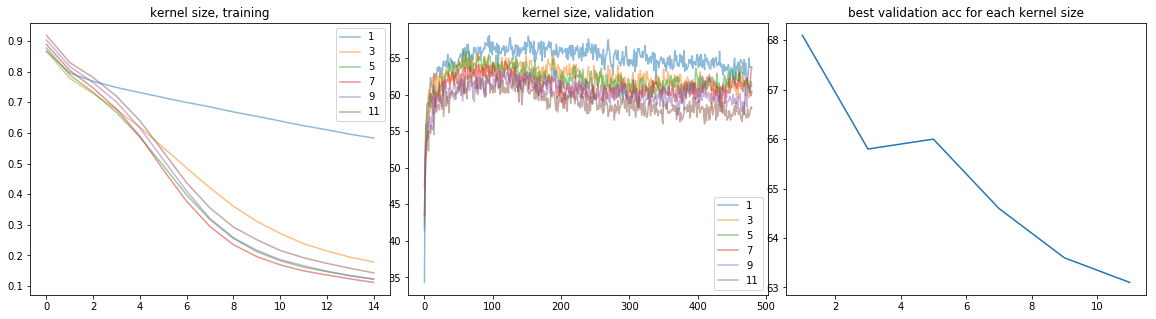

(1, 68.1)

In [42]:
loss_lists, val_acc_lists = dict(), dict()
for n in [1,3,5,7,9,11]:
    loss_lists[n] = unpickle_from_file('cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_256_batch_32_kernel_{}_lr_0.0003_l2_0/loss.p'.format(n))
    val_acc_lists[n] = unpickle_from_file('cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_256_batch_32_kernel_{}_lr_0.0003_l2_0/acc.p'.format(n))
best_hyperparam, best_val = plot_train_validation(loss_lists, val_acc_lists, "kernel size")
best_hyperparam, best_val

[1, 3, 5, 7, 9, 11] [68.1, 65.8, 66.0, 64.6, 63.6, 63.1]


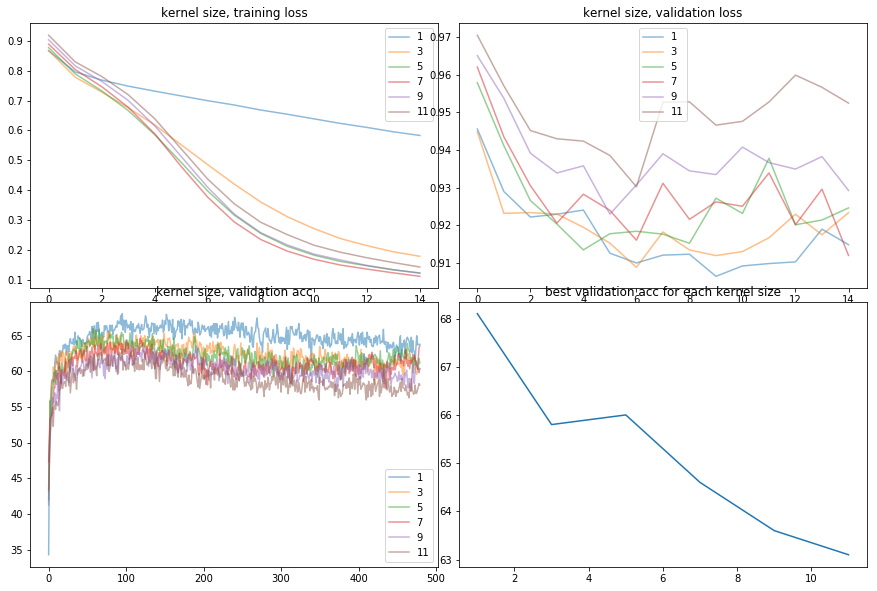

(1, 68.1)

In [48]:
### Better to align y axis for two loss graph

loss_lists, val_acc_lists, val_loss_lists = dict(), dict(), dict()
for n in [1,3,5,7,9,11]:
    loss_lists[n] = unpickle_from_file('cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_256_batch_32_kernel_{}_lr_0.0003_l2_0/loss.p'.format(n))
    val_acc_lists[n] = unpickle_from_file('cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_256_batch_32_kernel_{}_lr_0.0003_l2_0/acc.p'.format(n))
    val_loss_lists[n] = unpickle_from_file('cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_256_batch_32_kernel_{}_lr_0.0003_l2_0/val_loss.p'.format(n))
best_hyperparam, best_val = plot_train_validation_new(loss_lists, val_loss_lists, val_acc_lists, "kernel size")
best_hyperparam, best_val

In [60]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

for i in [1,3,5,7,9,11]:
    model = CNN(None, 
                emb_size=300, 
                hidden_size=256,
                num_layers=1,
                kernel_size=i,
                num_classes=3, 
                vocab_size=70000).cuda()
    total_params = 0
    for parameter in model.parameters():
        if parameter.requires_grad:
            print(parameter.shape, parameter.numel())
            total_params += parameter.numel()
    print("kernel size:", i, "total params", total_params)
    

torch.Size([70000, 300]) 21000000
torch.Size([256, 300, 1]) 76800
torch.Size([256]) 256
torch.Size([256, 256, 1]) 65536
torch.Size([256]) 256
torch.Size([256, 512]) 131072
torch.Size([256]) 256
torch.Size([3, 256]) 768
torch.Size([3]) 3
kernel size: 1 total params 21274947
torch.Size([70000, 300]) 21000000
torch.Size([256, 300, 3]) 230400
torch.Size([256]) 256
torch.Size([256, 256, 3]) 196608
torch.Size([256]) 256
torch.Size([256, 512]) 131072
torch.Size([256]) 256
torch.Size([3, 256]) 768
torch.Size([3]) 3
kernel size: 3 total params 21559619
torch.Size([70000, 300]) 21000000
torch.Size([256, 300, 5]) 384000
torch.Size([256]) 256
torch.Size([256, 256, 5]) 327680
torch.Size([256]) 256
torch.Size([256, 512]) 131072
torch.Size([256]) 256
torch.Size([3, 256]) 768
torch.Size([3]) 3
kernel size: 5 total params 21844291
torch.Size([70000, 300]) 21000000
torch.Size([256, 300, 7]) 537600
torch.Size([256]) 256
torch.Size([256, 256, 7]) 458752
torch.Size([256]) 256
torch.Size([256, 512]) 131072


In [61]:
for i in [1,2,4,8,16,32,64,128,512,1024]:
    model = CNN(None, 
                emb_size=300, 
                hidden_size=i,
                num_layers=1,
                kernel_size=1,
                num_classes=3, 
                vocab_size=70000).cuda()
    total_params = 0
    for parameter in model.parameters():
        if parameter.requires_grad:
            print(parameter.shape, parameter.numel())
            total_params += parameter.numel()
    print("kernel size:", i, "total params", total_params)

torch.Size([70000, 300]) 21000000
torch.Size([1, 300, 1]) 300
torch.Size([1]) 1
torch.Size([1, 1, 1]) 1
torch.Size([1]) 1
torch.Size([1, 2]) 2
torch.Size([1]) 1
torch.Size([3, 1]) 3
torch.Size([3]) 3
kernel size: 1 total params 21000312
torch.Size([70000, 300]) 21000000
torch.Size([2, 300, 1]) 600
torch.Size([2]) 2
torch.Size([2, 2, 1]) 4
torch.Size([2]) 2
torch.Size([2, 4]) 8
torch.Size([2]) 2
torch.Size([3, 2]) 6
torch.Size([3]) 3
kernel size: 2 total params 21000627
torch.Size([70000, 300]) 21000000
torch.Size([4, 300, 1]) 1200
torch.Size([4]) 4
torch.Size([4, 4, 1]) 16
torch.Size([4]) 4
torch.Size([4, 8]) 32
torch.Size([4]) 4
torch.Size([3, 4]) 12
torch.Size([3]) 3
kernel size: 4 total params 21001275
torch.Size([70000, 300]) 21000000
torch.Size([8, 300, 1]) 2400
torch.Size([8]) 8
torch.Size([8, 8, 1]) 64
torch.Size([8]) 8
torch.Size([8, 16]) 128
torch.Size([8]) 8
torch.Size([3, 8]) 24
torch.Size([3]) 3
kernel size: 8 total params 21002643
torch.Size([70000, 300]) 21000000
torch.Si

In [ ]:
for hidden_size in [2,4,8,16,32,64,128,512,1024]:
    train("all_kernel_size_fixed", hidden_size, 70000, batch_size=32, num_epochs=30, kernel_size=1, model_type="cnn")

fixed, three objects will be saved in three separate files
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_2_batch_32_kernel_1_lr_0.0003_l2_0/epoch_0_step_100.p
Epoch: [1/30], Step: [101/3125], Validation Acc: 33.1
Epoch: [1/30], Step: [201/3125], Validation Acc: 33.1
Epoch: [1/30], Step: [301/3125], Validation Acc: 33.1
Epoch: [1/30], Step: [401/3125], Validation Acc: 32.9
Epoch: [1/30], Step: [501/3125], Validation Acc: 33.0
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_2_batch_32_kernel_1_lr_0.0003_l2_0/epoch_0_step_600.p
Epoch: [1/30], Step: [601/3125], Validation Acc: 33.5
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_2_batch_32_kernel_1_lr_0.0003_l2_0/epoch_0_step_700.p
Epoch: [1/30], Step: [701/3125], Validation Acc: 34.5
Epoch: [1/30], Step: [801/3125], Validation Acc: 34.0
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_2_batch_32_kernel_1_lr_0.0003_l2_0/epoch_0_step_900.p
Epoch: [1/30], Step: [901/3125], Validation Acc: 34.7
saved cnn_snli_

Epoch: [4/30], Step: [2101/3125], Validation Acc: 36.8
Epoch: [4/30], Step: [2201/3125], Validation Acc: 37.6
Epoch: [4/30], Step: [2301/3125], Validation Acc: 37.6
Epoch: [4/30], Step: [2401/3125], Validation Acc: 38.0
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_2_batch_32_kernel_1_lr_0.0003_l2_0/epoch_3_step_2500.p
Epoch: [4/30], Step: [2501/3125], Validation Acc: 38.8
Epoch: [4/30], Step: [2601/3125], Validation Acc: 38.3
Epoch: [4/30], Step: [2701/3125], Validation Acc: 38.7
Epoch: [4/30], Step: [2801/3125], Validation Acc: 38.7
Epoch: [4/30], Step: [2901/3125], Validation Acc: 38.5
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_2_batch_32_kernel_1_lr_0.0003_l2_0/epoch_3_step_3000.p
Epoch: [4/30], Step: [3001/3125], Validation Acc: 39.2
Epoch: [4/30], Step: [3101/3125], Validation Acc: 38.3
Epoch: [4/30], Validation Acc: 38.7, train mean loss: 1.0727772409439087, val mean loss: 1.0857546739280224
Epoch: [5/30], Step: [101/3125], Validation Acc: 39.1
Epoch: [5/3

Epoch: [8/30], Step: [1701/3125], Validation Acc: 42.9
Epoch: [8/30], Step: [1801/3125], Validation Acc: 42.2
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_2_batch_32_kernel_1_lr_0.0003_l2_0/epoch_7_step_1900.p
Epoch: [8/30], Step: [1901/3125], Validation Acc: 43.4
Epoch: [8/30], Step: [2001/3125], Validation Acc: 41.2
Epoch: [8/30], Step: [2101/3125], Validation Acc: 42.8
Epoch: [8/30], Step: [2201/3125], Validation Acc: 41.9
Epoch: [8/30], Step: [2301/3125], Validation Acc: 43.3
Epoch: [8/30], Step: [2401/3125], Validation Acc: 40.6
Epoch: [8/30], Step: [2501/3125], Validation Acc: 42.7
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_2_batch_32_kernel_1_lr_0.0003_l2_0/epoch_7_step_2600.p
Epoch: [8/30], Step: [2601/3125], Validation Acc: 43.7
Epoch: [8/30], Step: [2701/3125], Validation Acc: 43.1
Epoch: [8/30], Step: [2801/3125], Validation Acc: 43.1
Epoch: [8/30], Step: [2901/3125], Validation Acc: 43.5
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_2_batch

Epoch: [12/30], Step: [2401/3125], Validation Acc: 43.4
Epoch: [12/30], Step: [2501/3125], Validation Acc: 42.8
Epoch: [12/30], Step: [2601/3125], Validation Acc: 43.8
Epoch: [12/30], Step: [2701/3125], Validation Acc: 43.9
Epoch: [12/30], Step: [2801/3125], Validation Acc: 44.1
Epoch: [12/30], Step: [2901/3125], Validation Acc: 43.7
Epoch: [12/30], Step: [3001/3125], Validation Acc: 44.4
Epoch: [12/30], Step: [3101/3125], Validation Acc: 43.4
Epoch: [12/30], Validation Acc: 42.8, train mean loss: 1.0509782305717468, val mean loss: 1.0737657696008682
Epoch: [13/30], Step: [101/3125], Validation Acc: 43.6
Epoch: [13/30], Step: [201/3125], Validation Acc: 43.2
Epoch: [13/30], Step: [301/3125], Validation Acc: 43.1
Epoch: [13/30], Step: [401/3125], Validation Acc: 43.2
Epoch: [13/30], Step: [501/3125], Validation Acc: 43.3
Epoch: [13/30], Step: [601/3125], Validation Acc: 43.2
Epoch: [13/30], Step: [701/3125], Validation Acc: 43.0
Epoch: [13/30], Step: [801/3125], Validation Acc: 44.0
Epo

Epoch: [17/30], Step: [501/3125], Validation Acc: 44.0
Epoch: [17/30], Step: [601/3125], Validation Acc: 43.5
Epoch: [17/30], Step: [701/3125], Validation Acc: 43.3
Epoch: [17/30], Step: [801/3125], Validation Acc: 44.8
Epoch: [17/30], Step: [901/3125], Validation Acc: 44.2
Epoch: [17/30], Step: [1001/3125], Validation Acc: 44.0
Epoch: [17/30], Step: [1101/3125], Validation Acc: 44.4
Epoch: [17/30], Step: [1201/3125], Validation Acc: 43.7
Epoch: [17/30], Step: [1301/3125], Validation Acc: 44.3
Epoch: [17/30], Step: [1401/3125], Validation Acc: 44.4
Epoch: [17/30], Step: [1501/3125], Validation Acc: 44.1
Epoch: [17/30], Step: [1601/3125], Validation Acc: 44.2
Epoch: [17/30], Step: [1701/3125], Validation Acc: 43.2
Epoch: [17/30], Step: [1801/3125], Validation Acc: 44.1
Epoch: [17/30], Step: [1901/3125], Validation Acc: 44.2
Epoch: [17/30], Step: [2001/3125], Validation Acc: 44.8
Epoch: [17/30], Step: [2101/3125], Validation Acc: 44.2
Epoch: [17/30], Step: [2201/3125], Validation Acc: 44

Epoch: [21/30], Step: [1501/3125], Validation Acc: 44.5
Epoch: [21/30], Step: [1601/3125], Validation Acc: 44.9
Epoch: [21/30], Step: [1701/3125], Validation Acc: 44.9
Epoch: [21/30], Step: [1801/3125], Validation Acc: 45.0
Epoch: [21/30], Step: [1901/3125], Validation Acc: 45.2
Epoch: [21/30], Step: [2001/3125], Validation Acc: 45.0
Epoch: [21/30], Step: [2101/3125], Validation Acc: 44.8
Epoch: [21/30], Step: [2201/3125], Validation Acc: 45.1
Epoch: [21/30], Step: [2301/3125], Validation Acc: 44.2
Epoch: [21/30], Step: [2401/3125], Validation Acc: 44.8
Epoch: [21/30], Step: [2501/3125], Validation Acc: 44.8
Epoch: [21/30], Step: [2601/3125], Validation Acc: 44.5
Epoch: [21/30], Step: [2701/3125], Validation Acc: 45.0
Epoch: [21/30], Step: [2801/3125], Validation Acc: 44.4
Epoch: [21/30], Step: [2901/3125], Validation Acc: 44.0
Epoch: [21/30], Step: [3001/3125], Validation Acc: 43.9
Epoch: [21/30], Step: [3101/3125], Validation Acc: 44.1
Epoch: [21/30], Validation Acc: 44.6, train mean

Epoch: [25/30], Step: [3101/3125], Validation Acc: 44.5
Epoch: [25/30], Validation Acc: 44.2, train mean loss: 1.0452772950935363, val mean loss: 1.0688839480280876
Epoch: [26/30], Step: [101/3125], Validation Acc: 43.8
Epoch: [26/30], Step: [201/3125], Validation Acc: 44.3
Epoch: [26/30], Step: [301/3125], Validation Acc: 44.0
Epoch: [26/30], Step: [401/3125], Validation Acc: 44.2
Epoch: [26/30], Step: [501/3125], Validation Acc: 44.3
Epoch: [26/30], Step: [601/3125], Validation Acc: 43.9
Epoch: [26/30], Step: [701/3125], Validation Acc: 44.4
Epoch: [26/30], Step: [801/3125], Validation Acc: 44.1
Epoch: [26/30], Step: [901/3125], Validation Acc: 44.3
Epoch: [26/30], Step: [1001/3125], Validation Acc: 44.4
Epoch: [26/30], Step: [1101/3125], Validation Acc: 44.2
Epoch: [26/30], Step: [1201/3125], Validation Acc: 44.5
Epoch: [26/30], Step: [1301/3125], Validation Acc: 43.4
Epoch: [26/30], Step: [1401/3125], Validation Acc: 44.0
Epoch: [26/30], Step: [1501/3125], Validation Acc: 44.4
Epoc

Epoch: [30/30], Step: [1401/3125], Validation Acc: 44.2
Epoch: [30/30], Step: [1501/3125], Validation Acc: 44.2
Epoch: [30/30], Step: [1601/3125], Validation Acc: 44.6
Epoch: [30/30], Step: [1701/3125], Validation Acc: 44.2
Epoch: [30/30], Step: [1801/3125], Validation Acc: 44.7
Epoch: [30/30], Step: [1901/3125], Validation Acc: 44.7
Epoch: [30/30], Step: [2001/3125], Validation Acc: 44.5
Epoch: [30/30], Step: [2101/3125], Validation Acc: 44.4
Epoch: [30/30], Step: [2201/3125], Validation Acc: 44.2
Epoch: [30/30], Step: [2301/3125], Validation Acc: 44.1
Epoch: [30/30], Step: [2401/3125], Validation Acc: 44.1
Epoch: [30/30], Step: [2501/3125], Validation Acc: 43.6
Epoch: [30/30], Step: [2601/3125], Validation Acc: 44.7
Epoch: [30/30], Step: [2701/3125], Validation Acc: 44.6
Epoch: [30/30], Step: [2801/3125], Validation Acc: 44.1
Epoch: [30/30], Step: [2901/3125], Validation Acc: 43.8
Epoch: [30/30], Step: [3001/3125], Validation Acc: 44.2
Epoch: [30/30], Step: [3101/3125], Validation Ac

Epoch: [3/30], Step: [3001/3125], Validation Acc: 43.0
Epoch: [3/30], Step: [3101/3125], Validation Acc: 42.3
Epoch: [3/30], Validation Acc: 42.2, train mean loss: 1.0554612572669984, val mean loss: 1.0725911408662796
Epoch: [4/30], Step: [101/3125], Validation Acc: 43.7
Epoch: [4/30], Step: [201/3125], Validation Acc: 42.3
Epoch: [4/30], Step: [301/3125], Validation Acc: 42.6
Epoch: [4/30], Step: [401/3125], Validation Acc: 43.8
Epoch: [4/30], Step: [501/3125], Validation Acc: 41.9
Epoch: [4/30], Step: [601/3125], Validation Acc: 42.6
Epoch: [4/30], Step: [701/3125], Validation Acc: 43.6
Epoch: [4/30], Step: [801/3125], Validation Acc: 43.2
Epoch: [4/30], Step: [901/3125], Validation Acc: 44.2
Epoch: [4/30], Step: [1001/3125], Validation Acc: 43.5
Epoch: [4/30], Step: [1101/3125], Validation Acc: 43.7
Epoch: [4/30], Step: [1201/3125], Validation Acc: 43.1
Epoch: [4/30], Step: [1301/3125], Validation Acc: 43.0
Epoch: [4/30], Step: [1401/3125], Validation Acc: 43.3
Epoch: [4/30], Step: 

Epoch: [8/30], Step: [901/3125], Validation Acc: 44.4
Epoch: [8/30], Step: [1001/3125], Validation Acc: 44.8
Epoch: [8/30], Step: [1101/3125], Validation Acc: 44.2
Epoch: [8/30], Step: [1201/3125], Validation Acc: 45.3
Epoch: [8/30], Step: [1301/3125], Validation Acc: 43.9
Epoch: [8/30], Step: [1401/3125], Validation Acc: 45.7
Epoch: [8/30], Step: [1501/3125], Validation Acc: 45.1
Epoch: [8/30], Step: [1601/3125], Validation Acc: 44.8
Epoch: [8/30], Step: [1701/3125], Validation Acc: 44.8
Epoch: [8/30], Step: [1801/3125], Validation Acc: 44.6
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_4_batch_32_kernel_1_lr_0.0003_l2_0/epoch_7_step_1900.p
Epoch: [8/30], Step: [1901/3125], Validation Acc: 46.5
Epoch: [8/30], Step: [2001/3125], Validation Acc: 45.7
Epoch: [8/30], Step: [2101/3125], Validation Acc: 45.7
Epoch: [8/30], Step: [2201/3125], Validation Acc: 44.5
Epoch: [8/30], Step: [2301/3125], Validation Acc: 45.6
Epoch: [8/30], Step: [2401/3125], Validation Acc: 44.8
Epoch: [8/

Epoch: [12/30], Step: [2001/3125], Validation Acc: 44.9
Epoch: [12/30], Step: [2101/3125], Validation Acc: 45.5
Epoch: [12/30], Step: [2201/3125], Validation Acc: 45.2
Epoch: [12/30], Step: [2301/3125], Validation Acc: 44.1
Epoch: [12/30], Step: [2401/3125], Validation Acc: 46.0
Epoch: [12/30], Step: [2501/3125], Validation Acc: 45.3
Epoch: [12/30], Step: [2601/3125], Validation Acc: 45.6
Epoch: [12/30], Step: [2701/3125], Validation Acc: 45.0
Epoch: [12/30], Step: [2801/3125], Validation Acc: 43.4
Epoch: [12/30], Step: [2901/3125], Validation Acc: 45.0
Epoch: [12/30], Step: [3001/3125], Validation Acc: 45.6
Epoch: [12/30], Step: [3101/3125], Validation Acc: 45.5
Epoch: [12/30], Validation Acc: 45.6, train mean loss: 1.0453743830299378, val mean loss: 1.0663244277238846
Epoch: [13/30], Step: [101/3125], Validation Acc: 44.7
Epoch: [13/30], Step: [201/3125], Validation Acc: 46.1
Epoch: [13/30], Step: [301/3125], Validation Acc: 45.9
Epoch: [13/30], Step: [401/3125], Validation Acc: 45.2

Epoch: [16/30], Validation Acc: 46.3, train mean loss: 1.0428248901176453, val mean loss: 1.0669061243534088
Epoch: [17/30], Step: [101/3125], Validation Acc: 46.7
Epoch: [17/30], Step: [201/3125], Validation Acc: 46.6
Epoch: [17/30], Step: [301/3125], Validation Acc: 46.1
Epoch: [17/30], Step: [401/3125], Validation Acc: 46.7
Epoch: [17/30], Step: [501/3125], Validation Acc: 46.1
Epoch: [17/30], Step: [601/3125], Validation Acc: 47.1
Epoch: [17/30], Step: [701/3125], Validation Acc: 46.3
Epoch: [17/30], Step: [801/3125], Validation Acc: 45.9
Epoch: [17/30], Step: [901/3125], Validation Acc: 46.1
Epoch: [17/30], Step: [1001/3125], Validation Acc: 45.1
Epoch: [17/30], Step: [1101/3125], Validation Acc: 45.2
Epoch: [17/30], Step: [1201/3125], Validation Acc: 45.2
Epoch: [17/30], Step: [1301/3125], Validation Acc: 45.9
Epoch: [17/30], Step: [1401/3125], Validation Acc: 46.2
Epoch: [17/30], Step: [1501/3125], Validation Acc: 45.5
Epoch: [17/30], Step: [1601/3125], Validation Acc: 46.2
Epoc

Epoch: [20/30], Step: [3001/3125], Validation Acc: 49.2
Epoch: [20/30], Step: [3101/3125], Validation Acc: 48.8
Epoch: [20/30], Validation Acc: 48.7, train mean loss: 0.9945119293403626, val mean loss: 1.042263999581337
Epoch: [21/30], Step: [101/3125], Validation Acc: 49.1
Epoch: [21/30], Step: [201/3125], Validation Acc: 48.1
Epoch: [21/30], Step: [301/3125], Validation Acc: 48.8
Epoch: [21/30], Step: [401/3125], Validation Acc: 48.3
Epoch: [21/30], Step: [501/3125], Validation Acc: 48.5
Epoch: [21/30], Step: [601/3125], Validation Acc: 49.1
Epoch: [21/30], Step: [701/3125], Validation Acc: 49.6
Epoch: [21/30], Step: [801/3125], Validation Acc: 48.4
Epoch: [21/30], Step: [901/3125], Validation Acc: 48.4
Epoch: [21/30], Step: [1001/3125], Validation Acc: 48.5
Epoch: [21/30], Step: [1101/3125], Validation Acc: 49.3
Epoch: [21/30], Step: [1201/3125], Validation Acc: 49.3
Epoch: [21/30], Step: [1301/3125], Validation Acc: 49.0
Epoch: [21/30], Step: [1401/3125], Validation Acc: 49.8
Epoch

Epoch: [24/30], Step: [2901/3125], Validation Acc: 52.2
Epoch: [24/30], Step: [3001/3125], Validation Acc: 52.2
Epoch: [24/30], Step: [3101/3125], Validation Acc: 50.9
Epoch: [24/30], Validation Acc: 51.8, train mean loss: 0.9607189324569703, val mean loss: 1.0262198764830828
Epoch: [25/30], Step: [101/3125], Validation Acc: 52.6
Epoch: [25/30], Step: [201/3125], Validation Acc: 52.0
Epoch: [25/30], Step: [301/3125], Validation Acc: 51.8
Epoch: [25/30], Step: [401/3125], Validation Acc: 51.4
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_4_batch_32_kernel_1_lr_0.0003_l2_0/epoch_24_step_500.p
Epoch: [25/30], Step: [501/3125], Validation Acc: 53.0
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_4_batch_32_kernel_1_lr_0.0003_l2_0/epoch_24_step_600.p
Epoch: [25/30], Step: [601/3125], Validation Acc: 53.1
Epoch: [25/30], Step: [701/3125], Validation Acc: 51.9
Epoch: [25/30], Step: [801/3125], Validation Acc: 51.8
Epoch: [25/30], Step: [901/3125], Validation Acc: 53.0
Epoch:

Epoch: [28/30], Step: [1901/3125], Validation Acc: 55.6
Epoch: [28/30], Step: [2001/3125], Validation Acc: 56.2
Epoch: [28/30], Step: [2101/3125], Validation Acc: 56.1
Epoch: [28/30], Step: [2201/3125], Validation Acc: 55.6
Epoch: [28/30], Step: [2301/3125], Validation Acc: 55.8
Epoch: [28/30], Step: [2401/3125], Validation Acc: 55.6
Epoch: [28/30], Step: [2501/3125], Validation Acc: 55.5
Epoch: [28/30], Step: [2601/3125], Validation Acc: 55.1
Epoch: [28/30], Step: [2701/3125], Validation Acc: 56.7
Epoch: [28/30], Step: [2801/3125], Validation Acc: 56.2
Epoch: [28/30], Step: [2901/3125], Validation Acc: 56.7
Epoch: [28/30], Step: [3001/3125], Validation Acc: 56.4
Epoch: [28/30], Step: [3101/3125], Validation Acc: 56.0
Epoch: [28/30], Validation Acc: 56.3, train mean loss: 0.9168318992805481, val mean loss: 1.0037867575883865
Epoch: [29/30], Step: [101/3125], Validation Acc: 55.3
Epoch: [29/30], Step: [201/3125], Validation Acc: 55.9
Epoch: [29/30], Step: [301/3125], Validation Acc: 56.

saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_8_batch_32_kernel_1_lr_0.0003_l2_0/epoch_1_step_800.p
Epoch: [2/30], Step: [801/3125], Validation Acc: 50.6
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_8_batch_32_kernel_1_lr_0.0003_l2_0/epoch_1_step_900.p
Epoch: [2/30], Step: [901/3125], Validation Acc: 50.8
Epoch: [2/30], Step: [1001/3125], Validation Acc: 50.5
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_8_batch_32_kernel_1_lr_0.0003_l2_0/epoch_1_step_1100.p
Epoch: [2/30], Step: [1101/3125], Validation Acc: 51.2
Epoch: [2/30], Step: [1201/3125], Validation Acc: 51.2
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_8_batch_32_kernel_1_lr_0.0003_l2_0/epoch_1_step_1300.p
Epoch: [2/30], Step: [1301/3125], Validation Acc: 52.2
Epoch: [2/30], Step: [1401/3125], Validation Acc: 52.2
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_8_batch_32_kernel_1_lr_0.0003_l2_0/epoch_1_step_1500.p
Epoch: [2/30], Step: [1501/3125], Validation Acc: 53.1
saved cnn

saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_8_batch_32_kernel_1_lr_0.0003_l2_0/epoch_4_step_800.p
Epoch: [5/30], Step: [801/3125], Validation Acc: 60.3
Epoch: [5/30], Step: [901/3125], Validation Acc: 60.2
Epoch: [5/30], Step: [1001/3125], Validation Acc: 59.7
Epoch: [5/30], Step: [1101/3125], Validation Acc: 60.0
Epoch: [5/30], Step: [1201/3125], Validation Acc: 60.2
Epoch: [5/30], Step: [1301/3125], Validation Acc: 60.3
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_8_batch_32_kernel_1_lr_0.0003_l2_0/epoch_4_step_1400.p
Epoch: [5/30], Step: [1401/3125], Validation Acc: 60.5
Epoch: [5/30], Step: [1501/3125], Validation Acc: 59.7
Epoch: [5/30], Step: [1601/3125], Validation Acc: 59.9
Epoch: [5/30], Step: [1701/3125], Validation Acc: 60.2
Epoch: [5/30], Step: [1801/3125], Validation Acc: 60.0
Epoch: [5/30], Step: [1901/3125], Validation Acc: 59.5
Epoch: [5/30], Step: [2001/3125], Validation Acc: 59.8
Epoch: [5/30], Step: [2101/3125], Validation Acc: 60.1
Epoch: [5/3

Epoch: [9/30], Step: [701/3125], Validation Acc: 61.3
Epoch: [9/30], Step: [801/3125], Validation Acc: 62.0
Epoch: [9/30], Step: [901/3125], Validation Acc: 61.2
Epoch: [9/30], Step: [1001/3125], Validation Acc: 60.8
Epoch: [9/30], Step: [1101/3125], Validation Acc: 61.7
Epoch: [9/30], Step: [1201/3125], Validation Acc: 61.7
Epoch: [9/30], Step: [1301/3125], Validation Acc: 61.9
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_8_batch_32_kernel_1_lr_0.0003_l2_0/epoch_8_step_1400.p
Epoch: [9/30], Step: [1401/3125], Validation Acc: 62.3
Epoch: [9/30], Step: [1501/3125], Validation Acc: 61.1
Epoch: [9/30], Step: [1601/3125], Validation Acc: 61.2
Epoch: [9/30], Step: [1701/3125], Validation Acc: 61.4
Epoch: [9/30], Step: [1801/3125], Validation Acc: 61.5
Epoch: [9/30], Step: [1901/3125], Validation Acc: 61.5
Epoch: [9/30], Step: [2001/3125], Validation Acc: 62.2
Epoch: [9/30], Step: [2101/3125], Validation Acc: 62.1
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_8_batch_32_

Epoch: [13/30], Step: [1301/3125], Validation Acc: 63.0
Epoch: [13/30], Step: [1401/3125], Validation Acc: 62.2
Epoch: [13/30], Step: [1501/3125], Validation Acc: 62.8
Epoch: [13/30], Step: [1601/3125], Validation Acc: 62.9
Epoch: [13/30], Step: [1701/3125], Validation Acc: 62.5
Epoch: [13/30], Step: [1801/3125], Validation Acc: 63.2
Epoch: [13/30], Step: [1901/3125], Validation Acc: 62.3
Epoch: [13/30], Step: [2001/3125], Validation Acc: 62.5
Epoch: [13/30], Step: [2101/3125], Validation Acc: 62.1
Epoch: [13/30], Step: [2201/3125], Validation Acc: 62.5
Epoch: [13/30], Step: [2301/3125], Validation Acc: 62.5
Epoch: [13/30], Step: [2401/3125], Validation Acc: 61.9
Epoch: [13/30], Step: [2501/3125], Validation Acc: 62.4
Epoch: [13/30], Step: [2601/3125], Validation Acc: 62.6
Epoch: [13/30], Step: [2701/3125], Validation Acc: 62.2
Epoch: [13/30], Step: [2801/3125], Validation Acc: 62.4
Epoch: [13/30], Step: [2901/3125], Validation Acc: 62.7
Epoch: [13/30], Step: [3001/3125], Validation Ac

Epoch: [17/30], Step: [2301/3125], Validation Acc: 62.5
Epoch: [17/30], Step: [2401/3125], Validation Acc: 62.5
Epoch: [17/30], Step: [2501/3125], Validation Acc: 62.7
Epoch: [17/30], Step: [2601/3125], Validation Acc: 62.9
Epoch: [17/30], Step: [2701/3125], Validation Acc: 62.6
Epoch: [17/30], Step: [2801/3125], Validation Acc: 62.3
Epoch: [17/30], Step: [2901/3125], Validation Acc: 62.4
Epoch: [17/30], Step: [3001/3125], Validation Acc: 62.4
Epoch: [17/30], Step: [3101/3125], Validation Acc: 62.4
Epoch: [17/30], Validation Acc: 63.0, train mean loss: 0.8409464133644104, val mean loss: 0.9610738586634398
Epoch: [18/30], Step: [101/3125], Validation Acc: 62.8
Epoch: [18/30], Step: [201/3125], Validation Acc: 62.8
Epoch: [18/30], Step: [301/3125], Validation Acc: 61.9
Epoch: [18/30], Step: [401/3125], Validation Acc: 61.6
Epoch: [18/30], Step: [501/3125], Validation Acc: 62.1
Epoch: [18/30], Step: [601/3125], Validation Acc: 62.3
Epoch: [18/30], Step: [701/3125], Validation Acc: 62.8
Ep

Epoch: [22/30], Step: [401/3125], Validation Acc: 62.1
Epoch: [22/30], Step: [501/3125], Validation Acc: 61.6
Epoch: [22/30], Step: [601/3125], Validation Acc: 62.3
Epoch: [22/30], Step: [701/3125], Validation Acc: 63.3
Epoch: [22/30], Step: [801/3125], Validation Acc: 63.4
Epoch: [22/30], Step: [901/3125], Validation Acc: 62.4
Epoch: [22/30], Step: [1001/3125], Validation Acc: 62.5
Epoch: [22/30], Step: [1101/3125], Validation Acc: 63.2
Epoch: [22/30], Step: [1201/3125], Validation Acc: 62.3
Epoch: [22/30], Step: [1301/3125], Validation Acc: 63.4
Epoch: [22/30], Step: [1401/3125], Validation Acc: 62.3
Epoch: [22/30], Step: [1501/3125], Validation Acc: 61.9
Epoch: [22/30], Step: [1601/3125], Validation Acc: 62.2
Epoch: [22/30], Step: [1701/3125], Validation Acc: 62.4
Epoch: [22/30], Step: [1801/3125], Validation Acc: 62.4
Epoch: [22/30], Step: [1901/3125], Validation Acc: 61.5
Epoch: [22/30], Step: [2001/3125], Validation Acc: 62.6
Epoch: [22/30], Step: [2101/3125], Validation Acc: 61.

Epoch: [26/30], Step: [2001/3125], Validation Acc: 61.7
Epoch: [26/30], Step: [2101/3125], Validation Acc: 63.2
Epoch: [26/30], Step: [2201/3125], Validation Acc: 61.8
Epoch: [26/30], Step: [2301/3125], Validation Acc: 61.9
Epoch: [26/30], Step: [2401/3125], Validation Acc: 63.3
Epoch: [26/30], Step: [2501/3125], Validation Acc: 62.7
Epoch: [26/30], Step: [2601/3125], Validation Acc: 63.1
Epoch: [26/30], Step: [2701/3125], Validation Acc: 62.2
Epoch: [26/30], Step: [2801/3125], Validation Acc: 62.5
Epoch: [26/30], Step: [2901/3125], Validation Acc: 62.8
Epoch: [26/30], Step: [3001/3125], Validation Acc: 62.6
Epoch: [26/30], Step: [3101/3125], Validation Acc: 62.9
Epoch: [26/30], Validation Acc: 62.8, train mean loss: 0.8298352309703827, val mean loss: 0.9578755516558886
Epoch: [27/30], Step: [101/3125], Validation Acc: 63.0
Epoch: [27/30], Step: [201/3125], Validation Acc: 63.4
Epoch: [27/30], Step: [301/3125], Validation Acc: 62.7
Epoch: [27/30], Step: [401/3125], Validation Acc: 63.0

Epoch: [1/30], Step: [201/3125], Validation Acc: 33.8
Epoch: [1/30], Step: [301/3125], Validation Acc: 33.1
Epoch: [1/30], Step: [401/3125], Validation Acc: 34.8
Epoch: [1/30], Step: [501/3125], Validation Acc: 33.8
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_16_batch_32_kernel_1_lr_0.0003_l2_0/epoch_0_step_600.p
Epoch: [1/30], Step: [601/3125], Validation Acc: 45.2
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_16_batch_32_kernel_1_lr_0.0003_l2_0/epoch_0_step_700.p
Epoch: [1/30], Step: [701/3125], Validation Acc: 48.7
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_16_batch_32_kernel_1_lr_0.0003_l2_0/epoch_0_step_800.p
Epoch: [1/30], Step: [801/3125], Validation Acc: 49.7
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_16_batch_32_kernel_1_lr_0.0003_l2_0/epoch_0_step_900.p
Epoch: [1/30], Step: [901/3125], Validation Acc: 50.8
Epoch: [1/30], Step: [1001/3125], Validation Acc: 49.9
Epoch: [1/30], Step: [1101/3125], Validation Acc: 50.2
Epoch: [1/30],

Epoch: [3/30], Step: [2701/3125], Validation Acc: 59.1
Epoch: [3/30], Step: [2801/3125], Validation Acc: 60.0
Epoch: [3/30], Step: [2901/3125], Validation Acc: 59.1
Epoch: [3/30], Step: [3001/3125], Validation Acc: 59.8
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_16_batch_32_kernel_1_lr_0.0003_l2_0/epoch_2_step_3100.p
Epoch: [3/30], Step: [3101/3125], Validation Acc: 60.2
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_16_batch_32_kernel_1_lr_0.0003_l2_0/epoch_2_step_epoch_done.p
Epoch: [3/30], Validation Acc: 60.9, train mean loss: 0.8694093104743957, val mean loss: 0.9749161899089813
Epoch: [4/30], Step: [101/3125], Validation Acc: 60.5
Epoch: [4/30], Step: [201/3125], Validation Acc: 60.0
Epoch: [4/30], Step: [301/3125], Validation Acc: 60.1
Epoch: [4/30], Step: [401/3125], Validation Acc: 59.3
Epoch: [4/30], Step: [501/3125], Validation Acc: 59.7
Epoch: [4/30], Step: [601/3125], Validation Acc: 59.3
Epoch: [4/30], Step: [701/3125], Validation Acc: 60.2
Epoch: [4

Epoch: [7/30], Step: [3101/3125], Validation Acc: 61.8
Epoch: [7/30], Validation Acc: 62.1, train mean loss: 0.8304660623168946, val mean loss: 0.9586443919688463
Epoch: [8/30], Step: [101/3125], Validation Acc: 61.5
Epoch: [8/30], Step: [201/3125], Validation Acc: 62.1
Epoch: [8/30], Step: [301/3125], Validation Acc: 61.9
Epoch: [8/30], Step: [401/3125], Validation Acc: 62.5
Epoch: [8/30], Step: [501/3125], Validation Acc: 62.0
Epoch: [8/30], Step: [601/3125], Validation Acc: 62.4
Epoch: [8/30], Step: [701/3125], Validation Acc: 61.3
Epoch: [8/30], Step: [801/3125], Validation Acc: 61.8
Epoch: [8/30], Step: [901/3125], Validation Acc: 61.5
Epoch: [8/30], Step: [1001/3125], Validation Acc: 62.1
Epoch: [8/30], Step: [1101/3125], Validation Acc: 61.9
Epoch: [8/30], Step: [1201/3125], Validation Acc: 61.2
Epoch: [8/30], Step: [1301/3125], Validation Acc: 61.6
Epoch: [8/30], Step: [1401/3125], Validation Acc: 61.4
Epoch: [8/30], Step: [1501/3125], Validation Acc: 62.0
Epoch: [8/30], Step: 

Epoch: [12/30], Step: [1101/3125], Validation Acc: 63.0
Epoch: [12/30], Step: [1201/3125], Validation Acc: 62.4
Epoch: [12/30], Step: [1301/3125], Validation Acc: 62.7
Epoch: [12/30], Step: [1401/3125], Validation Acc: 63.4
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_16_batch_32_kernel_1_lr_0.0003_l2_0/epoch_11_step_1500.p
Epoch: [12/30], Step: [1501/3125], Validation Acc: 63.7
Epoch: [12/30], Step: [1601/3125], Validation Acc: 62.9
Epoch: [12/30], Step: [1701/3125], Validation Acc: 61.7
Epoch: [12/30], Step: [1801/3125], Validation Acc: 61.7
Epoch: [12/30], Step: [1901/3125], Validation Acc: 61.9
Epoch: [12/30], Step: [2001/3125], Validation Acc: 62.1
Epoch: [12/30], Step: [2101/3125], Validation Acc: 62.1
Epoch: [12/30], Step: [2201/3125], Validation Acc: 62.4
Epoch: [12/30], Step: [2301/3125], Validation Acc: 62.6
Epoch: [12/30], Step: [2401/3125], Validation Acc: 62.2
Epoch: [12/30], Step: [2501/3125], Validation Acc: 61.6
Epoch: [12/30], Step: [2601/3125], Validation A

Epoch: [16/30], Step: [2501/3125], Validation Acc: 61.5
Epoch: [16/30], Step: [2601/3125], Validation Acc: 61.4
Epoch: [16/30], Step: [2701/3125], Validation Acc: 61.8
Epoch: [16/30], Step: [2801/3125], Validation Acc: 60.6
Epoch: [16/30], Step: [2901/3125], Validation Acc: 61.5
Epoch: [16/30], Step: [3001/3125], Validation Acc: 61.8
Epoch: [16/30], Step: [3101/3125], Validation Acc: 62.2
Epoch: [16/30], Validation Acc: 61.9, train mean loss: 0.7997468951606751, val mean loss: 0.9518979452550411
Epoch: [17/30], Step: [101/3125], Validation Acc: 61.0
Epoch: [17/30], Step: [201/3125], Validation Acc: 61.7
Epoch: [17/30], Step: [301/3125], Validation Acc: 61.9
Epoch: [17/30], Step: [401/3125], Validation Acc: 61.6
Epoch: [17/30], Step: [501/3125], Validation Acc: 62.1
Epoch: [17/30], Step: [601/3125], Validation Acc: 62.3
Epoch: [17/30], Step: [701/3125], Validation Acc: 61.7
Epoch: [17/30], Step: [801/3125], Validation Acc: 61.2
Epoch: [17/30], Step: [901/3125], Validation Acc: 62.4
Epoc

Epoch: [21/30], Step: [601/3125], Validation Acc: 62.6
Epoch: [21/30], Step: [701/3125], Validation Acc: 62.0
Epoch: [21/30], Step: [801/3125], Validation Acc: 61.3
Epoch: [21/30], Step: [901/3125], Validation Acc: 63.6
Epoch: [21/30], Step: [1001/3125], Validation Acc: 62.7
Epoch: [21/30], Step: [1101/3125], Validation Acc: 62.4
Epoch: [21/30], Step: [1201/3125], Validation Acc: 62.2
Epoch: [21/30], Step: [1301/3125], Validation Acc: 62.0
Epoch: [21/30], Step: [1401/3125], Validation Acc: 61.9
Epoch: [21/30], Step: [1501/3125], Validation Acc: 62.1
Epoch: [21/30], Step: [1601/3125], Validation Acc: 60.8
Epoch: [21/30], Step: [1701/3125], Validation Acc: 61.4
Epoch: [21/30], Step: [1801/3125], Validation Acc: 61.0
Epoch: [21/30], Step: [1901/3125], Validation Acc: 61.8
Epoch: [21/30], Step: [2001/3125], Validation Acc: 61.4
Epoch: [21/30], Step: [2101/3125], Validation Acc: 61.4
Epoch: [21/30], Step: [2201/3125], Validation Acc: 60.8
Epoch: [21/30], Step: [2301/3125], Validation Acc: 6

Epoch: [25/30], Step: [2201/3125], Validation Acc: 62.8
Epoch: [25/30], Step: [2301/3125], Validation Acc: 61.8
Epoch: [25/30], Step: [2401/3125], Validation Acc: 62.1
Epoch: [25/30], Step: [2501/3125], Validation Acc: 61.8
Epoch: [25/30], Step: [2601/3125], Validation Acc: 62.1
Epoch: [25/30], Step: [2701/3125], Validation Acc: 61.1
Epoch: [25/30], Step: [2801/3125], Validation Acc: 62.2
Epoch: [25/30], Step: [2901/3125], Validation Acc: 62.1
Epoch: [25/30], Step: [3001/3125], Validation Acc: 62.0
Epoch: [25/30], Step: [3101/3125], Validation Acc: 62.7
Epoch: [25/30], Validation Acc: 63.0, train mean loss: 0.786986930027008, val mean loss: 0.949139554053545
Epoch: [26/30], Step: [101/3125], Validation Acc: 62.4
Epoch: [26/30], Step: [201/3125], Validation Acc: 61.5
Epoch: [26/30], Step: [301/3125], Validation Acc: 61.6
Epoch: [26/30], Step: [401/3125], Validation Acc: 62.3
Epoch: [26/30], Step: [501/3125], Validation Acc: 61.8
Epoch: [26/30], Step: [601/3125], Validation Acc: 62.7
Epo

Epoch: [30/30], Step: [501/3125], Validation Acc: 62.6
Epoch: [30/30], Step: [601/3125], Validation Acc: 62.3
Epoch: [30/30], Step: [701/3125], Validation Acc: 61.8
Epoch: [30/30], Step: [801/3125], Validation Acc: 62.4
Epoch: [30/30], Step: [901/3125], Validation Acc: 62.8
Epoch: [30/30], Step: [1001/3125], Validation Acc: 62.3
Epoch: [30/30], Step: [1101/3125], Validation Acc: 62.7
Epoch: [30/30], Step: [1201/3125], Validation Acc: 62.8
Epoch: [30/30], Step: [1301/3125], Validation Acc: 61.9
Epoch: [30/30], Step: [1401/3125], Validation Acc: 62.3
Epoch: [30/30], Step: [1501/3125], Validation Acc: 62.6
Epoch: [30/30], Step: [1601/3125], Validation Acc: 61.8
Epoch: [30/30], Step: [1701/3125], Validation Acc: 62.6
Epoch: [30/30], Step: [1801/3125], Validation Acc: 61.3
Epoch: [30/30], Step: [1901/3125], Validation Acc: 61.6
Epoch: [30/30], Step: [2001/3125], Validation Acc: 61.7
Epoch: [30/30], Step: [2101/3125], Validation Acc: 62.4
Epoch: [30/30], Step: [2201/3125], Validation Acc: 62

Epoch: [3/30], Step: [1001/3125], Validation Acc: 61.9
Epoch: [3/30], Step: [1101/3125], Validation Acc: 61.2
Epoch: [3/30], Step: [1201/3125], Validation Acc: 62.0
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_32_batch_32_kernel_1_lr_0.0003_l2_0/epoch_2_step_1300.p
Epoch: [3/30], Step: [1301/3125], Validation Acc: 62.7
Epoch: [3/30], Step: [1401/3125], Validation Acc: 62.6
Epoch: [3/30], Step: [1501/3125], Validation Acc: 62.7
Epoch: [3/30], Step: [1601/3125], Validation Acc: 61.8
Epoch: [3/30], Step: [1701/3125], Validation Acc: 62.7
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_32_batch_32_kernel_1_lr_0.0003_l2_0/epoch_2_step_1800.p
Epoch: [3/30], Step: [1801/3125], Validation Acc: 62.9
Epoch: [3/30], Step: [1901/3125], Validation Acc: 61.7
Epoch: [3/30], Step: [2001/3125], Validation Acc: 62.9
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_32_batch_32_kernel_1_lr_0.0003_l2_0/epoch_2_step_2100.p
Epoch: [3/30], Step: [2101/3125], Validation Acc: 63.0
Epoc

Epoch: [16/30], Step: [501/3125], Validation Acc: 65.4
Epoch: [16/30], Step: [601/3125], Validation Acc: 64.4
Epoch: [16/30], Step: [701/3125], Validation Acc: 63.4
Epoch: [16/30], Step: [801/3125], Validation Acc: 64.0
Epoch: [16/30], Step: [901/3125], Validation Acc: 65.7
Epoch: [16/30], Step: [1001/3125], Validation Acc: 64.6
Epoch: [16/30], Step: [1101/3125], Validation Acc: 64.6
Epoch: [16/30], Step: [1201/3125], Validation Acc: 63.8
Epoch: [16/30], Step: [1301/3125], Validation Acc: 64.0
Epoch: [16/30], Step: [1401/3125], Validation Acc: 64.7
Epoch: [16/30], Step: [1501/3125], Validation Acc: 64.3
Epoch: [16/30], Step: [1601/3125], Validation Acc: 64.8
Epoch: [16/30], Step: [1701/3125], Validation Acc: 63.4
Epoch: [16/30], Step: [1801/3125], Validation Acc: 65.3
Epoch: [16/30], Step: [1901/3125], Validation Acc: 64.5
Epoch: [16/30], Step: [2001/3125], Validation Acc: 64.0
Epoch: [16/30], Step: [2101/3125], Validation Acc: 64.9
Epoch: [16/30], Step: [2201/3125], Validation Acc: 64

Epoch: [20/30], Step: [2101/3125], Validation Acc: 64.0
Epoch: [20/30], Step: [2201/3125], Validation Acc: 64.7
Epoch: [20/30], Step: [2301/3125], Validation Acc: 63.8
Epoch: [20/30], Step: [2401/3125], Validation Acc: 63.9
Epoch: [20/30], Step: [2501/3125], Validation Acc: 64.1
Epoch: [20/30], Step: [2601/3125], Validation Acc: 65.0
Epoch: [20/30], Step: [2701/3125], Validation Acc: 63.5
Epoch: [20/30], Step: [2801/3125], Validation Acc: 64.4
Epoch: [20/30], Step: [2901/3125], Validation Acc: 64.4
Epoch: [20/30], Step: [3001/3125], Validation Acc: 64.2
Epoch: [20/30], Step: [3101/3125], Validation Acc: 63.8
Epoch: [20/30], Validation Acc: 65.5, train mean loss: 0.6991815859031677, val mean loss: 0.9197951443493366
Epoch: [21/30], Step: [101/3125], Validation Acc: 64.5
Epoch: [21/30], Step: [201/3125], Validation Acc: 64.9
Epoch: [21/30], Step: [301/3125], Validation Acc: 63.5
Epoch: [21/30], Step: [401/3125], Validation Acc: 64.6
Epoch: [21/30], Step: [501/3125], Validation Acc: 63.6


Epoch: [25/30], Step: [401/3125], Validation Acc: 64.3
Epoch: [25/30], Step: [501/3125], Validation Acc: 64.3
Epoch: [25/30], Step: [601/3125], Validation Acc: 63.4
Epoch: [25/30], Step: [701/3125], Validation Acc: 64.4
Epoch: [25/30], Step: [801/3125], Validation Acc: 63.5
Epoch: [25/30], Step: [901/3125], Validation Acc: 63.4
Epoch: [25/30], Step: [1001/3125], Validation Acc: 63.8
Epoch: [25/30], Step: [1101/3125], Validation Acc: 63.3
Epoch: [25/30], Step: [1201/3125], Validation Acc: 62.5
Epoch: [25/30], Step: [1301/3125], Validation Acc: 63.5
Epoch: [25/30], Step: [1401/3125], Validation Acc: 64.3
Epoch: [25/30], Step: [1501/3125], Validation Acc: 63.6
Epoch: [25/30], Step: [1601/3125], Validation Acc: 65.5
Epoch: [25/30], Step: [1701/3125], Validation Acc: 63.8
Epoch: [25/30], Step: [1801/3125], Validation Acc: 64.2
Epoch: [25/30], Step: [1901/3125], Validation Acc: 64.3
Epoch: [25/30], Step: [2001/3125], Validation Acc: 64.6
Epoch: [25/30], Step: [2101/3125], Validation Acc: 64.

Epoch: [29/30], Step: [2001/3125], Validation Acc: 64.3
Epoch: [29/30], Step: [2101/3125], Validation Acc: 63.5
Epoch: [29/30], Step: [2201/3125], Validation Acc: 64.8
Epoch: [29/30], Step: [2301/3125], Validation Acc: 63.2
Epoch: [29/30], Step: [2401/3125], Validation Acc: 62.7
Epoch: [29/30], Step: [2501/3125], Validation Acc: 64.1
Epoch: [29/30], Step: [2601/3125], Validation Acc: 64.5
Epoch: [29/30], Step: [2701/3125], Validation Acc: 64.5
Epoch: [29/30], Step: [2801/3125], Validation Acc: 64.4
Epoch: [29/30], Step: [2901/3125], Validation Acc: 65.3
Epoch: [29/30], Step: [3001/3125], Validation Acc: 63.9
Epoch: [29/30], Step: [3101/3125], Validation Acc: 64.7
Epoch: [29/30], Validation Acc: 64.8, train mean loss: 0.675185857257843, val mean loss: 0.9189762268215418
Epoch: [30/30], Step: [101/3125], Validation Acc: 62.9
Epoch: [30/30], Step: [201/3125], Validation Acc: 64.7
Epoch: [30/30], Step: [301/3125], Validation Acc: 63.2
Epoch: [30/30], Step: [401/3125], Validation Acc: 63.0


Epoch: [2/30], Step: [3001/3125], Validation Acc: 63.4
Epoch: [2/30], Step: [3101/3125], Validation Acc: 64.5
Epoch: [2/30], Validation Acc: 64.7, train mean loss: 0.8074023976325989, val mean loss: 0.9376885183155537
Epoch: [3/30], Step: [101/3125], Validation Acc: 64.2
Epoch: [3/30], Step: [201/3125], Validation Acc: 64.1
Epoch: [3/30], Step: [301/3125], Validation Acc: 64.4
Epoch: [3/30], Step: [401/3125], Validation Acc: 64.3
Epoch: [3/30], Step: [501/3125], Validation Acc: 64.3
Epoch: [3/30], Step: [601/3125], Validation Acc: 64.0
Epoch: [3/30], Step: [701/3125], Validation Acc: 63.6
Epoch: [3/30], Step: [801/3125], Validation Acc: 64.0
Epoch: [3/30], Step: [901/3125], Validation Acc: 63.9
Epoch: [3/30], Step: [1001/3125], Validation Acc: 64.7
saved cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_128_batch_32_kernel_1_lr_0.0003_l2_0/epoch_2_step_1100.p
Epoch: [3/30], Step: [1101/3125], Validation Acc: 65.7
Epoch: [3/30], Step: [1201/3125], Validation Acc: 65.5
Epoch: [3/30], Ste

Epoch: [7/30], Step: [301/3125], Validation Acc: 66.1
Epoch: [7/30], Step: [401/3125], Validation Acc: 65.5
Epoch: [7/30], Step: [501/3125], Validation Acc: 66.6
Epoch: [7/30], Step: [601/3125], Validation Acc: 64.6
Epoch: [7/30], Step: [701/3125], Validation Acc: 66.6
Epoch: [7/30], Step: [801/3125], Validation Acc: 66.1
Epoch: [7/30], Step: [901/3125], Validation Acc: 66.0
Epoch: [7/30], Step: [1001/3125], Validation Acc: 66.0
Epoch: [7/30], Step: [1101/3125], Validation Acc: 67.1
Epoch: [7/30], Step: [1201/3125], Validation Acc: 65.6
Epoch: [7/30], Step: [1301/3125], Validation Acc: 65.5
Epoch: [7/30], Step: [1401/3125], Validation Acc: 66.0
Epoch: [7/30], Step: [1501/3125], Validation Acc: 65.5
Epoch: [7/30], Step: [1601/3125], Validation Acc: 66.5
Epoch: [7/30], Step: [1701/3125], Validation Acc: 66.0
Epoch: [7/30], Step: [1801/3125], Validation Acc: 66.6
Epoch: [7/30], Step: [1901/3125], Validation Acc: 66.3
Epoch: [7/30], Step: [2001/3125], Validation Acc: 66.0
Epoch: [7/30], St

Epoch: [11/30], Step: [1901/3125], Validation Acc: 65.2
Epoch: [11/30], Step: [2001/3125], Validation Acc: 65.8
Epoch: [11/30], Step: [2101/3125], Validation Acc: 65.6
Epoch: [11/30], Step: [2201/3125], Validation Acc: 65.5
Epoch: [11/30], Step: [2301/3125], Validation Acc: 65.0
Epoch: [11/30], Step: [2401/3125], Validation Acc: 65.7
Epoch: [11/30], Step: [2501/3125], Validation Acc: 65.6
Epoch: [11/30], Step: [2601/3125], Validation Acc: 64.8
Epoch: [11/30], Step: [2701/3125], Validation Acc: 66.1
Epoch: [11/30], Step: [2801/3125], Validation Acc: 65.5
Epoch: [11/30], Step: [2901/3125], Validation Acc: 65.1
Epoch: [11/30], Step: [3001/3125], Validation Acc: 66.4
Epoch: [11/30], Step: [3101/3125], Validation Acc: 66.4
Epoch: [11/30], Validation Acc: 66.4, train mean loss: 0.6906411355400085, val mean loss: 0.9126183036714792
Epoch: [12/30], Step: [101/3125], Validation Acc: 66.1
Epoch: [12/30], Step: [201/3125], Validation Acc: 65.3
Epoch: [12/30], Step: [301/3125], Validation Acc: 65.

Epoch: [16/30], Step: [201/3125], Validation Acc: 65.6
Epoch: [16/30], Step: [301/3125], Validation Acc: 64.1
Epoch: [16/30], Step: [401/3125], Validation Acc: 64.9
Epoch: [16/30], Step: [501/3125], Validation Acc: 65.2
Epoch: [16/30], Step: [601/3125], Validation Acc: 64.1
Epoch: [16/30], Step: [701/3125], Validation Acc: 64.7
Epoch: [16/30], Step: [801/3125], Validation Acc: 65.1
Epoch: [16/30], Step: [901/3125], Validation Acc: 64.5
Epoch: [16/30], Step: [1001/3125], Validation Acc: 65.2
Epoch: [16/30], Step: [1101/3125], Validation Acc: 64.8
Epoch: [16/30], Step: [1201/3125], Validation Acc: 64.4
Epoch: [16/30], Step: [1301/3125], Validation Acc: 64.6
Epoch: [16/30], Step: [1401/3125], Validation Acc: 64.4
Epoch: [16/30], Step: [1501/3125], Validation Acc: 64.1
Epoch: [16/30], Step: [1601/3125], Validation Acc: 65.1
Epoch: [16/30], Step: [1701/3125], Validation Acc: 64.2
Epoch: [16/30], Step: [1801/3125], Validation Acc: 64.7
Epoch: [16/30], Step: [1901/3125], Validation Acc: 64.7


Epoch: [20/30], Step: [1801/3125], Validation Acc: 64.3
Epoch: [20/30], Step: [1901/3125], Validation Acc: 63.5
Epoch: [20/30], Step: [2001/3125], Validation Acc: 64.4
Epoch: [20/30], Step: [2101/3125], Validation Acc: 65.8
Epoch: [20/30], Step: [2201/3125], Validation Acc: 64.5
Epoch: [20/30], Step: [2301/3125], Validation Acc: 64.3
Epoch: [20/30], Step: [2401/3125], Validation Acc: 64.5
Epoch: [20/30], Step: [2501/3125], Validation Acc: 64.8
Epoch: [20/30], Step: [2601/3125], Validation Acc: 64.8
Epoch: [20/30], Step: [2701/3125], Validation Acc: 64.8
Epoch: [20/30], Step: [2801/3125], Validation Acc: 63.7
Epoch: [20/30], Step: [2901/3125], Validation Acc: 64.0
Epoch: [20/30], Step: [3001/3125], Validation Acc: 64.4
Epoch: [20/30], Step: [3101/3125], Validation Acc: 63.9
Epoch: [20/30], Validation Acc: 63.6, train mean loss: 0.6230003034400939, val mean loss: 0.9204518403857946
Epoch: [21/30], Step: [101/3125], Validation Acc: 64.3
Epoch: [21/30], Step: [201/3125], Validation Acc: 63

[2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] [45.6, 57.1, 64.0, 63.8, 67.4, 67.1, 67.8, 68.1, 68.0, 67.4]


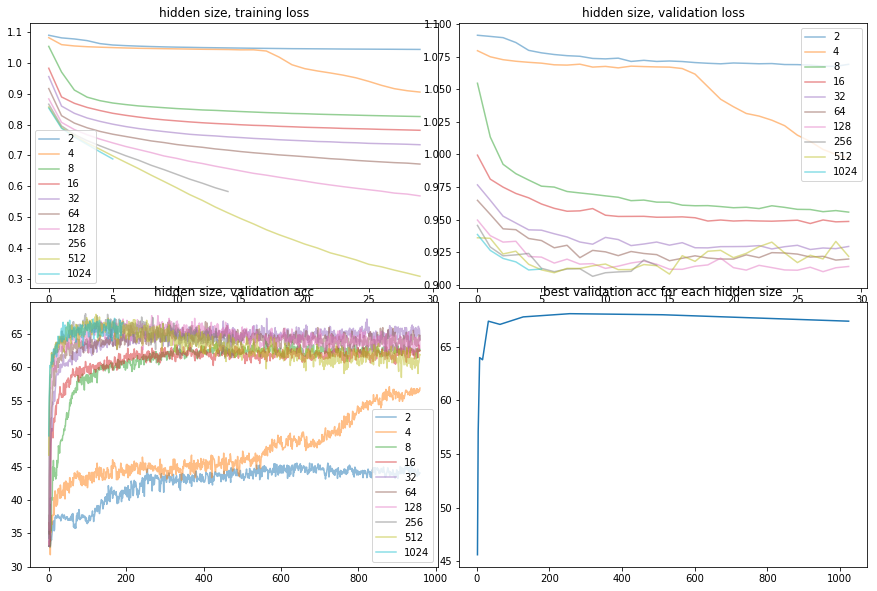

(256, 68.1)

In [6]:
### Better to align y axis for two loss graph

loss_lists, val_acc_lists, val_loss_lists = dict(), dict(), dict()
for n in [2,4,8,16,32,64,128,256,512,1024]:
    loss_lists[n] = unpickle_from_file('cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_{}_batch_32_kernel_1_lr_0.0003_l2_0/loss.p'.format(n))
    val_acc_lists[n] = unpickle_from_file('cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_{}_batch_32_kernel_1_lr_0.0003_l2_0/acc.p'.format(n))
    val_loss_lists[n] = unpickle_from_file('cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_{}_batch_32_kernel_1_lr_0.0003_l2_0/val_loss.p'.format(n))
best_hyperparam, best_val = plot_train_validation_new(loss_lists, val_loss_lists, val_acc_lists, "hidden size")
best_hyperparam, best_val

In [ ]:
### Better to align y axis for two loss graph

loss_lists, val_acc_lists, val_loss_lists = dict(), dict(), dict()
for n in [8,16,32,64,128,256,512,1024]:
    loss_lists[n] = unpickle_from_file('cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_{}_batch_32_kernel_1_lr_0.0003_l2_0/loss.p'.format(n))
    val_acc_lists[n] = unpickle_from_file('cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_{}_batch_32_kernel_1_lr_0.0003_l2_0/acc.p'.format(n))
    val_loss_lists[n] = unpickle_from_file('cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_{}_batch_32_kernel_1_lr_0.0003_l2_0/val_loss.p'.format(n))
best_hyperparam, best_val = plot_train_validation_new(loss_lists, val_loss_lists, val_acc_lists, "hidden size")
best_hyperparam, best_val

In [10]:
np.linspace(1e-06,1e-02,6)

array([1.0000e-06, 2.0008e-03, 4.0006e-03, 6.0004e-03, 8.0002e-03,
       1.0000e-02])

In [15]:
np.logspace(-6,1,8)

array([1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])

In [18]:
np.logspace(-12,1,14)

array([1.e-12, 1.e-11, 1.e-10, 1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05,
       1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01])

In [ ]:
for l2 in np.logspace(-12,1,14):
    train("l2", 256, 70000, batch_size=32, num_epochs=30, kernel_size=1, l2_penalty=l2, model_type="cnn")

fixed, three objects will be saved in three separate files
saved cnn_snli_l2_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-12/epoch_0_step_100.p
Epoch: [1/30], Step: [101/3125], Validation Acc: 40.0
saved cnn_snli_l2_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-12/epoch_0_step_200.p
Epoch: [1/30], Step: [201/3125], Validation Acc: 53.1
saved cnn_snli_l2_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-12/epoch_0_step_300.p
Epoch: [1/30], Step: [301/3125], Validation Acc: 55.8
saved cnn_snli_l2_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-12/epoch_0_step_400.p
Epoch: [1/30], Step: [401/3125], Validation Acc: 57.6
saved cnn_snli_l2_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-12/epoch_0_step_500.p
Epoch: [1/30], Step: [501/3125], Validation Acc: 58.8
saved cnn_snli_l2_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-12/epoch_0_step_600.p
Epoch: [1/30], Step: [601/3125], Validation Acc: 59.7
Epoch: [1/30], Step: [701/3125], Va

[1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0] [68.3, 67.5, 68.5, 68.6, 66.8, 61.3, 57.3, 57.2, 56.5, 54.3, 34.6, 33.8, 33.8, 33.8]


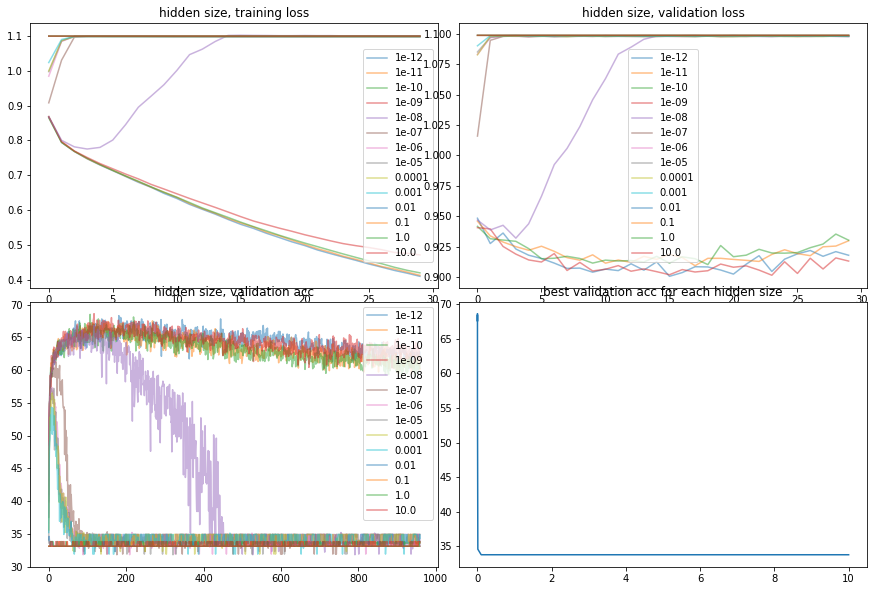

(1e-09, 68.6)

In [20]:
### Better to align y axis for two loss graph

loss_lists, val_acc_lists, val_loss_lists = dict(), dict(), dict()
for n in np.logspace(-12,1,14):
    loss_lists[n] = unpickle_from_file('cnn_snli_l2_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_{}/loss.p'.format(n))
    val_acc_lists[n] = unpickle_from_file('cnn_snli_l2_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_{}/acc.p'.format(n))
    val_loss_lists[n] = unpickle_from_file('cnn_snli_l2_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_{}/val_loss.p'.format(n))
best_hyperparam, best_val = plot_train_validation_new(loss_lists, val_loss_lists, val_acc_lists, "hidden size", log=True)
best_hyperparam, best_val

[1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0] [68.3, 67.5, 68.5, 68.6, 66.8, 61.3, 57.3, 57.2, 56.5, 54.3, 34.6, 33.8, 33.8, 33.8]


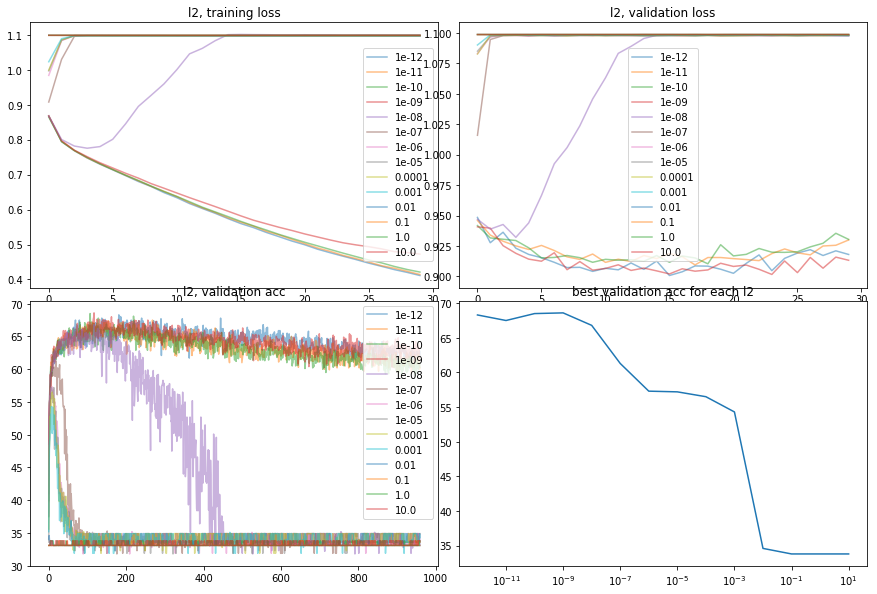

(1e-09, 68.6)

In [30]:
### Better to align y axis for two loss graph

loss_lists, val_acc_lists, val_loss_lists = dict(), dict(), dict()
for n in np.logspace(-12,1,14):
    loss_lists[n] = unpickle_from_file('cnn_snli_l2_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_{}/loss.p'.format(n))
    val_acc_lists[n] = unpickle_from_file('cnn_snli_l2_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_{}/acc.p'.format(n))
    val_loss_lists[n] = unpickle_from_file('cnn_snli_l2_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_{}/val_loss.p'.format(n))
best_hyperparam, best_val = plot_train_validation_new(loss_lists, val_loss_lists, val_acc_lists, "l2", log=True)
best_hyperparam, best_val

In [ ]:
#verified validation acc stays around 33.1
#train("test_shuffle", 256, 70000, batch_size=32, num_epochs=30, kernel_size=1, l2_penalty=1e-09, model_type="cnn", shuffle=True)

In [ ]:
# Try featurewise multiplication

In [27]:
train("interaction_fixed", 256, 70000, batch_size=32, num_epochs=30, kernel_size=1, model_type="cnn", interaction='featurewise_multiplication')

fixed, three objects will be saved in three separate files
saved cnn_snli_interaction_fixed_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_0_interaction_featurewise_multiplication/epoch_0_step_100.p
Epoch: [1/30], Step: [101/3125], Validation Acc: 33.1
saved cnn_snli_interaction_fixed_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_0_interaction_featurewise_multiplication/epoch_0_step_200.p
Epoch: [1/30], Step: [201/3125], Validation Acc: 37.0
saved cnn_snli_interaction_fixed_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_0_interaction_featurewise_multiplication/epoch_0_step_300.p
Epoch: [1/30], Step: [301/3125], Validation Acc: 41.7
saved cnn_snli_interaction_fixed_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_0_interaction_featurewise_multiplication/epoch_0_step_400.p
Epoch: [1/30], Step: [401/3125], Validation Acc: 45.9
saved cnn_snli_interaction_fixed_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_0_interaction_featurewise_multiplication/epoch_0_s

Epoch: [3/30], Step: [901/3125], Validation Acc: 63.7
Epoch: [3/30], Step: [1001/3125], Validation Acc: 63.4
Epoch: [3/30], Step: [1101/3125], Validation Acc: 62.5
Epoch: [3/30], Step: [1201/3125], Validation Acc: 62.4
saved cnn_snli_interaction_fixed_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_0_interaction_featurewise_multiplication/epoch_2_step_1300.p
Epoch: [3/30], Step: [1301/3125], Validation Acc: 65.8
Epoch: [3/30], Step: [1401/3125], Validation Acc: 65.3
Epoch: [3/30], Step: [1501/3125], Validation Acc: 65.1
Epoch: [3/30], Step: [1601/3125], Validation Acc: 64.8
Epoch: [3/30], Step: [1701/3125], Validation Acc: 63.8
Epoch: [3/30], Step: [1801/3125], Validation Acc: 64.5
Epoch: [3/30], Step: [1901/3125], Validation Acc: 64.4
Epoch: [3/30], Step: [2001/3125], Validation Acc: 64.5
Epoch: [3/30], Step: [2101/3125], Validation Acc: 65.6
Epoch: [3/30], Step: [2201/3125], Validation Acc: 63.5
saved cnn_snli_interaction_fixed_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003

Epoch: [7/30], Step: [601/3125], Validation Acc: 67.3
Epoch: [7/30], Step: [701/3125], Validation Acc: 69.0
Epoch: [7/30], Step: [801/3125], Validation Acc: 68.5
Epoch: [7/30], Step: [901/3125], Validation Acc: 66.8
Epoch: [7/30], Step: [1001/3125], Validation Acc: 68.0
Epoch: [7/30], Step: [1101/3125], Validation Acc: 67.2
Epoch: [7/30], Step: [1201/3125], Validation Acc: 68.3
Epoch: [7/30], Step: [1301/3125], Validation Acc: 66.8
Epoch: [7/30], Step: [1401/3125], Validation Acc: 63.1
Epoch: [7/30], Step: [1501/3125], Validation Acc: 66.8
Epoch: [7/30], Step: [1601/3125], Validation Acc: 66.1
Epoch: [7/30], Step: [1701/3125], Validation Acc: 68.5
Epoch: [7/30], Step: [1801/3125], Validation Acc: 65.8
Epoch: [7/30], Step: [1901/3125], Validation Acc: 68.6
Epoch: [7/30], Step: [2001/3125], Validation Acc: 68.1
Epoch: [7/30], Step: [2101/3125], Validation Acc: 68.1
Epoch: [7/30], Step: [2201/3125], Validation Acc: 68.1
Epoch: [7/30], Step: [2301/3125], Validation Acc: 67.4
Epoch: [7/30],

Epoch: [11/30], Step: [1001/3125], Validation Acc: 70.3
Epoch: [11/30], Step: [1101/3125], Validation Acc: 68.2
Epoch: [11/30], Step: [1201/3125], Validation Acc: 69.5
Epoch: [11/30], Step: [1301/3125], Validation Acc: 70.0
Epoch: [11/30], Step: [1401/3125], Validation Acc: 69.9
Epoch: [11/30], Step: [1501/3125], Validation Acc: 70.2
Epoch: [11/30], Step: [1601/3125], Validation Acc: 69.8
Epoch: [11/30], Step: [1701/3125], Validation Acc: 68.5
Epoch: [11/30], Step: [1801/3125], Validation Acc: 67.9
Epoch: [11/30], Step: [1901/3125], Validation Acc: 69.0
Epoch: [11/30], Step: [2001/3125], Validation Acc: 68.9
Epoch: [11/30], Step: [2101/3125], Validation Acc: 68.9
Epoch: [11/30], Step: [2201/3125], Validation Acc: 69.4
Epoch: [11/30], Step: [2301/3125], Validation Acc: 69.6
Epoch: [11/30], Step: [2401/3125], Validation Acc: 69.6
Epoch: [11/30], Step: [2501/3125], Validation Acc: 69.9
Epoch: [11/30], Step: [2601/3125], Validation Acc: 69.3
Epoch: [11/30], Step: [2701/3125], Validation Ac

Epoch: [15/30], Step: [2301/3125], Validation Acc: 70.7
Epoch: [15/30], Step: [2401/3125], Validation Acc: 69.4
Epoch: [15/30], Step: [2501/3125], Validation Acc: 69.2
Epoch: [15/30], Step: [2601/3125], Validation Acc: 68.4
Epoch: [15/30], Step: [2701/3125], Validation Acc: 68.4
Epoch: [15/30], Step: [2801/3125], Validation Acc: 68.3
Epoch: [15/30], Step: [2901/3125], Validation Acc: 70.1
Epoch: [15/30], Step: [3001/3125], Validation Acc: 71.3
Epoch: [15/30], Step: [3101/3125], Validation Acc: 68.2
Epoch: [15/30], Validation Acc: 67.5, train mean loss: 0.511414538974762, val mean loss: 0.8715667482465506
Epoch: [16/30], Step: [101/3125], Validation Acc: 69.5
Epoch: [16/30], Step: [201/3125], Validation Acc: 69.4
Epoch: [16/30], Step: [301/3125], Validation Acc: 69.9
Epoch: [16/30], Step: [401/3125], Validation Acc: 68.6
Epoch: [16/30], Step: [501/3125], Validation Acc: 69.7
Epoch: [16/30], Step: [601/3125], Validation Acc: 70.1
Epoch: [16/30], Step: [701/3125], Validation Acc: 69.2
Epo

Epoch: [20/30], Step: [601/3125], Validation Acc: 68.4
Epoch: [20/30], Step: [701/3125], Validation Acc: 70.5
Epoch: [20/30], Step: [801/3125], Validation Acc: 68.3
Epoch: [20/30], Step: [901/3125], Validation Acc: 69.4
Epoch: [20/30], Step: [1001/3125], Validation Acc: 69.2
Epoch: [20/30], Step: [1101/3125], Validation Acc: 70.0
Epoch: [20/30], Step: [1201/3125], Validation Acc: 71.0
Epoch: [20/30], Step: [1301/3125], Validation Acc: 70.5
Epoch: [20/30], Step: [1401/3125], Validation Acc: 70.2
Epoch: [20/30], Step: [1501/3125], Validation Acc: 70.4
Epoch: [20/30], Step: [1601/3125], Validation Acc: 66.7
Epoch: [20/30], Step: [1701/3125], Validation Acc: 68.1
Epoch: [20/30], Step: [1801/3125], Validation Acc: 69.3
Epoch: [20/30], Step: [1901/3125], Validation Acc: 71.0
Epoch: [20/30], Step: [2001/3125], Validation Acc: 70.8
Epoch: [20/30], Step: [2101/3125], Validation Acc: 69.4
Epoch: [20/30], Step: [2201/3125], Validation Acc: 68.4
Epoch: [20/30], Step: [2301/3125], Validation Acc: 7

Epoch: [24/30], Step: [1901/3125], Validation Acc: 69.3
Epoch: [24/30], Step: [2001/3125], Validation Acc: 68.9
Epoch: [24/30], Step: [2101/3125], Validation Acc: 70.2
Epoch: [24/30], Step: [2201/3125], Validation Acc: 69.0
Epoch: [24/30], Step: [2301/3125], Validation Acc: 71.0
Epoch: [24/30], Step: [2401/3125], Validation Acc: 67.6
Epoch: [24/30], Step: [2501/3125], Validation Acc: 71.1
Epoch: [24/30], Step: [2601/3125], Validation Acc: 69.7
Epoch: [24/30], Step: [2701/3125], Validation Acc: 69.3
Epoch: [24/30], Step: [2801/3125], Validation Acc: 69.9
Epoch: [24/30], Step: [2901/3125], Validation Acc: 68.8
Epoch: [24/30], Step: [3001/3125], Validation Acc: 70.3
Epoch: [24/30], Step: [3101/3125], Validation Acc: 70.6
Epoch: [24/30], Validation Acc: 69.7, train mean loss: 0.4051844104218483, val mean loss: 0.8559336438775063
Epoch: [25/30], Step: [101/3125], Validation Acc: 71.2
Epoch: [25/30], Step: [201/3125], Validation Acc: 70.6
Epoch: [25/30], Step: [301/3125], Validation Acc: 70.

Epoch: [29/30], Step: [201/3125], Validation Acc: 68.9
Epoch: [29/30], Step: [301/3125], Validation Acc: 67.3
Epoch: [29/30], Step: [401/3125], Validation Acc: 68.6
Epoch: [29/30], Step: [501/3125], Validation Acc: 68.2
Epoch: [29/30], Step: [601/3125], Validation Acc: 68.6
Epoch: [29/30], Step: [701/3125], Validation Acc: 65.8
Epoch: [29/30], Step: [801/3125], Validation Acc: 68.1
Epoch: [29/30], Step: [901/3125], Validation Acc: 68.9
Epoch: [29/30], Step: [1001/3125], Validation Acc: 69.8
Epoch: [29/30], Step: [1101/3125], Validation Acc: 69.3
Epoch: [29/30], Step: [1201/3125], Validation Acc: 70.0
Epoch: [29/30], Step: [1301/3125], Validation Acc: 68.7
Epoch: [29/30], Step: [1401/3125], Validation Acc: 71.1
Epoch: [29/30], Step: [1501/3125], Validation Acc: 71.5
Epoch: [29/30], Step: [1601/3125], Validation Acc: 69.3
Epoch: [29/30], Step: [1701/3125], Validation Acc: 70.3
Epoch: [29/30], Step: [1801/3125], Validation Acc: 67.6
Epoch: [29/30], Step: [1901/3125], Validation Acc: 69.9


In [ ]:
# Less performance around 67.9
# train("interaction_fixed", 256, 70000, batch_size=32, num_epochs=30, kernel_size=3, model_type="cnn", interaction='featurewise_multiplication')

In [ ]:
for l2 in np.logspace(-12,1,14):
    train("interaction_l2", 256, 70000, batch_size=32, num_epochs=30, kernel_size=1, l2_penalty=l2, model_type="cnn", interaction='featurewise_multiplication')

fixed, three objects will be saved in three separate files
saved cnn_snli_interaction_l2_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-12_interaction_featurewise_multiplication/epoch_0_step_100.p
Epoch: [1/30], Step: [101/3125], Validation Acc: 37.4
Epoch: [1/30], Step: [201/3125], Validation Acc: 36.4
saved cnn_snli_interaction_l2_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-12_interaction_featurewise_multiplication/epoch_0_step_300.p
Epoch: [1/30], Step: [301/3125], Validation Acc: 39.5
saved cnn_snli_interaction_l2_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-12_interaction_featurewise_multiplication/epoch_0_step_400.p
Epoch: [1/30], Step: [401/3125], Validation Acc: 44.2
saved cnn_snli_interaction_l2_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-12_interaction_featurewise_multiplication/epoch_0_step_500.p
Epoch: [1/30], Step: [501/3125], Validation Acc: 45.4
Epoch: [1/30], Step: [601/3125], Validation Acc: 45.4
saved cnn_snli_interactio

saved cnn_snli_interaction_l2_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-12_interaction_featurewise_multiplication/epoch_2_step_800.p
Epoch: [3/30], Step: [801/3125], Validation Acc: 64.5
Epoch: [3/30], Step: [901/3125], Validation Acc: 64.4
Epoch: [3/30], Step: [1001/3125], Validation Acc: 63.7
saved cnn_snli_interaction_l2_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-12_interaction_featurewise_multiplication/epoch_2_step_1100.p
Epoch: [3/30], Step: [1101/3125], Validation Acc: 64.7
Epoch: [3/30], Step: [1201/3125], Validation Acc: 64.1
Epoch: [3/30], Step: [1301/3125], Validation Acc: 63.3
Epoch: [3/30], Step: [1401/3125], Validation Acc: 63.5
saved cnn_snli_interaction_l2_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-12_interaction_featurewise_multiplication/epoch_2_step_1500.p
Epoch: [3/30], Step: [1501/3125], Validation Acc: 64.8
saved cnn_snli_interaction_l2_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-12_interaction_featurewise_mu

Epoch: [6/30], Step: [2101/3125], Validation Acc: 68.6
Epoch: [6/30], Step: [2201/3125], Validation Acc: 68.8
Epoch: [6/30], Step: [2301/3125], Validation Acc: 67.6
Epoch: [6/30], Step: [2401/3125], Validation Acc: 67.9
Epoch: [6/30], Step: [2501/3125], Validation Acc: 69.3
Epoch: [6/30], Step: [2601/3125], Validation Acc: 69.4
Epoch: [6/30], Step: [2701/3125], Validation Acc: 68.3
Epoch: [6/30], Step: [2801/3125], Validation Acc: 69.5
Epoch: [6/30], Step: [2901/3125], Validation Acc: 69.3
Epoch: [6/30], Step: [3001/3125], Validation Acc: 69.6
Epoch: [6/30], Step: [3101/3125], Validation Acc: 68.8
Epoch: [6/30], Validation Acc: 67.4, train mean loss: 0.6669911792564392, val mean loss: 0.9011872746050358
Epoch: [7/30], Step: [101/3125], Validation Acc: 67.9
Epoch: [7/30], Step: [201/3125], Validation Acc: 68.4
Epoch: [7/30], Step: [301/3125], Validation Acc: 69.0
Epoch: [7/30], Step: [401/3125], Validation Acc: 67.4
Epoch: [7/30], Step: [501/3125], Validation Acc: 66.3
Epoch: [7/30], St

Epoch: [10/30], Step: [2801/3125], Validation Acc: 67.9
Epoch: [10/30], Step: [2901/3125], Validation Acc: 67.8
Epoch: [10/30], Step: [3001/3125], Validation Acc: 68.1
Epoch: [10/30], Step: [3101/3125], Validation Acc: 68.4
Epoch: [10/30], Validation Acc: 67.2, train mean loss: 0.5842691897678375, val mean loss: 0.8844683207571507
Epoch: [11/30], Step: [101/3125], Validation Acc: 67.9
Epoch: [11/30], Step: [201/3125], Validation Acc: 68.6
Epoch: [11/30], Step: [301/3125], Validation Acc: 69.6
Epoch: [11/30], Step: [401/3125], Validation Acc: 65.3
Epoch: [11/30], Step: [501/3125], Validation Acc: 68.9
Epoch: [11/30], Step: [601/3125], Validation Acc: 68.7
Epoch: [11/30], Step: [701/3125], Validation Acc: 68.2
Epoch: [11/30], Step: [801/3125], Validation Acc: 69.2
Epoch: [11/30], Step: [901/3125], Validation Acc: 70.3
Epoch: [11/30], Step: [1001/3125], Validation Acc: 68.8
Epoch: [11/30], Step: [1101/3125], Validation Acc: 68.3
Epoch: [11/30], Step: [1201/3125], Validation Acc: 67.6
Epoc

Epoch: [15/30], Step: [801/3125], Validation Acc: 70.7
Epoch: [15/30], Step: [901/3125], Validation Acc: 68.9
Epoch: [15/30], Step: [1001/3125], Validation Acc: 70.0
Epoch: [15/30], Step: [1101/3125], Validation Acc: 68.3
Epoch: [15/30], Step: [1201/3125], Validation Acc: 69.7
Epoch: [15/30], Step: [1301/3125], Validation Acc: 69.5
Epoch: [15/30], Step: [1401/3125], Validation Acc: 70.8
Epoch: [15/30], Step: [1501/3125], Validation Acc: 70.1
Epoch: [15/30], Step: [1601/3125], Validation Acc: 68.4
Epoch: [15/30], Step: [1701/3125], Validation Acc: 70.2
Epoch: [15/30], Step: [1801/3125], Validation Acc: 69.3
Epoch: [15/30], Step: [1901/3125], Validation Acc: 69.3
Epoch: [15/30], Step: [2001/3125], Validation Acc: 69.7
Epoch: [15/30], Step: [2101/3125], Validation Acc: 67.7
Epoch: [15/30], Step: [2201/3125], Validation Acc: 70.0
Epoch: [15/30], Step: [2301/3125], Validation Acc: 70.2
Epoch: [15/30], Step: [2401/3125], Validation Acc: 68.9
Epoch: [15/30], Step: [2501/3125], Validation Acc:

Epoch: [19/30], Step: [1801/3125], Validation Acc: 69.1
Epoch: [19/30], Step: [1901/3125], Validation Acc: 68.3
Epoch: [19/30], Step: [2001/3125], Validation Acc: 69.3
Epoch: [19/30], Step: [2101/3125], Validation Acc: 69.6
Epoch: [19/30], Step: [2201/3125], Validation Acc: 68.4
Epoch: [19/30], Step: [2301/3125], Validation Acc: 68.2
Epoch: [19/30], Step: [2401/3125], Validation Acc: 67.4
Epoch: [19/30], Step: [2501/3125], Validation Acc: 68.0
Epoch: [19/30], Step: [2601/3125], Validation Acc: 69.5
Epoch: [19/30], Step: [2701/3125], Validation Acc: 69.7
Epoch: [19/30], Step: [2801/3125], Validation Acc: 68.9
Epoch: [19/30], Step: [2901/3125], Validation Acc: 70.3
Epoch: [19/30], Step: [3001/3125], Validation Acc: 67.6
Epoch: [19/30], Step: [3101/3125], Validation Acc: 70.2
Epoch: [19/30], Validation Acc: 70.2, train mean loss: 0.4579570531702042, val mean loss: 0.8568899650126696
Epoch: [20/30], Step: [101/3125], Validation Acc: 70.0
Epoch: [20/30], Step: [201/3125], Validation Acc: 68

Epoch: [24/30], Step: [101/3125], Validation Acc: 68.5
Epoch: [24/30], Step: [201/3125], Validation Acc: 70.5
Epoch: [24/30], Step: [301/3125], Validation Acc: 69.4
Epoch: [24/30], Step: [401/3125], Validation Acc: 69.0
Epoch: [24/30], Step: [501/3125], Validation Acc: 69.8
Epoch: [24/30], Step: [601/3125], Validation Acc: 68.9
Epoch: [24/30], Step: [701/3125], Validation Acc: 70.0
Epoch: [24/30], Step: [801/3125], Validation Acc: 68.0
Epoch: [24/30], Step: [901/3125], Validation Acc: 69.8
Epoch: [24/30], Step: [1001/3125], Validation Acc: 69.8
Epoch: [24/30], Step: [1101/3125], Validation Acc: 69.8
Epoch: [24/30], Step: [1201/3125], Validation Acc: 70.1
Epoch: [24/30], Step: [1301/3125], Validation Acc: 69.7
Epoch: [24/30], Step: [1401/3125], Validation Acc: 68.4
Epoch: [24/30], Step: [1501/3125], Validation Acc: 69.4
Epoch: [24/30], Step: [1601/3125], Validation Acc: 71.3
Epoch: [24/30], Step: [1701/3125], Validation Acc: 69.2
Epoch: [24/30], Step: [1801/3125], Validation Acc: 67.9
E

Epoch: [28/30], Step: [1701/3125], Validation Acc: 69.6
Epoch: [28/30], Step: [1801/3125], Validation Acc: 68.2
Epoch: [28/30], Step: [1901/3125], Validation Acc: 68.4
Epoch: [28/30], Step: [2001/3125], Validation Acc: 68.3
Epoch: [28/30], Step: [2101/3125], Validation Acc: 68.2
Epoch: [28/30], Step: [2201/3125], Validation Acc: 69.3
Epoch: [28/30], Step: [2301/3125], Validation Acc: 69.7
Epoch: [28/30], Step: [2401/3125], Validation Acc: 66.9
Epoch: [28/30], Step: [2501/3125], Validation Acc: 69.0
Epoch: [28/30], Step: [2601/3125], Validation Acc: 67.8
Epoch: [28/30], Step: [2701/3125], Validation Acc: 66.9
Epoch: [28/30], Step: [2801/3125], Validation Acc: 68.6
Epoch: [28/30], Step: [2901/3125], Validation Acc: 67.6
Epoch: [28/30], Step: [3001/3125], Validation Acc: 67.5
Epoch: [28/30], Step: [3101/3125], Validation Acc: 66.3
Epoch: [28/30], Validation Acc: 68.1, train mean loss: 0.3660431226825714, val mean loss: 0.8642832823097706
Epoch: [29/30], Step: [101/3125], Validation Acc: 6

Epoch: [1/30], Step: [2201/3125], Validation Acc: 56.7
saved cnn_snli_interaction_l2_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-11_interaction_featurewise_multiplication/epoch_0_step_2300.p
Epoch: [1/30], Step: [2301/3125], Validation Acc: 59.3
Epoch: [1/30], Step: [2401/3125], Validation Acc: 58.0
Epoch: [1/30], Step: [2501/3125], Validation Acc: 59.2
saved cnn_snli_interaction_l2_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-11_interaction_featurewise_multiplication/epoch_0_step_2600.p
Epoch: [1/30], Step: [2601/3125], Validation Acc: 60.1
Epoch: [1/30], Step: [2701/3125], Validation Acc: 57.1
saved cnn_snli_interaction_l2_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-11_interaction_featurewise_multiplication/epoch_0_step_2800.p
Epoch: [1/30], Step: [2801/3125], Validation Acc: 60.4
Epoch: [1/30], Step: [2901/3125], Validation Acc: 59.4
saved cnn_snli_interaction_l2_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-11_interaction_featurewise

Epoch: [4/30], Step: [2401/3125], Validation Acc: 68.0
Epoch: [4/30], Step: [2501/3125], Validation Acc: 68.1
Epoch: [4/30], Step: [2601/3125], Validation Acc: 68.4
saved cnn_snli_interaction_l2_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-11_interaction_featurewise_multiplication/epoch_3_step_2700.p
Epoch: [4/30], Step: [2701/3125], Validation Acc: 69.5
Epoch: [4/30], Step: [2801/3125], Validation Acc: 69.3
Epoch: [4/30], Step: [2901/3125], Validation Acc: 67.8
Epoch: [4/30], Step: [3001/3125], Validation Acc: 66.7
Epoch: [4/30], Step: [3101/3125], Validation Acc: 68.6
Epoch: [4/30], Validation Acc: 66.6, train mean loss: 0.7177469362545014, val mean loss: 0.910178666934371
Epoch: [5/30], Step: [101/3125], Validation Acc: 68.7
Epoch: [5/30], Step: [201/3125], Validation Acc: 68.0
Epoch: [5/30], Step: [301/3125], Validation Acc: 68.7
Epoch: [5/30], Step: [401/3125], Validation Acc: 68.1
Epoch: [5/30], Step: [501/3125], Validation Acc: 68.5
Epoch: [5/30], Step: [601/3125], V

Epoch: [8/30], Step: [2601/3125], Validation Acc: 68.9
Epoch: [8/30], Step: [2701/3125], Validation Acc: 69.5
Epoch: [8/30], Step: [2801/3125], Validation Acc: 68.7
Epoch: [8/30], Step: [2901/3125], Validation Acc: 69.4
Epoch: [8/30], Step: [3001/3125], Validation Acc: 68.9
Epoch: [8/30], Step: [3101/3125], Validation Acc: 69.4
Epoch: [8/30], Validation Acc: 69.5, train mean loss: 0.6216698798465728, val mean loss: 0.8788109496235847
Epoch: [9/30], Step: [101/3125], Validation Acc: 67.8
Epoch: [9/30], Step: [201/3125], Validation Acc: 67.7
Epoch: [9/30], Step: [301/3125], Validation Acc: 66.7
Epoch: [9/30], Step: [401/3125], Validation Acc: 69.7
Epoch: [9/30], Step: [501/3125], Validation Acc: 69.2
Epoch: [9/30], Step: [601/3125], Validation Acc: 69.3
Epoch: [9/30], Step: [701/3125], Validation Acc: 69.7
Epoch: [9/30], Step: [801/3125], Validation Acc: 68.6
Epoch: [9/30], Step: [901/3125], Validation Acc: 69.1
Epoch: [9/30], Step: [1001/3125], Validation Acc: 67.6
Epoch: [9/30], Step: 

Epoch: [13/30], Step: [401/3125], Validation Acc: 70.1
Epoch: [13/30], Step: [501/3125], Validation Acc: 70.5
Epoch: [13/30], Step: [601/3125], Validation Acc: 70.8
Epoch: [13/30], Step: [701/3125], Validation Acc: 70.7
Epoch: [13/30], Step: [801/3125], Validation Acc: 70.1
Epoch: [13/30], Step: [901/3125], Validation Acc: 69.4
Epoch: [13/30], Step: [1001/3125], Validation Acc: 70.5
Epoch: [13/30], Step: [1101/3125], Validation Acc: 70.3
Epoch: [13/30], Step: [1201/3125], Validation Acc: 69.8
Epoch: [13/30], Step: [1301/3125], Validation Acc: 69.3
Epoch: [13/30], Step: [1401/3125], Validation Acc: 70.1
Epoch: [13/30], Step: [1501/3125], Validation Acc: 70.0
Epoch: [13/30], Step: [1601/3125], Validation Acc: 70.9
Epoch: [13/30], Step: [1701/3125], Validation Acc: 68.2
Epoch: [13/30], Step: [1801/3125], Validation Acc: 69.6
Epoch: [13/30], Step: [1901/3125], Validation Acc: 70.2
Epoch: [13/30], Step: [2001/3125], Validation Acc: 69.3
Epoch: [13/30], Step: [2101/3125], Validation Acc: 70.

Epoch: [17/30], Step: [1701/3125], Validation Acc: 69.5
Epoch: [17/30], Step: [1801/3125], Validation Acc: 70.0
Epoch: [17/30], Step: [1901/3125], Validation Acc: 71.1
Epoch: [17/30], Step: [2001/3125], Validation Acc: 70.6
Epoch: [17/30], Step: [2101/3125], Validation Acc: 68.1
Epoch: [17/30], Step: [2201/3125], Validation Acc: 70.9
Epoch: [17/30], Step: [2301/3125], Validation Acc: 70.3
Epoch: [17/30], Step: [2401/3125], Validation Acc: 70.2
Epoch: [17/30], Step: [2501/3125], Validation Acc: 71.7
Epoch: [17/30], Step: [2601/3125], Validation Acc: 71.3
Epoch: [17/30], Step: [2701/3125], Validation Acc: 71.3
Epoch: [17/30], Step: [2801/3125], Validation Acc: 71.4
Epoch: [17/30], Step: [2901/3125], Validation Acc: 70.4
Epoch: [17/30], Step: [3001/3125], Validation Acc: 69.9
Epoch: [17/30], Step: [3101/3125], Validation Acc: 70.6
Epoch: [17/30], Validation Acc: 70.8, train mean loss: 0.4788054503917694, val mean loss: 0.8556922525167465
Epoch: [18/30], Step: [101/3125], Validation Acc: 7

['concat', 'multiply'] [68.1, 72.1]


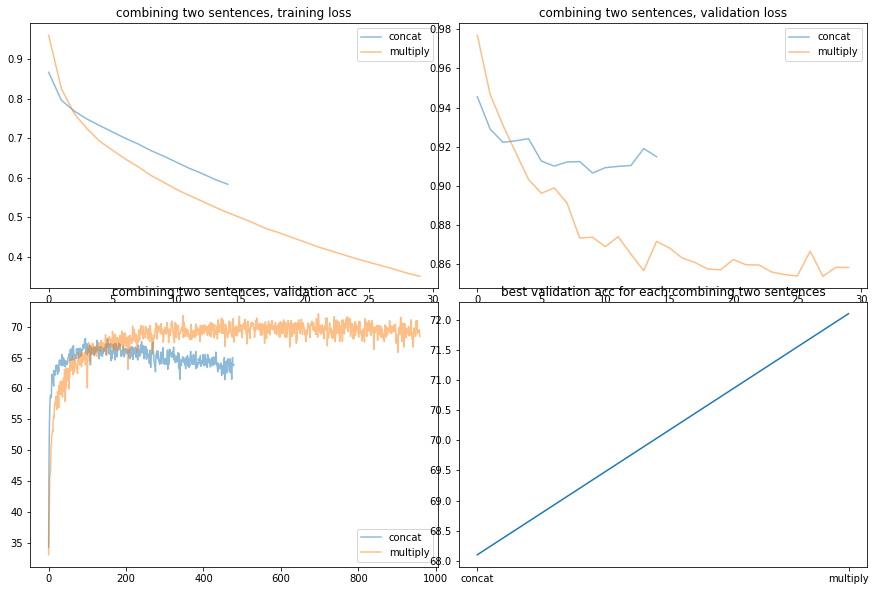

('multiply', 72.1)

In [31]:
### Better to align y axis for two loss graph

loss_lists, val_acc_lists, val_loss_lists = dict(), dict(), dict()
loss_lists['concat'] = unpickle_from_file('cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_0/loss.p')
val_acc_lists['concat'] = unpickle_from_file('cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_0/acc.p')
val_loss_lists['concat'] = unpickle_from_file('cnn_snli_all_kernel_size_fixed_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_0/val_loss.p')
loss_lists['multiply'] = unpickle_from_file('cnn_snli_interaction_fixed_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_0_interaction_featurewise_multiplication/loss.p')
val_acc_lists['multiply'] = unpickle_from_file('cnn_snli_interaction_fixed_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_0_interaction_featurewise_multiplication/acc.p')
val_loss_lists['multiply'] = unpickle_from_file('cnn_snli_interaction_fixed_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_0_interaction_featurewise_multiplication/val_loss.p')
best_hyperparam, best_val = plot_train_validation_new(loss_lists, val_loss_lists, val_acc_lists, "combining two sentences")
best_hyperparam, best_val

[1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1] [71.6, 72.7, 72.9, 72.7, 65.6, 51.6, 46.9, 42.0, 42.1, 33.8, 33.8, 33.8]


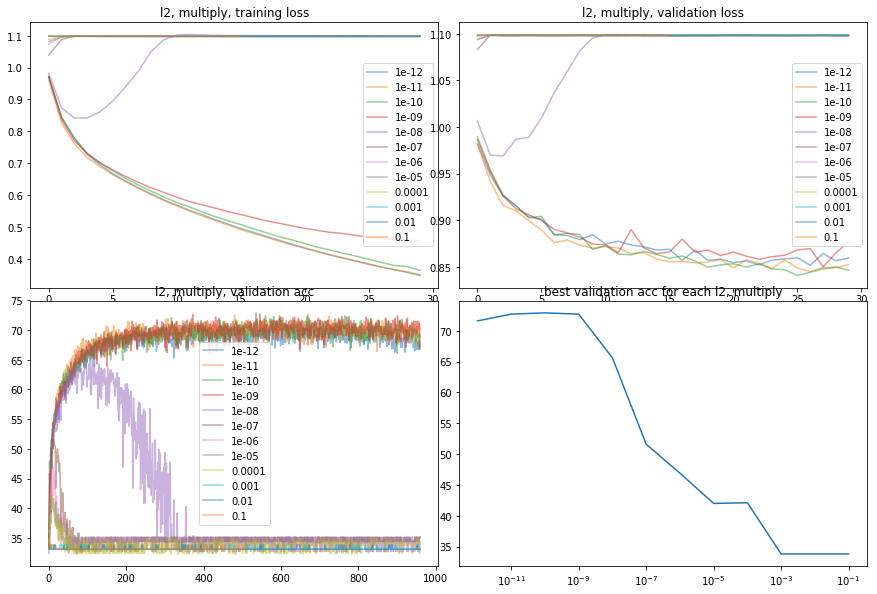

(1e-10, 72.9)

In [32]:
### Better to align y axis for two loss graph

loss_lists, val_acc_lists, val_loss_lists = dict(), dict(), dict()
for n in np.logspace(-12,-1,12):
    loss_lists[n] = unpickle_from_file('cnn_snli_interaction_l2_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_{}_interaction_featurewise_multiplication/loss.p'.format(n))
    val_acc_lists[n] = unpickle_from_file('cnn_snli_interaction_l2_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_{}_interaction_featurewise_multiplication/acc.p'.format(n))
    val_loss_lists[n] = unpickle_from_file('cnn_snli_interaction_l2_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_{}_interaction_featurewise_multiplication/val_loss.p'.format(n))
best_hyperparam, best_val = plot_train_validation_new(loss_lists, val_loss_lists, val_acc_lists, "l2, multiply", log=True)
best_hyperparam, best_val

In [ ]:
# Try weight sharing

In [7]:
show_result('rnn_snli_ftgru_maxvocab_50000_hid_256_batch_64_lr_0.0003/epoch_8_step_3000.p',256)

fiction test acc: 43.41708542713568
telephone test acc: 45.17412935323383
slate test acc: 40.119760479041915
government test acc: 42.32283464566929
travel test acc: 43.4826883910387


In [36]:
show_result('cnn_snli_interaction_l2_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-10_interaction_featurewise_multiplication/epoch_16_step_2500.p',256,max_vocab_size=70000,kernel_size=1,model_type="cnn",interaction="featurewise_multiplication")

torch.Size([70000, 300]) 21000000
torch.Size([256, 300, 1]) 76800
torch.Size([256]) 256
torch.Size([256, 256, 1]) 65536
torch.Size([256]) 256
torch.Size([256, 256]) 65536
torch.Size([256]) 256
torch.Size([3, 256]) 768
torch.Size([3]) 3
total params 21209411
val acc: 72.9
fiction test acc: 41.10552763819096
telephone test acc: 40.19900497512438
slate test acc: 39.221556886227546
government test acc: 37.696850393700785
travel test acc: 40.32586558044807


In [ ]:
for hidden_size in [2,4,8,16,32,64,128,512,1024]:
    train("step2", hidden_size, 70000, batch_size=32, num_epochs=30, model_type="rnn",interaction="featurewise_multiplication")

torch.Size([70000, 300]) 21000000
torch.Size([6, 300]) 1800
torch.Size([6, 2]) 12
torch.Size([6]) 6
torch.Size([6]) 6
torch.Size([6, 300]) 1800
torch.Size([6, 2]) 12
torch.Size([6]) 6
torch.Size([6]) 6
torch.Size([6, 300]) 1800
torch.Size([6, 2]) 12
torch.Size([6]) 6
torch.Size([6]) 6
torch.Size([6, 300]) 1800
torch.Size([6, 2]) 12
torch.Size([6]) 6
torch.Size([6]) 6
torch.Size([2, 4]) 8
torch.Size([2]) 2
torch.Size([3, 2]) 6
torch.Size([3]) 3
total params 21007315
fixed, three objects will be saved in three separate files
saved rnn_snli_step2_maxvocab_70000_hid_2_batch_32_kernel_3_lr_0.0003_l2_0_interaction_featurewise_multiplication/epoch_0_step_100.p
Epoch: [1/30], Step: [101/3125], Validation Acc: 33.8
saved rnn_snli_step2_maxvocab_70000_hid_2_batch_32_kernel_3_lr_0.0003_l2_0_interaction_featurewise_multiplication/epoch_0_step_200.p
Epoch: [1/30], Step: [201/3125], Validation Acc: 34.0
Epoch: [1/30], Step: [301/3125], Validation Acc: 33.9
Epoch: [1/30], Step: [401/3125], Validation

In [ ]:
train("step2", 256, 70000, batch_size=32, num_epochs=30, model_type="rnn",interaction="featurewise_multiplication")

[2, 4, 8, 16, 32, 64, 128, 256, 512, 1024] [61.6, 63.8, 68.5, 71.2, 71.1, 71.1, 71.4, 72.4, 72.9, 72.7]


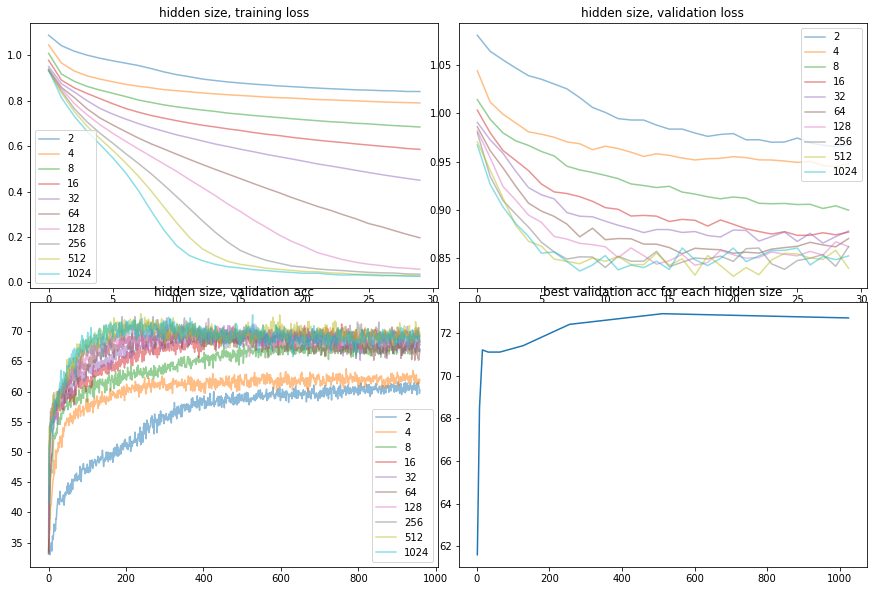

(512, 72.9)

In [7]:
### Better to align y axis for two loss graph

loss_lists, val_acc_lists, val_loss_lists = dict(), dict(), dict()
for n in [2,4,8,16,32,64,128,256,512,1024]:
    loss_lists[n] = unpickle_from_file('rnn_snli_step2_maxvocab_70000_hid_{}_batch_32_kernel_3_lr_0.0003_l2_0_interaction_featurewise_multiplication/loss.p'.format(n))
    val_acc_lists[n] = unpickle_from_file('rnn_snli_step2_maxvocab_70000_hid_{}_batch_32_kernel_3_lr_0.0003_l2_0_interaction_featurewise_multiplication/acc.p'.format(n))
    val_loss_lists[n] = unpickle_from_file('rnn_snli_step2_maxvocab_70000_hid_{}_batch_32_kernel_3_lr_0.0003_l2_0_interaction_featurewise_multiplication/val_loss.p'.format(n))
best_hyperparam, best_val = plot_train_validation_new(loss_lists, val_loss_lists, val_acc_lists, "hidden size")
best_hyperparam, best_val

In [8]:
for i in [2,4,8,16,32,64,128,256,512,1024]:
    model = RNN(None, 
                emb_size=300, 
                hidden_size=i,
                num_layers=1,
                num_classes=3, 
                vocab_size=70000,
               interaction="featurewise_multiplication")
    total_params = 0
    for parameter in model.parameters():
        if parameter.requires_grad:
            print(parameter.shape, parameter.numel())
            total_params += parameter.numel()
    print("kernel size:", i, "total params", total_params)

torch.Size([70000, 300]) 21000000
torch.Size([6, 300]) 1800
torch.Size([6, 2]) 12
torch.Size([6]) 6
torch.Size([6]) 6
torch.Size([6, 300]) 1800
torch.Size([6, 2]) 12
torch.Size([6]) 6
torch.Size([6]) 6
torch.Size([6, 300]) 1800
torch.Size([6, 2]) 12
torch.Size([6]) 6
torch.Size([6]) 6
torch.Size([6, 300]) 1800
torch.Size([6, 2]) 12
torch.Size([6]) 6
torch.Size([6]) 6
torch.Size([2, 4]) 8
torch.Size([2]) 2
torch.Size([3, 2]) 6
torch.Size([3]) 3
kernel size: 2 total params 21007315
torch.Size([70000, 300]) 21000000
torch.Size([12, 300]) 3600
torch.Size([12, 4]) 48
torch.Size([12]) 12
torch.Size([12]) 12
torch.Size([12, 300]) 3600
torch.Size([12, 4]) 48
torch.Size([12]) 12
torch.Size([12]) 12
torch.Size([12, 300]) 3600
torch.Size([12, 4]) 48
torch.Size([12]) 12
torch.Size([12]) 12
torch.Size([12, 300]) 3600
torch.Size([12, 4]) 48
torch.Size([12]) 12
torch.Size([12]) 12
torch.Size([4, 8]) 32
torch.Size([4]) 4
torch.Size([3, 4]) 12
torch.Size([3]) 3
kernel size: 4 total params 21014739
torc

[1e-12, 1e-11, 1e-10] [72.7, 72.2, 71.2]


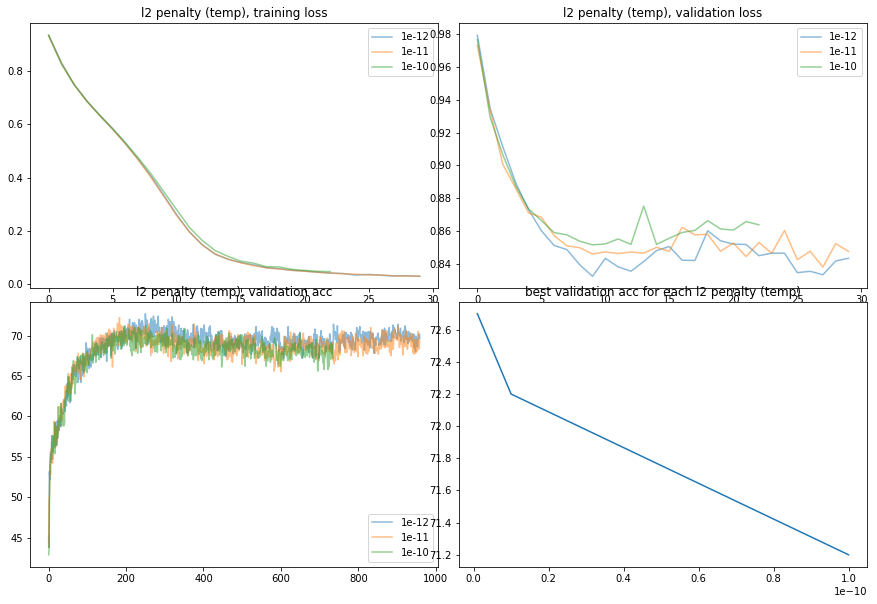

(1e-12, 72.7)

In [44]:
### Better to align y axis for two loss graph

loss_lists, val_acc_lists, val_loss_lists = dict(), dict(), dict()
for n in np.logspace(-12,-10,3):
    loss_lists[n] = unpickle_from_file('rnn_snli_step2_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_{}_interaction_featurewise_multiplication/loss.p'.format(n))
    val_acc_lists[n] = unpickle_from_file('rnn_snli_step2_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_{}_interaction_featurewise_multiplication/acc.p'.format(n))
    val_loss_lists[n] = unpickle_from_file('rnn_snli_step2_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_{}_interaction_featurewise_multiplication/val_loss.p'.format(n))
best_hyperparam, best_val = plot_train_validation_new(loss_lists, val_loss_lists, val_acc_lists, "l2 penalty (temp)")
best_hyperparam, best_val

In [46]:
np.logspace(-16,-13,4)

array([1.e-16, 1.e-15, 1.e-14, 1.e-13])

In [41]:
for each in reversed(np.logspace(-12,-2,11)):
    print(each)

0.01
0.001
0.0001
1e-05
1e-06
1e-07
1e-08
1e-09
1e-10
1e-11
1e-12


In [ ]:
train("step2", 512, 70000, batch_size=32, num_epochs=30, model_type="rnn",interaction="concat")
for l2 in np.logspace(-12,1,14):
    train("step2", 512, 70000, batch_size=32, num_epochs=30, l2_penalty=l2, model_type="rnn",interaction="featurewise_multiplication")

In [ ]:
for l2 in reversed(np.logspace(-16,-13,4)):
    train("step2", 512, 70000, batch_size=32, num_epochs=30, l2_penalty=l2, model_type="rnn",interaction="featurewise_multiplication")

torch.Size([70000, 300]) 21000000
torch.Size([1536, 300]) 460800
torch.Size([1536, 512]) 786432
torch.Size([1536]) 1536
torch.Size([1536]) 1536
torch.Size([1536, 300]) 460800
torch.Size([1536, 512]) 786432
torch.Size([1536]) 1536
torch.Size([1536]) 1536
torch.Size([1536, 300]) 460800
torch.Size([1536, 512]) 786432
torch.Size([1536]) 1536
torch.Size([1536]) 1536
torch.Size([1536, 300]) 460800
torch.Size([1536, 512]) 786432
torch.Size([1536]) 1536
torch.Size([1536]) 1536
torch.Size([512, 1024]) 524288
torch.Size([512]) 512
torch.Size([3, 512]) 1536
torch.Size([3]) 3
total params 26527555
fixed, three objects will be saved in three separate files
saved rnn_snli_step2_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_1e-13_interaction_featurewise_multiplication/epoch_0_step_100.p
Epoch: [1/30], Step: [101/3125], Validation Acc: 41.1
saved rnn_snli_step2_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_1e-13_interaction_featurewise_multiplication/epoch_0_step_200.p
Epoch: [1/30], S

['concat', 'multiply'] [65.1, 72.9]


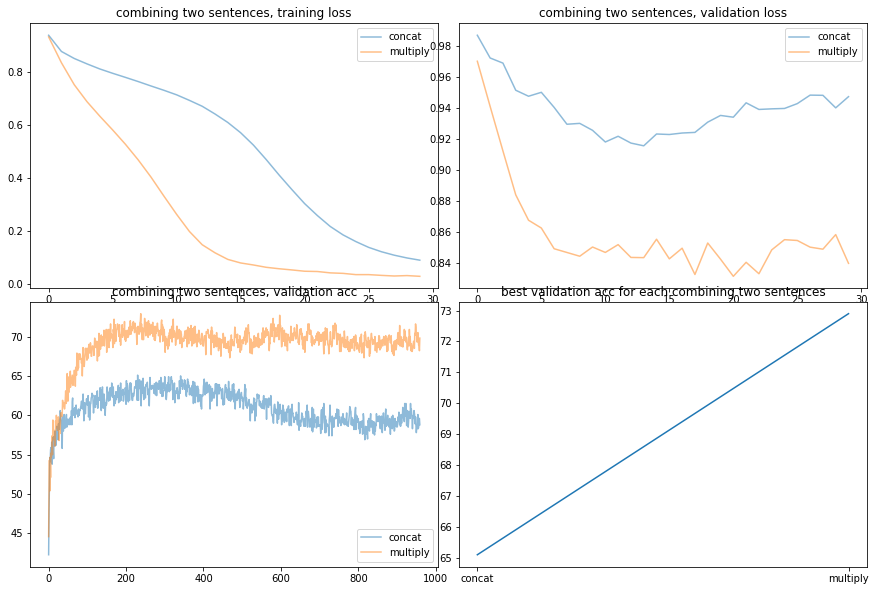

('multiply', 72.9)

In [35]:
### Better to align y axis for two loss graph

loss_lists, val_acc_lists, val_loss_lists = dict(), dict(), dict()
loss_lists['concat'] = unpickle_from_file('rnn_snli_step2_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_0_interaction_concat/loss.p')
val_acc_lists['concat'] = unpickle_from_file('rnn_snli_step2_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_0_interaction_concat/acc.p')
val_loss_lists['concat'] = unpickle_from_file('rnn_snli_step2_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_0_interaction_concat/val_loss.p')
loss_lists['multiply'] = unpickle_from_file('rnn_snli_step2_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_0_interaction_featurewise_multiplication/loss.p')
val_acc_lists['multiply'] = unpickle_from_file('rnn_snli_step2_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_0_interaction_featurewise_multiplication/acc.p')
val_loss_lists['multiply'] = unpickle_from_file('rnn_snli_step2_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_0_interaction_featurewise_multiplication/val_loss.p')
best_hyperparam, best_val = plot_train_validation_new(loss_lists, val_loss_lists, val_acc_lists, "combining two sentences")
best_hyperparam, best_val

In [9]:
np.logspace(-16,-2,15)

array([1.e-16, 1.e-15, 1.e-14, 1.e-13, 1.e-12, 1.e-11, 1.e-10, 1.e-09,
       1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02])

[0, 1e-16, 1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001] [72.9, 72.4, 72.0, 72.2, 72.5, 72.7, 72.2, 71.2, 71.2, 60.2, 54.8, 48.6, 48.3, 48.9, 33.8]


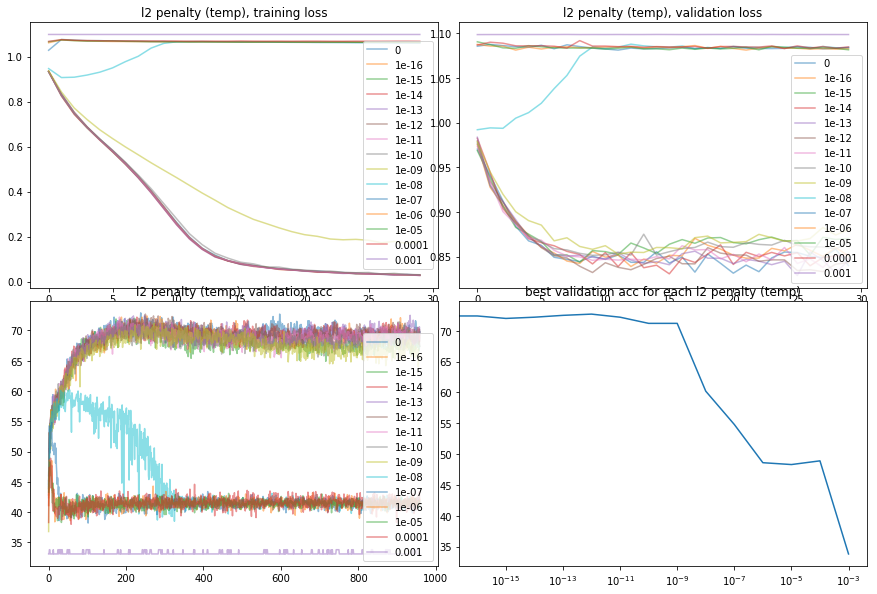

(0, 72.9)

In [20]:
### Better to align y axis for two loss graph

loss_lists, val_acc_lists, val_loss_lists = dict(), dict(), dict()
for n in [0]:
    loss_lists[n] = unpickle_from_file('rnn_snli_step2_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_{}_interaction_featurewise_multiplication/loss.p'.format(n))
    val_acc_lists[n] = unpickle_from_file('rnn_snli_step2_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_{}_interaction_featurewise_multiplication/acc.p'.format(n))
    val_loss_lists[n] = unpickle_from_file('rnn_snli_step2_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_{}_interaction_featurewise_multiplication/val_loss.p'.format(n))
for n in np.logspace(-16,-3,14):
    loss_lists[n] = unpickle_from_file('rnn_snli_step2_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_{}_interaction_featurewise_multiplication/loss.p'.format(n))
    val_acc_lists[n] = unpickle_from_file('rnn_snli_step2_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_{}_interaction_featurewise_multiplication/acc.p'.format(n))
    val_loss_lists[n] = unpickle_from_file('rnn_snli_step2_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_{}_interaction_featurewise_multiplication/val_loss.p'.format(n))
best_hyperparam, best_val = plot_train_validation_new(loss_lists, val_loss_lists, val_acc_lists, "l2 penalty (temp)", log=True)
best_hyperparam, best_val

In [ ]:
train("step2", 512, 70000, batch_size=32, num_epochs=30, model_type="rnn",interaction="featurewise_multiplication",relu=True)

In [ ]:
train("interaction_l2_avail", 256, 70000, batch_size=32, num_epochs=30, kernel_size=1, l2_penalty=1e-10, 
      model_type="cnn",interaction="featurewise_multiplication",relu=True)

torch.Size([70000, 300]) 21000000
torch.Size([256, 300, 1]) 76800
torch.Size([256]) 256
torch.Size([256, 256, 1]) 65536
torch.Size([256]) 256
torch.Size([256, 256]) 65536
torch.Size([256]) 256
torch.Size([3, 256]) 768
torch.Size([3]) 3
total params 21209411
fixed, three objects will be saved in three separate files
saved cnn_snli_interaction_l2_avail_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-10_interaction_featurewise_multiplication_relu_True/epoch_0_step_100.p
Epoch: [1/30], Step: [101/3125], Validation Acc: 33.8
Epoch: [1/30], Step: [201/3125], Validation Acc: 32.8
saved cnn_snli_interaction_l2_avail_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-10_interaction_featurewise_multiplication_relu_True/epoch_0_step_300.p
Epoch: [1/30], Step: [301/3125], Validation Acc: 39.5
saved cnn_snli_interaction_l2_avail_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-10_interaction_featurewise_multiplication_relu_True/epoch_0_step_400.p
Epoch: [1/30], Step: [401/312

Epoch: [3/30], Step: [401/3125], Validation Acc: 61.3
Epoch: [3/30], Step: [501/3125], Validation Acc: 64.0
Epoch: [3/30], Step: [601/3125], Validation Acc: 62.4
Epoch: [3/30], Step: [701/3125], Validation Acc: 64.4
saved cnn_snli_interaction_l2_avail_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-10_interaction_featurewise_multiplication_relu_True/epoch_2_step_800.p
Epoch: [3/30], Step: [801/3125], Validation Acc: 65.4
Epoch: [3/30], Step: [901/3125], Validation Acc: 64.7
Epoch: [3/30], Step: [1001/3125], Validation Acc: 65.2
Epoch: [3/30], Step: [1101/3125], Validation Acc: 65.4
saved cnn_snli_interaction_l2_avail_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-10_interaction_featurewise_multiplication_relu_True/epoch_2_step_1200.p
Epoch: [3/30], Step: [1201/3125], Validation Acc: 66.6
Epoch: [3/30], Step: [1301/3125], Validation Acc: 66.0
Epoch: [3/30], Step: [1401/3125], Validation Acc: 64.7
Epoch: [3/30], Step: [1501/3125], Validation Acc: 66.4
Epoch: [3/30], St

Epoch: [6/30], Step: [2201/3125], Validation Acc: 70.6
Epoch: [6/30], Step: [2301/3125], Validation Acc: 70.1
Epoch: [6/30], Step: [2401/3125], Validation Acc: 71.0
Epoch: [6/30], Step: [2501/3125], Validation Acc: 70.0
Epoch: [6/30], Step: [2601/3125], Validation Acc: 69.5
Epoch: [6/30], Step: [2701/3125], Validation Acc: 71.2
Epoch: [6/30], Step: [2801/3125], Validation Acc: 71.1
Epoch: [6/30], Step: [2901/3125], Validation Acc: 69.1
Epoch: [6/30], Step: [3001/3125], Validation Acc: 70.4
Epoch: [6/30], Step: [3101/3125], Validation Acc: 69.3
Epoch: [6/30], Validation Acc: 69.6, train mean loss: 0.6656316453266143, val mean loss: 0.8859951850026846
Epoch: [7/30], Step: [101/3125], Validation Acc: 70.1
Epoch: [7/30], Step: [201/3125], Validation Acc: 69.7
Epoch: [7/30], Step: [301/3125], Validation Acc: 69.8
Epoch: [7/30], Step: [401/3125], Validation Acc: 69.7
Epoch: [7/30], Step: [501/3125], Validation Acc: 70.5
Epoch: [7/30], Step: [601/3125], Validation Acc: 70.6
Epoch: [7/30], Ste

Epoch: [10/30], Step: [2801/3125], Validation Acc: 70.4
Epoch: [10/30], Step: [2901/3125], Validation Acc: 70.8
Epoch: [10/30], Step: [3001/3125], Validation Acc: 71.0
Epoch: [10/30], Step: [3101/3125], Validation Acc: 70.2
Epoch: [10/30], Validation Acc: 71.1, train mean loss: 0.5814265998888015, val mean loss: 0.8666090369224548
Epoch: [11/30], Step: [101/3125], Validation Acc: 71.9
Epoch: [11/30], Step: [201/3125], Validation Acc: 72.0
saved cnn_snli_interaction_l2_avail_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-10_interaction_featurewise_multiplication_relu_True/epoch_10_step_300.p
Epoch: [11/30], Step: [301/3125], Validation Acc: 73.3
Epoch: [11/30], Step: [401/3125], Validation Acc: 71.5
Epoch: [11/30], Step: [501/3125], Validation Acc: 68.4
Epoch: [11/30], Step: [601/3125], Validation Acc: 72.1
Epoch: [11/30], Step: [701/3125], Validation Acc: 70.0
Epoch: [11/30], Step: [801/3125], Validation Acc: 72.0
Epoch: [11/30], Step: [901/3125], Validation Acc: 72.2
Epoch: 

Epoch: [15/30], Step: [801/3125], Validation Acc: 69.5
Epoch: [15/30], Step: [901/3125], Validation Acc: 70.9
Epoch: [15/30], Step: [1001/3125], Validation Acc: 70.3
Epoch: [15/30], Step: [1101/3125], Validation Acc: 71.8
Epoch: [15/30], Step: [1201/3125], Validation Acc: 69.6
Epoch: [15/30], Step: [1301/3125], Validation Acc: 69.8
Epoch: [15/30], Step: [1401/3125], Validation Acc: 69.4
Epoch: [15/30], Step: [1501/3125], Validation Acc: 72.3
Epoch: [15/30], Step: [1601/3125], Validation Acc: 71.8
Epoch: [15/30], Step: [1701/3125], Validation Acc: 70.7
Epoch: [15/30], Step: [1801/3125], Validation Acc: 71.5
Epoch: [15/30], Step: [1901/3125], Validation Acc: 72.7
Epoch: [15/30], Step: [2001/3125], Validation Acc: 71.9
Epoch: [15/30], Step: [2101/3125], Validation Acc: 71.9
Epoch: [15/30], Step: [2201/3125], Validation Acc: 70.5
Epoch: [15/30], Step: [2301/3125], Validation Acc: 71.0
Epoch: [15/30], Step: [2401/3125], Validation Acc: 72.0
Epoch: [15/30], Step: [2501/3125], Validation Acc:

Epoch: [19/30], Step: [2101/3125], Validation Acc: 70.4
Epoch: [19/30], Step: [2201/3125], Validation Acc: 71.6
Epoch: [19/30], Step: [2301/3125], Validation Acc: 71.1
Epoch: [19/30], Step: [2401/3125], Validation Acc: 71.0
Epoch: [19/30], Step: [2501/3125], Validation Acc: 70.8
Epoch: [19/30], Step: [2601/3125], Validation Acc: 69.3
Epoch: [19/30], Step: [2701/3125], Validation Acc: 70.2
Epoch: [19/30], Step: [2801/3125], Validation Acc: 69.8
Epoch: [19/30], Step: [2901/3125], Validation Acc: 69.1
Epoch: [19/30], Step: [3001/3125], Validation Acc: 70.5
Epoch: [19/30], Step: [3101/3125], Validation Acc: 70.8
Epoch: [19/30], Validation Acc: 71.4, train mean loss: 0.4401201302361488, val mean loss: 0.8512277062982321
Epoch: [20/30], Step: [101/3125], Validation Acc: 71.0
Epoch: [20/30], Step: [201/3125], Validation Acc: 70.5
Epoch: [20/30], Step: [301/3125], Validation Acc: 70.3
Epoch: [20/30], Step: [401/3125], Validation Acc: 71.1
Epoch: [20/30], Step: [501/3125], Validation Acc: 71.7


['False', 'True'] [72.9, 73.1]


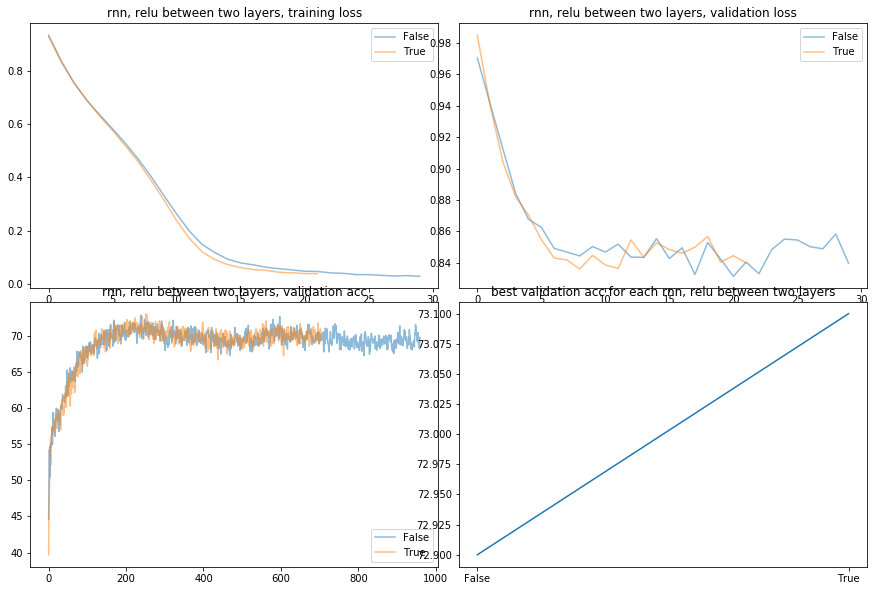

('True', 73.1)

In [7]:
### Better to align y axis for two loss graph

loss_lists, val_acc_lists, val_loss_lists = dict(), dict(), dict()
loss_lists['False'] = unpickle_from_file('rnn_snli_step2_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_0_interaction_featurewise_multiplication/loss.p')
val_acc_lists['False'] = unpickle_from_file('rnn_snli_step2_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_0_interaction_featurewise_multiplication/acc.p')
val_loss_lists['False'] = unpickle_from_file('rnn_snli_step2_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_0_interaction_featurewise_multiplication/val_loss.p')
loss_lists['True'] = unpickle_from_file('rnn_snli_step2_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_0_interaction_featurewise_multiplication_relu_True/loss.p')
val_acc_lists['True'] = unpickle_from_file('rnn_snli_step2_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_0_interaction_featurewise_multiplication_relu_True/acc.p')
val_loss_lists['True'] = unpickle_from_file('rnn_snli_step2_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_0_interaction_featurewise_multiplication_relu_True/val_loss.p')
best_hyperparam, best_val = plot_train_validation_new(loss_lists, val_loss_lists, val_acc_lists, "rnn, relu between two layers")
best_hyperparam, best_val

['False', 'True'] [72.9, 73.8]


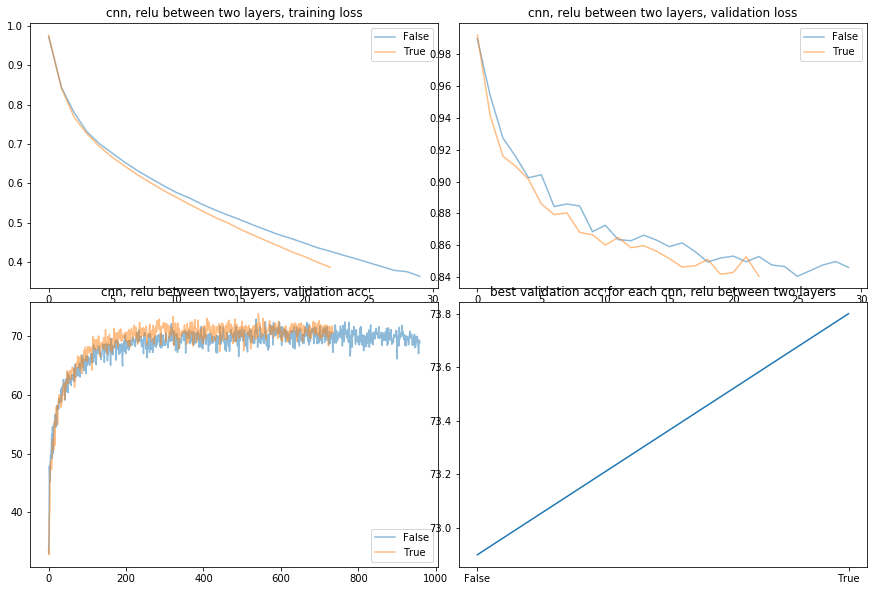

('True', 73.8)

In [8]:
### Better to align y axis for two loss graph
path1 = 'cnn_snli_interaction_l2_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-10_interaction_featurewise_multiplication'
path2 = 'cnn_snli_interaction_l2_avail_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-10_interaction_featurewise_multiplication_relu_True'
loss_lists, val_acc_lists, val_loss_lists = dict(), dict(), dict()
loss_lists['False'] = unpickle_from_file(path1+'/loss.p')
val_acc_lists['False'] = unpickle_from_file(path1+'/acc.p')
val_loss_lists['False'] = unpickle_from_file(path1+'/val_loss.p')
loss_lists['True'] = unpickle_from_file(path2+'/loss.p')
val_acc_lists['True'] = unpickle_from_file(path2+'/acc.p')
val_loss_lists['True'] = unpickle_from_file(path2+'/val_loss.p')
best_hyperparam, best_val = plot_train_validation_new(loss_lists, val_loss_lists, val_acc_lists, "cnn, relu between two layers")
best_hyperparam, best_val

['False', 'True'] [72.9, 73.1]


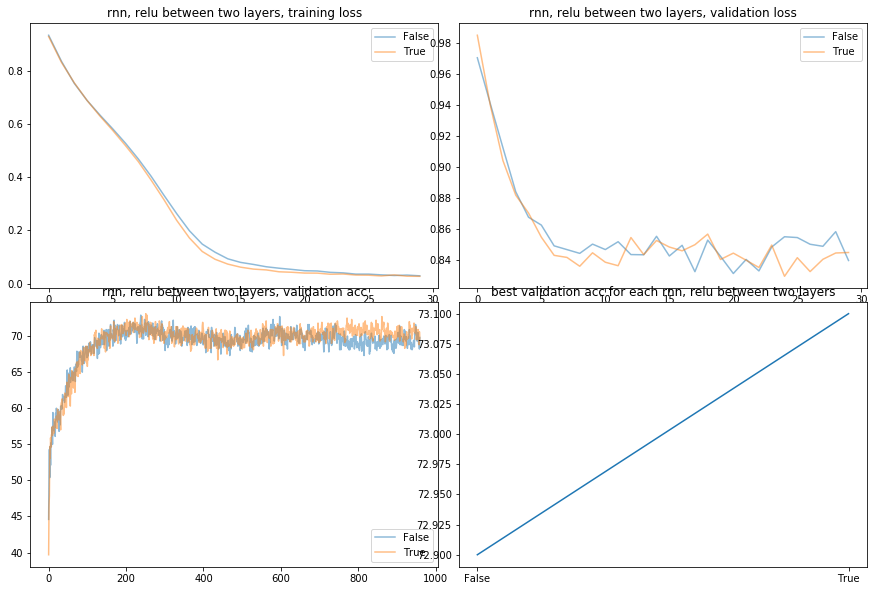

('True', 73.1)

In [27]:
### Better to align y axis for two loss graph

loss_lists, val_acc_lists, val_loss_lists = dict(), dict(), dict()
loss_lists['False'] = unpickle_from_file('rnn_snli_step2_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_0_interaction_featurewise_multiplication/loss.p')
val_acc_lists['False'] = unpickle_from_file('rnn_snli_step2_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_0_interaction_featurewise_multiplication/acc.p')
val_loss_lists['False'] = unpickle_from_file('rnn_snli_step2_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_0_interaction_featurewise_multiplication/val_loss.p')
loss_lists['True'] = unpickle_from_file('rnn_snli_step2_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_0_interaction_featurewise_multiplication_relu_True/loss.p')
val_acc_lists['True'] = unpickle_from_file('rnn_snli_step2_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_0_interaction_featurewise_multiplication_relu_True/acc.p')
val_loss_lists['True'] = unpickle_from_file('rnn_snli_step2_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_0_interaction_featurewise_multiplication_relu_True/val_loss.p')
best_hyperparam, best_val = plot_train_validation_new(loss_lists, val_loss_lists, val_acc_lists, "rnn, relu between two layers")
best_hyperparam, best_val

['False', 'True'] [72.9, 73.8]


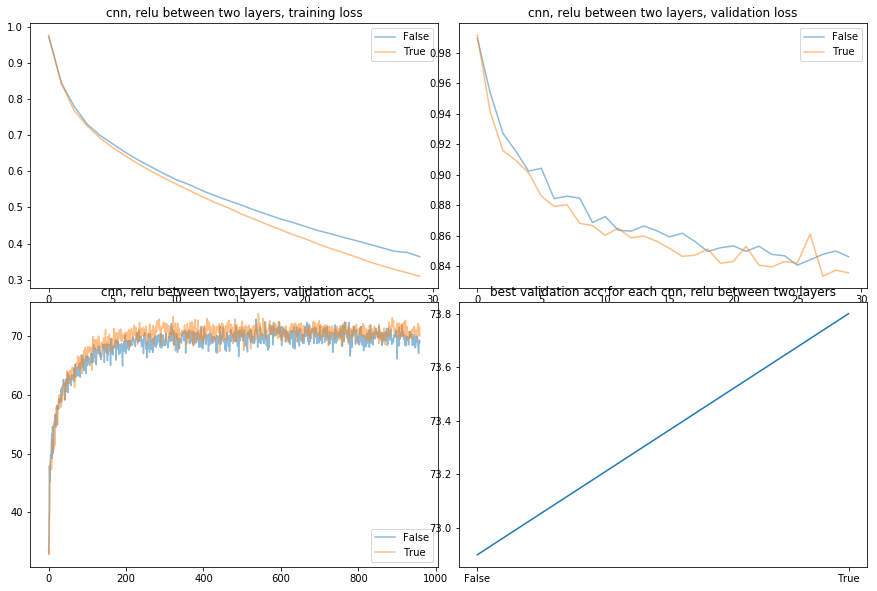

('True', 73.8)

In [28]:
### Better to align y axis for two loss graph
path1 = 'cnn_snli_interaction_l2_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-10_interaction_featurewise_multiplication'
path2 = 'cnn_snli_interaction_l2_avail_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-10_interaction_featurewise_multiplication_relu_True'
loss_lists, val_acc_lists, val_loss_lists = dict(), dict(), dict()
loss_lists['False'] = unpickle_from_file(path1+'/loss.p')
val_acc_lists['False'] = unpickle_from_file(path1+'/acc.p')
val_loss_lists['False'] = unpickle_from_file(path1+'/val_loss.p')
loss_lists['True'] = unpickle_from_file(path2+'/loss.p')
val_acc_lists['True'] = unpickle_from_file(path2+'/acc.p')
val_loss_lists['True'] = unpickle_from_file(path2+'/val_loss.p')
best_hyperparam, best_val = plot_train_validation_new(loss_lists, val_loss_lists, val_acc_lists, "cnn, relu between two layers")
best_hyperparam, best_val

# Bonus

In [9]:
best_cnn_model = 'cnn_snli_interaction_l2_avail_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-10_interaction_featurewise_multiplication_relu_True/epoch_16_step_3100.p'

In [10]:
show_result(best_cnn_model,256,relu=True,l2_penalty=1e-10,phase="fiction",max_vocab_size=70000,kernel_size=1,model_type="cnn",interaction="featurewise_multiplication")

torch.Size([70000, 300]) 21000000
torch.Size([256, 300, 1]) 76800
torch.Size([256]) 256
torch.Size([256, 256, 1]) 65536
torch.Size([256]) 256
torch.Size([256, 256]) 65536
torch.Size([256]) 256
torch.Size([3, 256]) 768
torch.Size([3]) 3
total params 21209411
val acc: 73.8
fixed, three objects will be saved in three separate files
saved cnn_mnli_train_fixed_fiction_epochs_10_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-10_interaction_featurewise_multiplication_relu_True/epoch_0_step_100.p
Epoch: [1/10], Step: [101/120], Validation Acc: 44.60285132382892
Epoch: [1/10], Validation Acc: 41.14052953156823, train mean loss: 1.1129634350538253, val mean loss: 1.0718672275543213
Epoch: [2/10], Step: [101/120], Validation Acc: 44.60285132382892
Epoch: [2/10], Validation Acc: 42.76985743380855, train mean loss: 1.0027940799792607, val mean loss: 1.063922474461217
Epoch: [3/10], Step: [101/120], Validation Acc: 43.9918533604888
Epoch: [3/10], Validation Acc: 42.15885947046843, train me

In [11]:
show_result(best_cnn_model,256,relu=True,l2_penalty=1e-10,phase="telephone",max_vocab_size=70000,kernel_size=1,model_type="cnn",interaction="featurewise_multiplication")

torch.Size([70000, 300]) 21000000
torch.Size([256, 300, 1]) 76800
torch.Size([256]) 256
torch.Size([256, 256, 1]) 65536
torch.Size([256]) 256
torch.Size([256, 256]) 65536
torch.Size([256]) 256
torch.Size([3, 256]) 768
torch.Size([3]) 3
total params 21209411
val acc: 73.8
fixed, three objects will be saved in three separate files
saved cnn_mnli_train_fixed_telephone_epochs_10_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-10_interaction_featurewise_multiplication_relu_True/epoch_0_step_100.p
Epoch: [1/10], Step: [101/134], Validation Acc: 43.890020366598776
Epoch: [1/10], Validation Acc: 43.788187372708755, train mean loss: 1.1083314930325123, val mean loss: 1.0658634574182573
Epoch: [2/10], Step: [101/134], Validation Acc: 43.890020366598776
Epoch: [2/10], Validation Acc: 43.788187372708755, train mean loss: 0.9941372604512456, val mean loss: 1.0616141596148092
saved cnn_mnli_train_fixed_telephone_epochs_10_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-10_interacti

In [12]:
show_result(best_cnn_model,256,relu=True,l2_penalty=1e-10,phase="slate",max_vocab_size=70000,kernel_size=1,model_type="cnn",interaction="featurewise_multiplication")

torch.Size([70000, 300]) 21000000
torch.Size([256, 300, 1]) 76800
torch.Size([256]) 256
torch.Size([256, 256, 1]) 65536
torch.Size([256]) 256
torch.Size([256, 256]) 65536
torch.Size([256]) 256
torch.Size([3, 256]) 768
torch.Size([3]) 3
total params 21209411
val acc: 73.8
fixed, three objects will be saved in three separate files
saved cnn_mnli_train_fixed_slate_epochs_10_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-10_interaction_featurewise_multiplication_relu_True/epoch_0_step_100.p
Epoch: [1/10], Step: [101/126], Validation Acc: 41.24236252545825
saved cnn_mnli_train_fixed_slate_epochs_10_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-10_interaction_featurewise_multiplication_relu_True/epoch_0_step_epoch_done.p
Epoch: [1/10], Validation Acc: 43.788187372708755, train mean loss: 1.166264815936013, val mean loss: 1.06885112485578
Epoch: [2/10], Step: [101/126], Validation Acc: 42.871690427698574
saved cnn_mnli_train_fixed_slate_epochs_10_maxvocab_70000_hid_256_ba

In [13]:
show_result(best_cnn_model,256,relu=True,l2_penalty=1e-10,phase="government",max_vocab_size=70000,kernel_size=1,model_type="cnn",interaction="featurewise_multiplication")

torch.Size([70000, 300]) 21000000
torch.Size([256, 300, 1]) 76800
torch.Size([256]) 256
torch.Size([256, 256, 1]) 65536
torch.Size([256]) 256
torch.Size([256, 256]) 65536
torch.Size([256]) 256
torch.Size([3, 256]) 768
torch.Size([3]) 3
total params 21209411
val acc: 73.8
fixed, three objects will be saved in three separate files
saved cnn_mnli_train_fixed_government_epochs_10_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-10_interaction_featurewise_multiplication_relu_True/epoch_0_step_100.p
Epoch: [1/10], Step: [101/122], Validation Acc: 42.973523421588595
Epoch: [1/10], Validation Acc: 41.44602851323829, train mean loss: 1.10656011886284, val mean loss: 1.0659053479471514
saved cnn_mnli_train_fixed_government_epochs_10_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-10_interaction_featurewise_multiplication_relu_True/epoch_1_step_100.p
Epoch: [2/10], Step: [101/122], Validation Acc: 44.5010183299389
Epoch: [2/10], Validation Acc: 42.56619144602851, train mean loss:

In [14]:
show_result(best_cnn_model,256,relu=True,l2_penalty=1e-10,phase="travel",max_vocab_size=70000,kernel_size=1,model_type="cnn",interaction="featurewise_multiplication")

torch.Size([70000, 300]) 21000000
torch.Size([256, 300, 1]) 76800
torch.Size([256]) 256
torch.Size([256, 256, 1]) 65536
torch.Size([256]) 256
torch.Size([256, 256]) 65536
torch.Size([256]) 256
torch.Size([3, 256]) 768
torch.Size([3]) 3
total params 21209411
val acc: 73.8
fixed, three objects will be saved in three separate files
saved cnn_mnli_train_fixed_travel_epochs_10_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-10_interaction_featurewise_multiplication_relu_True/epoch_0_step_100.p
Epoch: [1/10], Step: [101/125], Validation Acc: 47.55600814663951
Epoch: [1/10], Validation Acc: 45.621181262729124, train mean loss: 1.1784677510261536, val mean loss: 1.051143926958884
saved cnn_mnli_train_fixed_travel_epochs_10_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-10_interaction_featurewise_multiplication_relu_True/epoch_1_step_100.p
Epoch: [2/10], Step: [101/125], Validation Acc: 48.87983706720978
Epoch: [2/10], Validation Acc: 48.37067209775967, train mean loss: 0.985

['fiction', 'telephone', 'slate', 'government', 'travel'] [45.010183299389, 43.9918533604888, 45.41751527494908, 46.13034623217923, 49.89816700610998]


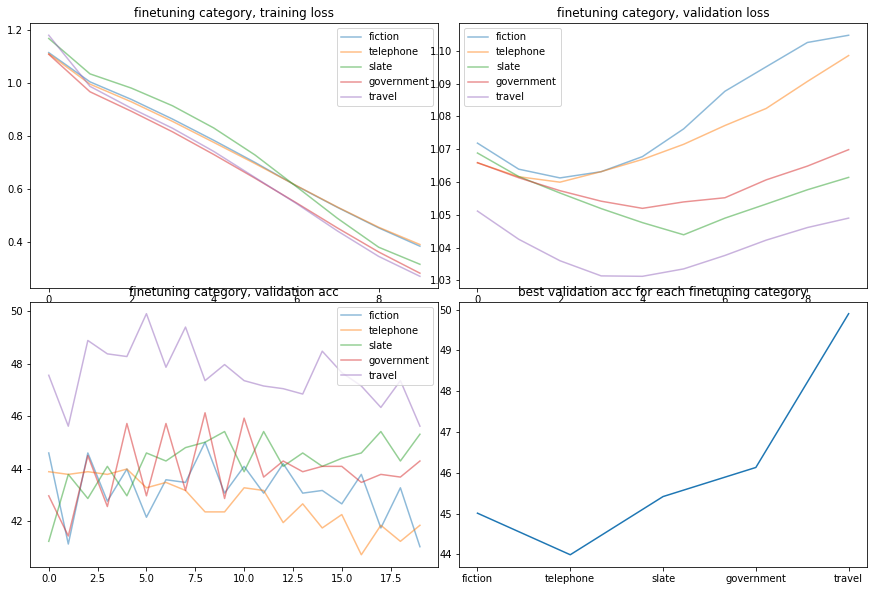

('travel', 49.89816700610998)

In [15]:
### Better to align y axis for two loss graph

loss_lists, val_acc_lists, val_loss_lists = dict(), dict(), dict()
for n in ["fiction", "telephone", "slate", "government", "travel"]:
    loss_lists[n] = unpickle_from_file('cnn_mnli_train_fixed_{}_epochs_10_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-10_interaction_featurewise_multiplication_relu_True/loss.p'.format(n))
    val_acc_lists[n] = unpickle_from_file('cnn_mnli_train_fixed_{}_epochs_10_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-10_interaction_featurewise_multiplication_relu_True/acc.p'.format(n))
    val_loss_lists[n] = unpickle_from_file('cnn_mnli_train_fixed_{}_epochs_10_maxvocab_70000_hid_256_batch_32_kernel_1_lr_0.0003_l2_1e-10_interaction_featurewise_multiplication_relu_True/val_loss.p'.format(n))
best_hyperparam, best_val = plot_train_validation_new(loss_lists, val_loss_lists, val_acc_lists, "finetuning category")
best_hyperparam, best_val

In [16]:
rnn_best_model = 'rnn_snli_step2_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_0_interaction_featurewise_multiplication_relu_True/epoch_7_step_2800.p'

In [17]:
show_result(rnn_best_model,512,relu=True,l2_penalty=0,phase="fiction",max_vocab_size=70000,model_type="rnn",interaction="featurewise_multiplication")

torch.Size([70000, 300]) 21000000
torch.Size([1536, 300]) 460800
torch.Size([1536, 512]) 786432
torch.Size([1536]) 1536
torch.Size([1536]) 1536
torch.Size([1536, 300]) 460800
torch.Size([1536, 512]) 786432
torch.Size([1536]) 1536
torch.Size([1536]) 1536
torch.Size([1536, 300]) 460800
torch.Size([1536, 512]) 786432
torch.Size([1536]) 1536
torch.Size([1536]) 1536
torch.Size([1536, 300]) 460800
torch.Size([1536, 512]) 786432
torch.Size([1536]) 1536
torch.Size([1536]) 1536
torch.Size([512, 1024]) 524288
torch.Size([512]) 512
torch.Size([3, 512]) 1536
torch.Size([3]) 3
total params 26527555
val acc: 73.0
fixed, three objects will be saved in three separate files
saved rnn_mnli_train_fixed_fiction_epochs_10_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_0_interaction_featurewise_multiplication_relu_True/epoch_0_step_100.p
Epoch: [1/10], Step: [101/120], Validation Acc: 46.84317718940937
saved rnn_mnli_train_fixed_fiction_epochs_10_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_

In [18]:
show_result(rnn_best_model,512,relu=True,l2_penalty=0,phase="telephone",max_vocab_size=70000,model_type="rnn",interaction="featurewise_multiplication")

torch.Size([70000, 300]) 21000000
torch.Size([1536, 300]) 460800
torch.Size([1536, 512]) 786432
torch.Size([1536]) 1536
torch.Size([1536]) 1536
torch.Size([1536, 300]) 460800
torch.Size([1536, 512]) 786432
torch.Size([1536]) 1536
torch.Size([1536]) 1536
torch.Size([1536, 300]) 460800
torch.Size([1536, 512]) 786432
torch.Size([1536]) 1536
torch.Size([1536]) 1536
torch.Size([1536, 300]) 460800
torch.Size([1536, 512]) 786432
torch.Size([1536]) 1536
torch.Size([1536]) 1536
torch.Size([512, 1024]) 524288
torch.Size([512]) 512
torch.Size([3, 512]) 1536
torch.Size([3]) 3
total params 26527555
val acc: 73.2
fixed, three objects will be saved in three separate files
saved rnn_mnli_train_fixed_telephone_epochs_10_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_0_interaction_featurewise_multiplication_relu_True/epoch_0_step_100.p
Epoch: [1/10], Step: [101/134], Validation Acc: 45.5193482688391
Epoch: [1/10], Validation Acc: 45.5193482688391, train mean loss: 1.0580459948795944, val mean los

In [19]:
show_result(rnn_best_model,512,relu=True,l2_penalty=0,phase="slate",max_vocab_size=70000,model_type="rnn",interaction="featurewise_multiplication")

torch.Size([70000, 300]) 21000000
torch.Size([1536, 300]) 460800
torch.Size([1536, 512]) 786432
torch.Size([1536]) 1536
torch.Size([1536]) 1536
torch.Size([1536, 300]) 460800
torch.Size([1536, 512]) 786432
torch.Size([1536]) 1536
torch.Size([1536]) 1536
torch.Size([1536, 300]) 460800
torch.Size([1536, 512]) 786432
torch.Size([1536]) 1536
torch.Size([1536]) 1536
torch.Size([1536, 300]) 460800
torch.Size([1536, 512]) 786432
torch.Size([1536]) 1536
torch.Size([1536]) 1536
torch.Size([512, 1024]) 524288
torch.Size([512]) 512
torch.Size([3, 512]) 1536
torch.Size([3]) 3
total params 26527555
val acc: 73.0
fixed, three objects will be saved in three separate files
saved rnn_mnli_train_fixed_slate_epochs_10_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_0_interaction_featurewise_multiplication_relu_True/epoch_0_step_100.p
Epoch: [1/10], Step: [101/126], Validation Acc: 44.29735234215886
saved rnn_mnli_train_fixed_slate_epochs_10_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_0_in

In [20]:
show_result(rnn_best_model,512,relu=True,l2_penalty=0,phase="government",max_vocab_size=70000,model_type="rnn",interaction="featurewise_multiplication")

torch.Size([70000, 300]) 21000000
torch.Size([1536, 300]) 460800
torch.Size([1536, 512]) 786432
torch.Size([1536]) 1536
torch.Size([1536]) 1536
torch.Size([1536, 300]) 460800
torch.Size([1536, 512]) 786432
torch.Size([1536]) 1536
torch.Size([1536]) 1536
torch.Size([1536, 300]) 460800
torch.Size([1536, 512]) 786432
torch.Size([1536]) 1536
torch.Size([1536]) 1536
torch.Size([1536, 300]) 460800
torch.Size([1536, 512]) 786432
torch.Size([1536]) 1536
torch.Size([1536]) 1536
torch.Size([512, 1024]) 524288
torch.Size([512]) 512
torch.Size([3, 512]) 1536
torch.Size([3]) 3
total params 26527555
val acc: 73.3
fixed, three objects will be saved in three separate files
saved rnn_mnli_train_fixed_government_epochs_10_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_0_interaction_featurewise_multiplication_relu_True/epoch_0_step_100.p
Epoch: [1/10], Step: [101/122], Validation Acc: 46.33401221995927
Epoch: [1/10], Validation Acc: 45.5193482688391, train mean loss: 1.0362653126482104, val mean l

In [21]:
show_result(rnn_best_model,512,relu=True,l2_penalty=0,phase="travel",max_vocab_size=70000,model_type="rnn",interaction="featurewise_multiplication")

torch.Size([70000, 300]) 21000000
torch.Size([1536, 300]) 460800
torch.Size([1536, 512]) 786432
torch.Size([1536]) 1536
torch.Size([1536]) 1536
torch.Size([1536, 300]) 460800
torch.Size([1536, 512]) 786432
torch.Size([1536]) 1536
torch.Size([1536]) 1536
torch.Size([1536, 300]) 460800
torch.Size([1536, 512]) 786432
torch.Size([1536]) 1536
torch.Size([1536]) 1536
torch.Size([1536, 300]) 460800
torch.Size([1536, 512]) 786432
torch.Size([1536]) 1536
torch.Size([1536]) 1536
torch.Size([512, 1024]) 524288
torch.Size([512]) 512
torch.Size([3, 512]) 1536
torch.Size([3]) 3
total params 26527555
val acc: 72.5
fixed, three objects will be saved in three separate files
saved rnn_mnli_train_fixed_travel_epochs_10_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_0_interaction_featurewise_multiplication_relu_True/epoch_0_step_100.p
Epoch: [1/10], Step: [101/125], Validation Acc: 48.87983706720978
saved rnn_mnli_train_fixed_travel_epochs_10_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_0_

['fiction', 'telephone', 'slate', 'government', 'travel'] [48.676171079429736, 48.06517311608961, 48.574338085539715, 48.472505091649694, 51.22199592668024]


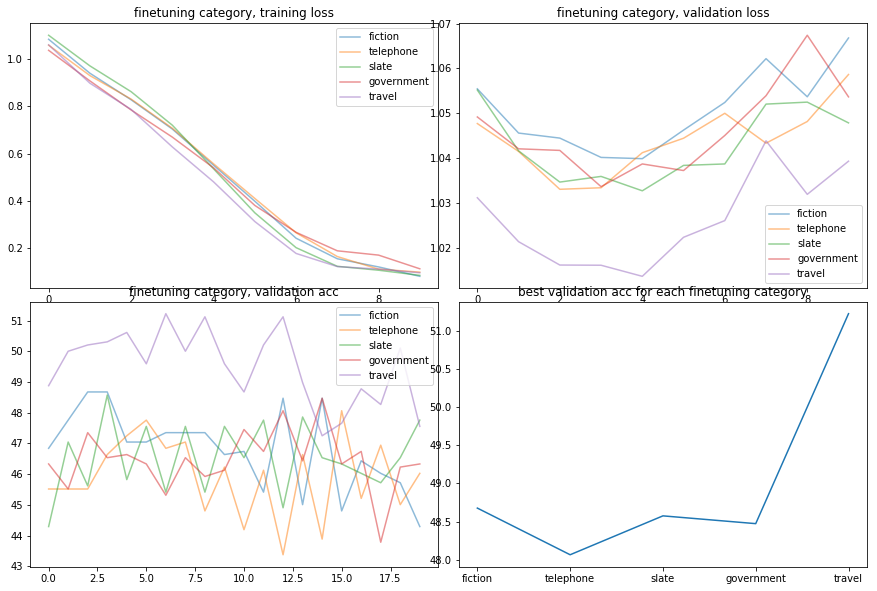

('travel', 51.22199592668024)

In [22]:
### Better to align y axis for two loss graph

loss_lists, val_acc_lists, val_loss_lists = dict(), dict(), dict()
for n in ["fiction", "telephone", "slate", "government", "travel"]:
    loss_lists[n] = unpickle_from_file('rnn_mnli_train_fixed_{}_epochs_10_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_0_interaction_featurewise_multiplication_relu_True/loss.p'.format(n))
    val_acc_lists[n] = unpickle_from_file('rnn_mnli_train_fixed_{}_epochs_10_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_0_interaction_featurewise_multiplication_relu_True/acc.p'.format(n))
    val_loss_lists[n] = unpickle_from_file('rnn_mnli_train_fixed_{}_epochs_10_maxvocab_70000_hid_512_batch_32_kernel_3_lr_0.0003_l2_0_interaction_featurewise_multiplication_relu_True/val_loss.p'.format(n))
best_hyperparam, best_val = plot_train_validation_new(loss_lists, val_loss_lists, val_acc_lists, "finetuning category", bar=False)
best_hyperparam, best_val

In [23]:
show_result(best_cnn_model,256,relu=True,l2_penalty=1e-10,phase="val",max_vocab_size=70000,kernel_size=1,model_type="cnn",interaction="featurewise_multiplication")

torch.Size([70000, 300]) 21000000
torch.Size([256, 300, 1]) 76800
torch.Size([256]) 256
torch.Size([256, 256, 1]) 65536
torch.Size([256]) 256
torch.Size([256, 256]) 65536
torch.Size([256]) 256
torch.Size([3, 256]) 768
torch.Size([3]) 3
total params 21209411
val acc: 73.8
val acc: (73.8, [0.8785444498062134, 0.8227289915084839, 0.7810887098312378, 0.7624747157096863, 0.8086762428283691, 0.9331377744674683, 0.9287438988685608, 0.7553530931472778, 0.8728014826774597, 0.7227705121040344, 0.8638390898704529, 0.7492682933807373, 0.8591205477714539, 0.8185489177703857, 0.8380894064903259, 0.8644698262214661, 0.7968786358833313, 0.8911667466163635, 0.8522469401359558, 0.8438253402709961, 0.875497043132782, 0.8514043092727661, 0.8501916527748108, 0.878679633140564, 0.8734024167060852, 0.8258660435676575, 0.8051583170890808, 0.826079249382019, 0.9225012063980103, 0.7965860366821289, 0.8417389392852783, 0.945336103439331])
Correct examples:
true label is neutral , prediction is neutral
original s

In [29]:
pd.set_option('display.max_colwidth', -1)
show_result(best_cnn_model,256,relu=True,l2_penalty=1e-10,phase="val",max_vocab_size=70000,kernel_size=1,model_type="cnn",interaction="featurewise_multiplication")

torch.Size([70000, 300]) 21000000
torch.Size([256, 300, 1]) 76800
torch.Size([256]) 256
torch.Size([256, 256, 1]) 65536
torch.Size([256]) 256
torch.Size([256, 256]) 65536
torch.Size([256]) 256
torch.Size([3, 256]) 768
torch.Size([3]) 3
total params 21209411
val acc: 73.8
val acc: (73.8, [0.8785444498062134, 0.8227289915084839, 0.7810887098312378, 0.7624747157096863, 0.8086762428283691, 0.9331377744674683, 0.9287438988685608, 0.7553530931472778, 0.8728014826774597, 0.7227705121040344, 0.8638390898704529, 0.7492682933807373, 0.8591205477714539, 0.8185489177703857, 0.8380894064903259, 0.8644698262214661, 0.7968786358833313, 0.8911667466163635, 0.8522469401359558, 0.8438253402709961, 0.875497043132782, 0.8514043092727661, 0.8501916527748108, 0.878679633140564, 0.8734024167060852, 0.8258660435676575, 0.8051583170890808, 0.826079249382019, 0.9225012063980103, 0.7965860366821289, 0.8417389392852783, 0.945336103439331])
Correct examples:
true label is neutral , prediction is neutral
original s

show_result(rnn_best_model,512,relu=True,l2_penalty=0,phase="val",max_vocab_size=70000,model_type="rnn",interaction="featurewise_multiplication")

In [25]:
show_result(best_cnn_model,256,relu=True,l2_penalty=1e-10,phase="test",max_vocab_size=70000,kernel_size=1,model_type="cnn",interaction="featurewise_multiplication")

torch.Size([70000, 300]) 21000000
torch.Size([256, 300, 1]) 76800
torch.Size([256]) 256
torch.Size([256, 256, 1]) 65536
torch.Size([256]) 256
torch.Size([256, 256]) 65536
torch.Size([256]) 256
torch.Size([3, 256]) 768
torch.Size([3]) 3
total params 21209411
val acc: 73.8
fiction test acc: 43.618090452261306
telephone test acc: 41.492537313432834
slate test acc: 40.7185628742515
government test acc: 40.25590551181102
travel test acc: 41.54786150712831


In [26]:
show_result(rnn_best_model,512,relu=True,l2_penalty=0,phase="test",max_vocab_size=70000,model_type="rnn",interaction="featurewise_multiplication")

torch.Size([70000, 300]) 21000000
torch.Size([1536, 300]) 460800
torch.Size([1536, 512]) 786432
torch.Size([1536]) 1536
torch.Size([1536]) 1536
torch.Size([1536, 300]) 460800
torch.Size([1536, 512]) 786432
torch.Size([1536]) 1536
torch.Size([1536]) 1536
torch.Size([1536, 300]) 460800
torch.Size([1536, 512]) 786432
torch.Size([1536]) 1536
torch.Size([1536]) 1536
torch.Size([1536, 300]) 460800
torch.Size([1536, 512]) 786432
torch.Size([1536]) 1536
torch.Size([1536]) 1536
torch.Size([512, 1024]) 524288
torch.Size([512]) 512
torch.Size([3, 512]) 1536
torch.Size([3]) 3
total params 26527555
val acc: 73.5
fiction test acc: 48.14070351758794
telephone test acc: 45.67164179104478
slate test acc: 44.91017964071856
government test acc: 43.89763779527559
travel test acc: 44.70468431771894
